In [178]:
# !pip install lightgbm

In [179]:
# Basic libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Utils
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, \
                                          classification_report, confusion_matrix, plot_confusion_matrix
from scipy.stats import loguniform

# Preprocessing
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV

# Algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier, XGBRFClassifier, plot_importance
from tensorflow.keras import layers, models

import warnings
warnings.filterwarnings('ignore')

In [180]:
people = pd.read_csv('../raw_data/people_feat_eng.csv')

In [181]:
people.head()

attrition  business_travel  daily_rate  distance_from_home  education  \
0          0                0        1476                   1          3   
1          0                1        1276                   2          1   
2          0                1        1490                   7          4   
3          0                2        1302                   6          4   
4          0                0         280                   1          2   

   environment_satisfaction  hourly_rate  job_satisfaction  monthly_rate  \
0                         3           55                 4         16392   
1                         4           59                 4         17536   
2                         3           35                 2         20948   
3                         1           80                 1         19711   
4                         3           43                 4         10494   

   num_companies_worked  ...  training_times_last_year  years_in_current_role  \
0                     0  ...                         6                      8   
1                     1  ...                         4                      0   
2                     3  ...                         3                      7   
3                     3  ...                         3                      2   
4                     1  ...                         2                      2   

   years_with_curr_manager  below_median_dpt_joblevel_monthly_income  \
0                        5                                         0   
1                        0                                         1   
2                        7                                         0   
3                        2                                         0   
4                        2                                         0   

   job_role_diff_edu_field  promoted_last_2_years  \
0                        0                      0   
1                        0                      1   
2                        0                      1   
3                        0                      1   
4                        1                      1   

   m_income_per_total_years_worked  m_income_per_age  \
0                       667.400000        238.357143   
1                      1129.000000         36.419355   
2                       360.896552        213.591837   
3                       618.000000        154.500000   
4                       902.000000         96.642857   

   below_median_pct_salary_hike  gender_male  
0                             1            0  
1                             1            0  
2                             0            1  
3                             1            1  
4                             0            1  

[5 rows x 23 columns]

In [182]:
people['attrition'].value_counts()

0    923
1    179
Name: attrition, dtype: int64

In [183]:
X = people.drop('attrition', axis = 1)
y = people['attrition']

In [184]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state = 0)
X_train.shape

(826, 22)

## SMOTE

In [185]:
smote = SMOTE(random_state = 0)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [186]:
y_train_smote.value_counts()

1    687
0    687
Name: attrition, dtype: int64

## Scaling

In [187]:
# plt.figure(figsize = (10, 10))
# for i, feature in enumerate(X_train_smote.columns.tolist()):
# #     for i in plt.subplot(2, 2, i + 1):
#     f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, 
#                                         gridspec_kw={"height_ratios": (.15, .85)})

#     sns.boxplot(X_train_smote[feature], ax=ax_box)
#     sns.distplot(X_train_smote[feature], ax=ax_hist)

#     ax_box.set(yticks=[])
#     sns.despine(ax=ax_hist)
#     sns.despine(ax=ax_box, left=True);

In [188]:
to_robust_scale = [
    'distance_from_home',
    'education',
    'num_companies_worked',
    'stock_option_level',
    'training_times_last_year',
    'years_in_current_role',
    'years_with_curr_manager',
    'm_income_per_total_years_worked',
    'm_income_per_age'
]

rb_scaler = RobustScaler()
X_train_smote[to_robust_scale] = rb_scaler.fit_transform(X_train_smote[to_robust_scale])
X_val[to_robust_scale] = rb_scaler.transform(X_val[to_robust_scale])

In [189]:
to_stand_scale = [
    set(X_train_smote.columns.tolist()) - set(to_robust_scale)
]

to_stand_scale = list(to_stand_scale[0])

In [190]:
stand_scaler = StandardScaler()
X_train_smote[to_stand_scale] = stand_scaler.fit_transform(X_train_smote[to_stand_scale])
X_val[to_stand_scale] = stand_scaler.transform(X_val[to_stand_scale])

In [191]:
X_train_smote

business_travel  daily_rate  distance_from_home  education  \
0            2.007224   -1.466808                -0.4        0.0   
1           -0.110999   -1.333863                -0.5        2.0   
2           -0.110999    1.022649                -0.4        0.0   
3           -0.110999   -1.615394                -0.3       -2.0   
4           -0.110999    0.136350                -0.2        1.0   
...               ...         ...                 ...        ...   
1369        -0.110999    0.151991                -0.1        0.0   
1370        -0.110999   -0.682173                -0.2        0.0   
1371        -0.110999    0.615994                 1.2       -1.0   
1372        -0.110999   -1.211345                -0.5        0.0   
1373        -2.229221    0.847996                 0.6        0.0   

      environment_satisfaction  hourly_rate  job_satisfaction  monthly_rate  \
0                     1.386785    -0.813352          0.467478     -0.551869   
1                     1.386785     1.432708          0.467478      0.876180   
2                    -0.462262     0.701433         -0.484099     -1.462414   
3                     0.462262    -0.708884         -0.484099     -0.184334   
4                     0.462262    -0.082076          1.419055      0.082432   
...                        ...          ...               ...           ...   
1369                  0.462262     0.022391         -1.435676      1.326923   
1370                 -1.386785    -0.813352         -0.484099      0.080760   
1371                 -0.462262    -1.492393         -0.484099      0.668789   
1372                 -0.462262     0.649199         -1.435676      1.691810   
1373                  0.462262     0.492497         -1.435676      0.008145   

      num_companies_worked  over_time  ...  training_times_last_year  \
0                 2.333333   1.671999  ...                       0.0   
1                 1.333333   1.671999  ...                      -2.0   
2                -0.333333  -0.598087  ...                       1.0   
3                -0.333333  -0.598087  ...                       1.0   
4                -0.333333  -0.598087  ...                       0.0   
...                    ...        ...  ...                       ...   
1369              0.666667  -0.598087  ...                       1.0   
1370              0.000000  -0.598087  ...                       0.0   
1371             -0.333333  -0.598087  ...                      -1.0   
1372              1.000000   1.671999  ...                       0.0   
1373              0.000000  -0.598087  ...                       0.0   

      years_in_current_role  years_with_curr_manager  \
0                       0.0                      2.2   
1                      -0.4                     -0.2   
2                      -0.4                     -0.4   
3                       0.0                      0.0   
4                       0.0                      0.0   
...                     ...                      ...   
1369                    0.0                      0.0   
1370                   -0.2                      0.4   
1371                   -0.4                     -0.4   
1372                   -0.2                     -0.2   
1373                    0.4                      0.2   

      below_median_dpt_joblevel_monthly_income  job_role_diff_edu_field  \
0                                     1.137463                 2.519443   
1                                    -0.879149                -0.396913   
2                                    -0.879149                 2.519443   
3                                    -0.879149                -0.396913   
4                                    -0.879149                -0.396913   
...                                        ...                      ...   
1369                                  1.137463                -0.396913   
1370                                 -0.879149                -0.396913   
1371                       

In [192]:
# X_train_smote.drop('monthly_rate', axis =1, inplace = True)

In [193]:
# X_train

In [194]:
# X_val.drop('monthly_rate', axis = 1, inplace = True)

## Models

### Logistic Regression

In [195]:
log_model = LogisticRegression(random_state = 0)
log_model.fit(X_train_smote, y_train_smote)

LogisticRegression(random_state=0)

In [196]:
y_pred_logm = log_model.predict(X_val)

In [197]:
print(classification_report(y_val, y_pred_logm))

              precision    recall  f1-score   support

           0       0.92      0.83      0.87       236
           1       0.35      0.55      0.43        40

    accuracy                           0.79       276
   macro avg       0.63      0.69      0.65       276
weighted avg       0.83      0.79      0.80       276



#### Studying threshold values

In [198]:
for threshold in np.arange(0,1,0.01):
    predicted_proba = log_model.predict_proba(X_val)
    predicted = (predicted_proba[:, 1] >= threshold).astype('int')
    print(threshold, '================================================== \n', 
          classification_report(y_val, predicted))

0.0 ================================================== 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       236
           1       0.14      1.00      0.25        40

    accuracy                           0.14       276
   macro avg       0.07      0.50      0.13       276
weighted avg       0.02      0.14      0.04       276

0.01 ================================================== 
               precision    recall  f1-score   support

           0       1.00      0.06      0.11       236
           1       0.15      1.00      0.26        40

    accuracy                           0.20       276
   macro avg       0.58      0.53      0.19       276
weighted avg       0.88      0.20      0.13       276

0.02 ================================================== 
               precision    recall  f1-score   support

           0       0.96      0.10      0.18       236
           1       0.16      0.97      0.27        40

    accur

0.31 ================================================== 
               precision    recall  f1-score   support

           0       0.93      0.63      0.75       236
           1       0.24      0.70      0.36        40

    accuracy                           0.64       276
   macro avg       0.58      0.67      0.56       276
weighted avg       0.83      0.64      0.69       276

0.32 ================================================== 
               precision    recall  f1-score   support

           0       0.92      0.64      0.75       236
           1       0.24      0.68      0.35        40

    accuracy                           0.64       276
   macro avg       0.58      0.66      0.55       276
weighted avg       0.82      0.64      0.69       276

0.33 ================================================== 
               precision    recall  f1-score   support

           0       0.92      0.65      0.76       236
           1       0.25      0.68      0.36        40

    accu

0.62 ================================================== 
               precision    recall  f1-score   support

           0       0.90      0.89      0.89       236
           1       0.38      0.40      0.39        40

    accuracy                           0.82       276
   macro avg       0.64      0.64      0.64       276
weighted avg       0.82      0.82      0.82       276

0.63 ================================================== 
               precision    recall  f1-score   support

           0       0.90      0.89      0.90       236
           1       0.39      0.40      0.40        40

    accuracy                           0.82       276
   macro avg       0.64      0.65      0.65       276
weighted avg       0.82      0.82      0.82       276

0.64 ================================================== 
               precision    recall  f1-score   support

           0       0.90      0.90      0.90       236
           1       0.40      0.40      0.40        40

    accu

0.85 ================================================== 
               precision    recall  f1-score   support

           0       0.88      0.98      0.92       236
           1       0.58      0.17      0.27        40

    accuracy                           0.86       276
   macro avg       0.73      0.58      0.60       276
weighted avg       0.83      0.86      0.83       276

0.86 ================================================== 
               precision    recall  f1-score   support

           0       0.88      0.98      0.92       236
           1       0.58      0.17      0.27        40

    accuracy                           0.86       276
   macro avg       0.73      0.58      0.60       276
weighted avg       0.83      0.86      0.83       276

0.87 ================================================== 
               precision    recall  f1-score   support

           0       0.88      0.98      0.92       236
           1       0.58      0.17      0.27        40

    accu

In [199]:
cv_log_model = cross_validate(log_model, X_train_smote, y_train_smote, cv = 10, scoring = ['recall', 'f1'])
print('Recall  : ', cv_log_model['test_recall'].mean())
print('F1-score: ', cv_log_model['test_f1'].mean())

Recall  :  0.7893222506393862
F1-score:  0.7794481020128445


#### RandomSearch

In [200]:
rand_params = {
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'C': loguniform(0.01, 1),
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'tol': loguniform(1e-4, 1e-2),
    'l1_ratio': loguniform(0.001, .01)
}

rand_search_log_model = RandomizedSearchCV(log_model, param_distributions = rand_params, n_iter = 250,
                                           cv = 10, scoring = ['recall', 'f1'], refit = 'f1',
                                           verbose = 1, n_jobs = -1)

In [201]:
rand_search_log_model.fit(X_train_smote, y_train_smote)

Fitting 10 folds for each of 250 candidates, totalling 2500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 2500 out of 2500 | elapsed:   11.2s finished


RandomizedSearchCV(cv=10, estimator=LogisticRegression(random_state=0),
                   n_iter=250, n_jobs=-1,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x14b542ed0>,
                                        'l1_ratio': <scipy.stats._distn_infrastructure.rv_frozen object at 0x14a6b5510>,
                                        'penalty': ['l1', 'l2', 'elasticnet',
                                                    'none'],
                                        'solver': ['newton-cg', 'lbfgs',
                                                   'liblinear', 'sag', 'saga'],
                                        'tol': <scipy.stats._distn_infrastructure.rv_frozen object at 0x14a6b5c10>},
                   refit='f1', scoring=['recall', 'f1'], verbose=1)

In [202]:
rand_search_log_model.best_score_ # What is this shit!?

0.7843741320551124

In [203]:
rand_search_log_model.best_params_

{'C': 0.02097046220368626,
 'l1_ratio': 0.0014248560135515715,
 'penalty': 'l2',
 'solver': 'lbfgs',
 'tol': 0.007641146448336672}

In [204]:
y_pred_rand_logm = rand_search_log_model.predict(X_val)

In [205]:
print(classification_report(y_val, y_pred_rand_logm))

              precision    recall  f1-score   support

           0       0.91      0.83      0.87       236
           1       0.34      0.53      0.42        40

    accuracy                           0.79       276
   macro avg       0.63      0.68      0.64       276
weighted avg       0.83      0.79      0.80       276



In [206]:
for threshold in np.arange(0,1,0.01):
    predicted_proba = rand_search_log_model.predict_proba(X_val)
    predicted = (predicted_proba[:, 1] >= threshold).astype('int')
    print(threshold, '================================================== \n', 
          classification_report(y_val, predicted))

0.0 ================================================== 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       236
           1       0.14      1.00      0.25        40

    accuracy                           0.14       276
   macro avg       0.07      0.50      0.13       276
weighted avg       0.02      0.14      0.04       276

0.01 ================================================== 
               precision    recall  f1-score   support

           0       1.00      0.00      0.01       236
           1       0.15      1.00      0.25        40

    accuracy                           0.15       276
   macro avg       0.57      0.50      0.13       276
weighted avg       0.88      0.15      0.04       276

0.02 ================================================== 
               precision    recall  f1-score   support

           0       1.00      0.02      0.04       236
           1       0.15      1.00      0.26        40

    accur

0.29 ================================================== 
               precision    recall  f1-score   support

           0       0.94      0.56      0.70       236
           1       0.23      0.78      0.36        40

    accuracy                           0.59       276
   macro avg       0.58      0.67      0.53       276
weighted avg       0.83      0.59      0.65       276

0.3 ================================================== 
               precision    recall  f1-score   support

           0       0.93      0.58      0.71       236
           1       0.23      0.75      0.35        40

    accuracy                           0.60       276
   macro avg       0.58      0.66      0.53       276
weighted avg       0.83      0.60      0.66       276

0.31 ================================================== 
               precision    recall  f1-score   support

           0       0.93      0.58      0.71       236
           1       0.23      0.72      0.35        40

    accur

0.67 ================================================== 
               precision    recall  f1-score   support

           0       0.87      0.92      0.89       236
           1       0.30      0.20      0.24        40

    accuracy                           0.82       276
   macro avg       0.58      0.56      0.57       276
weighted avg       0.79      0.82      0.80       276

0.68 ================================================== 
               precision    recall  f1-score   support

           0       0.87      0.92      0.90       236
           1       0.31      0.20      0.24        40

    accuracy                           0.82       276
   macro avg       0.59      0.56      0.57       276
weighted avg       0.79      0.82      0.80       276

0.6900000000000001 ================================================== 
               precision    recall  f1-score   support

           0       0.87      0.94      0.90       236
           1       0.32      0.17      0.23      

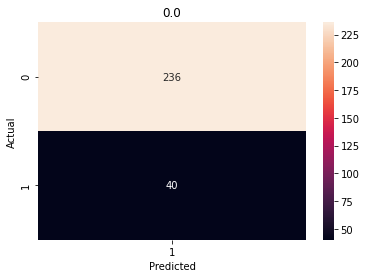

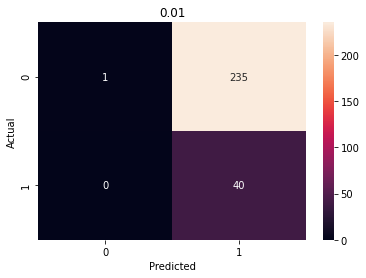

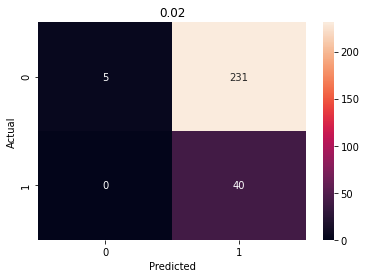

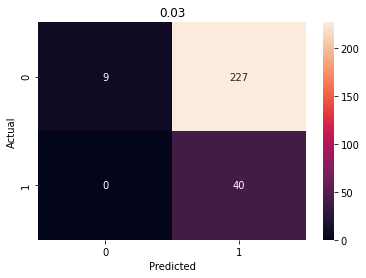

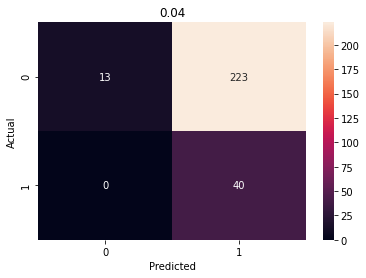

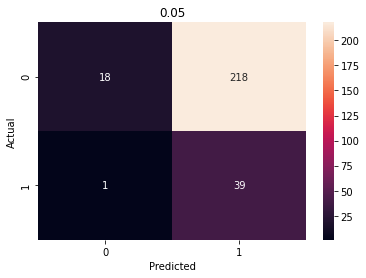

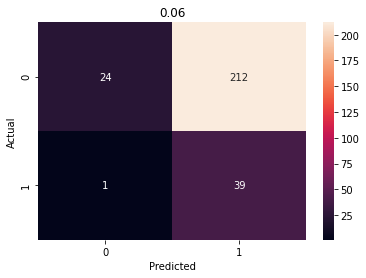

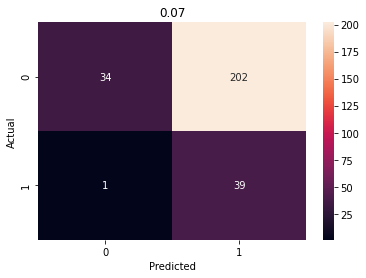

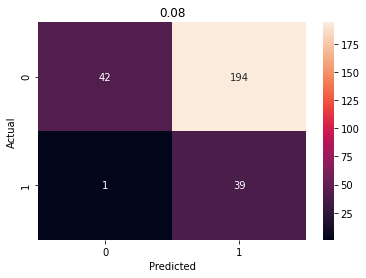

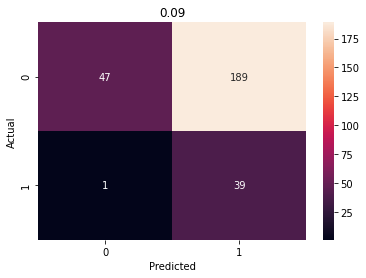

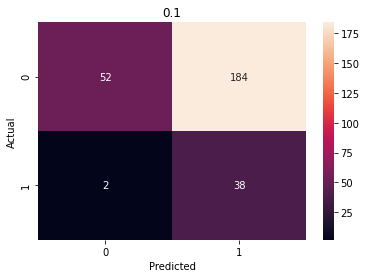

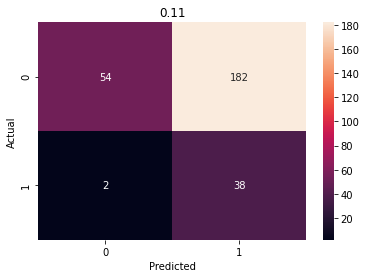

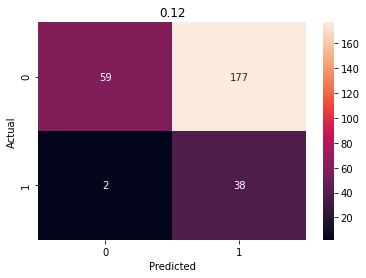

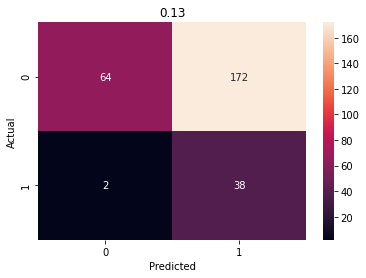

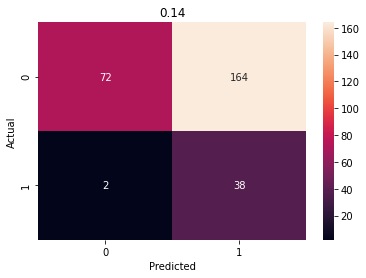

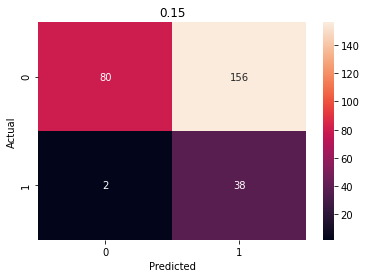

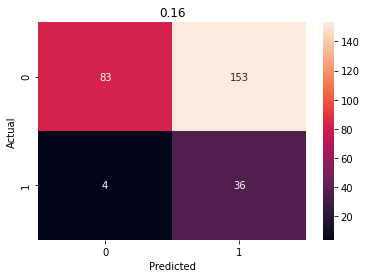

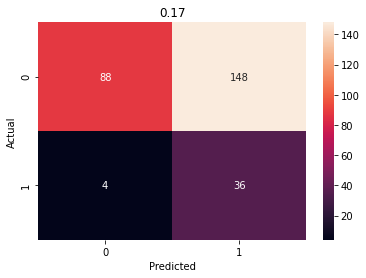

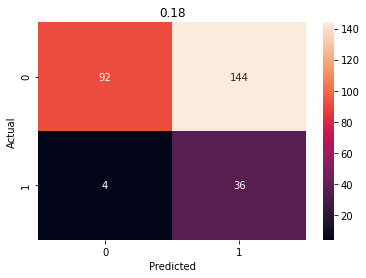

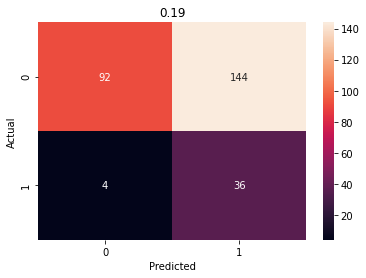

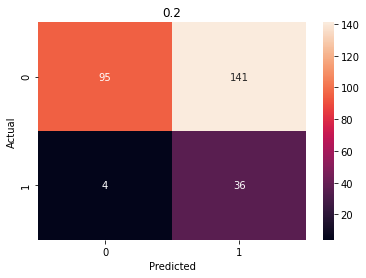

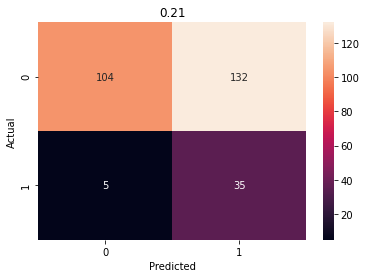

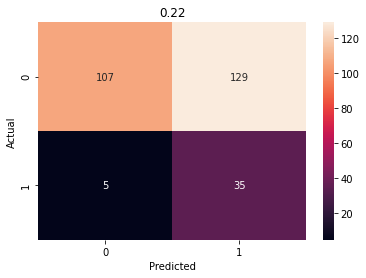

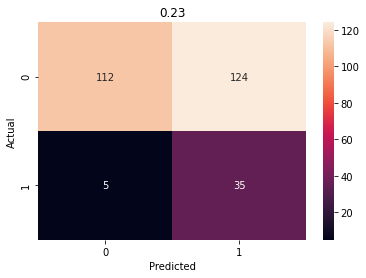

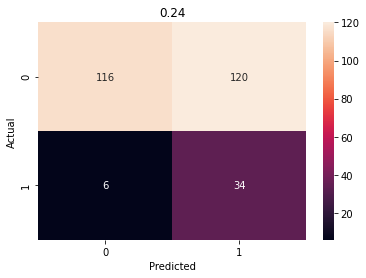

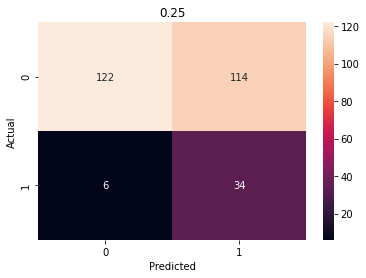

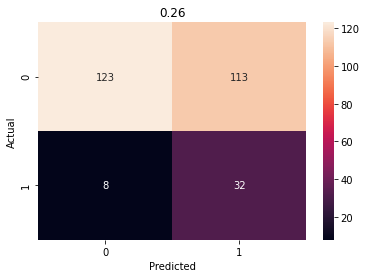

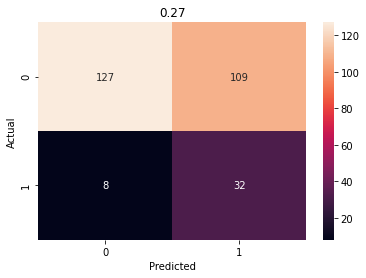

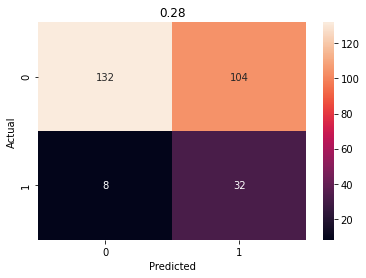

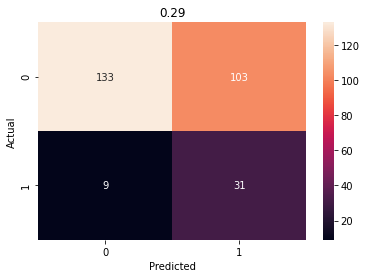

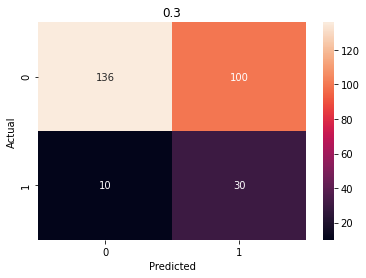

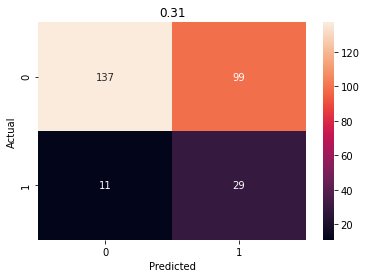

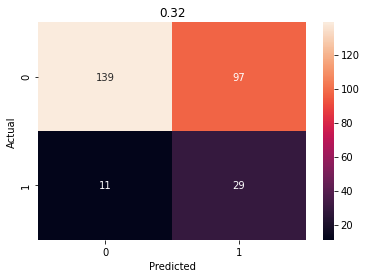

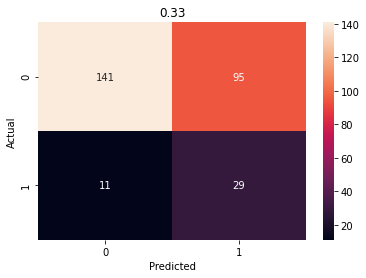

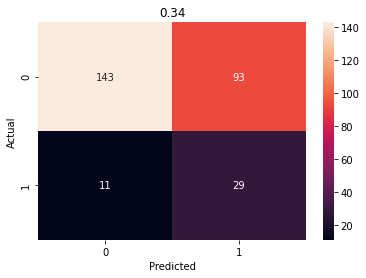

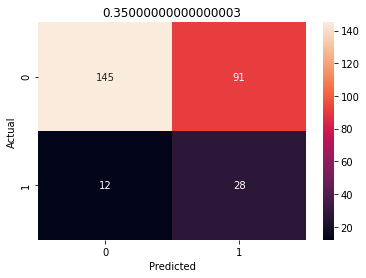

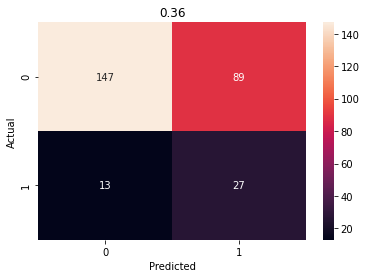

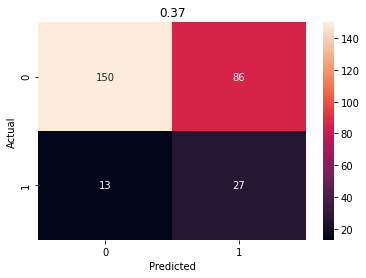

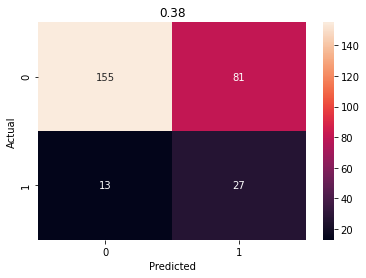

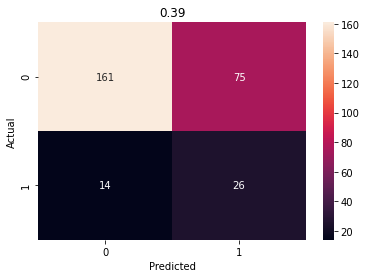

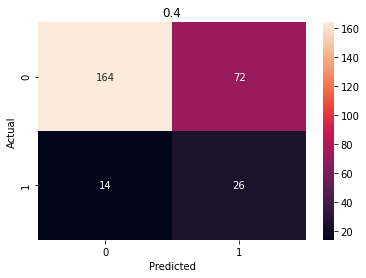

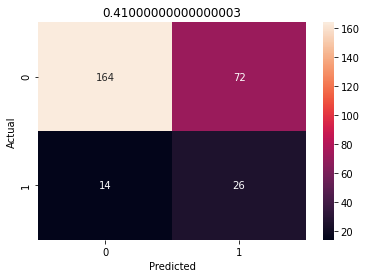

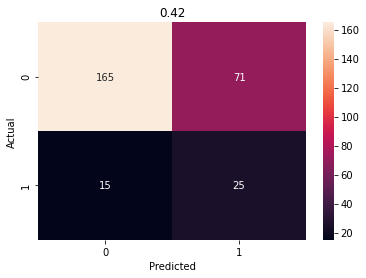

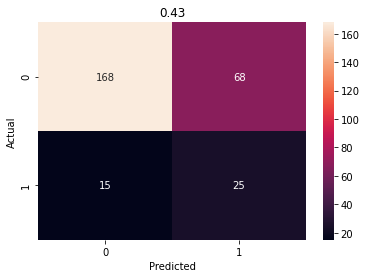

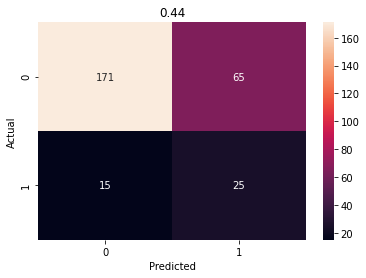

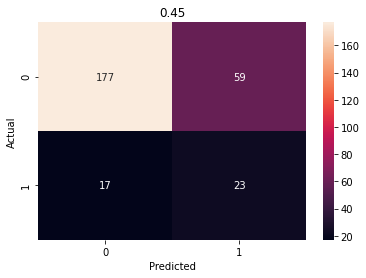

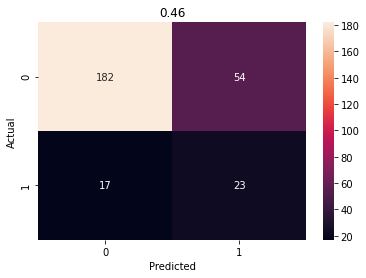

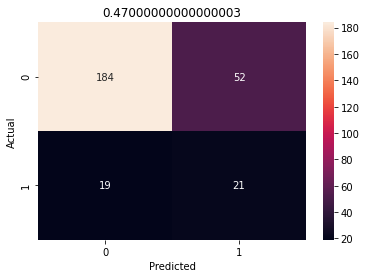

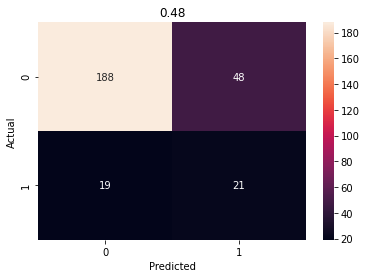

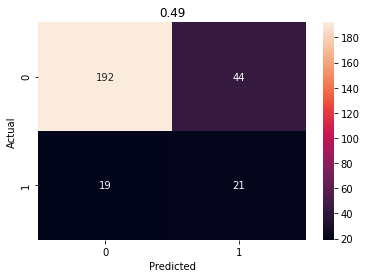

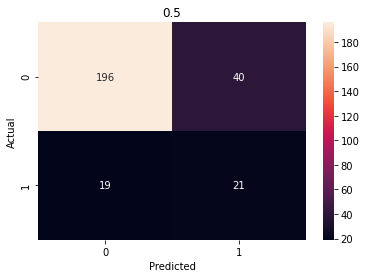

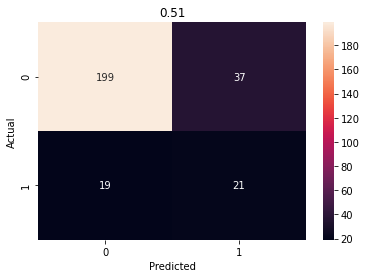

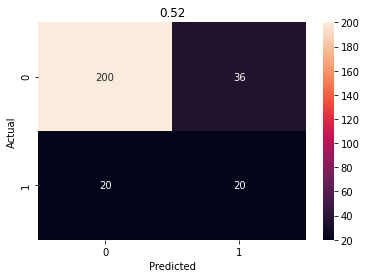

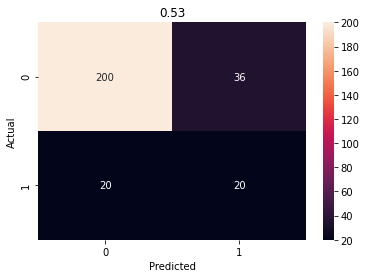

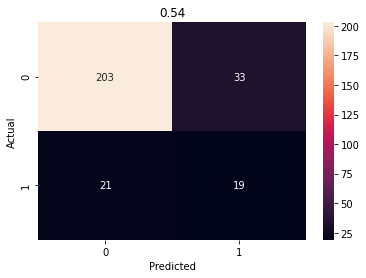

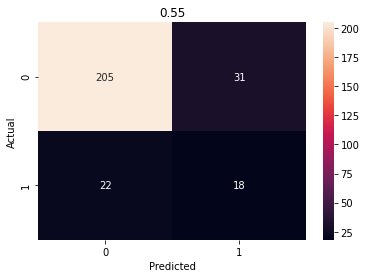

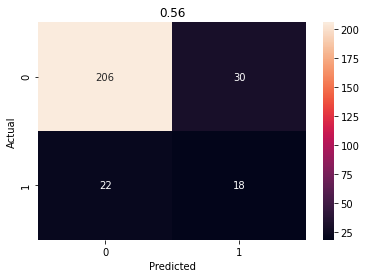

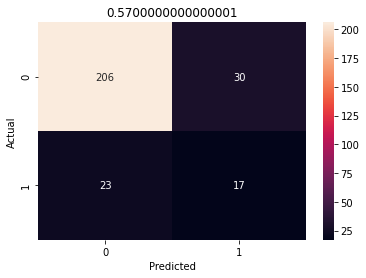

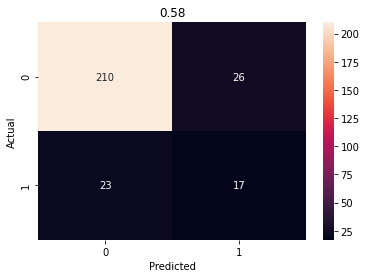

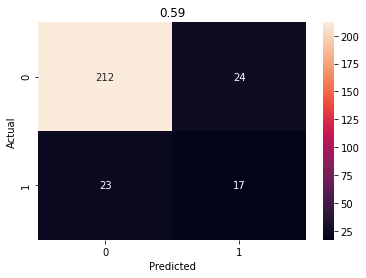

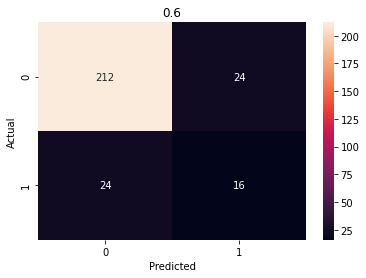

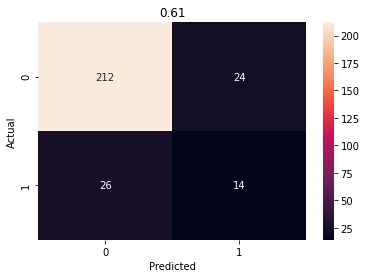

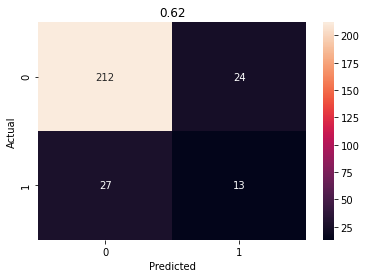

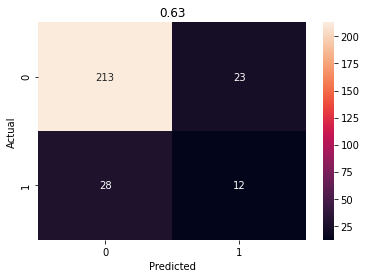

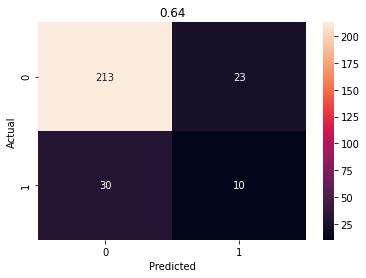

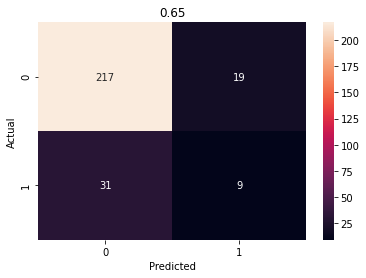

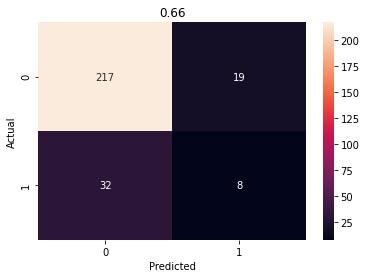

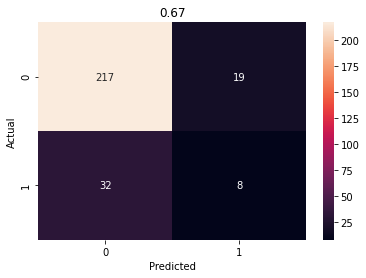

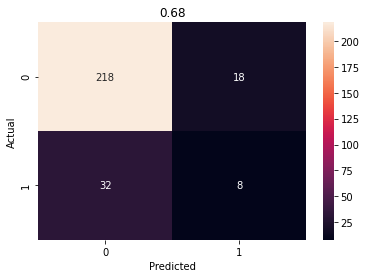

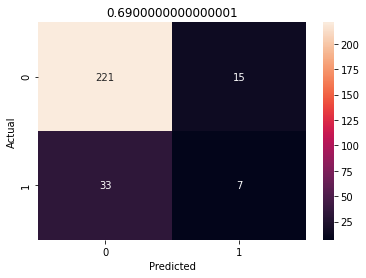

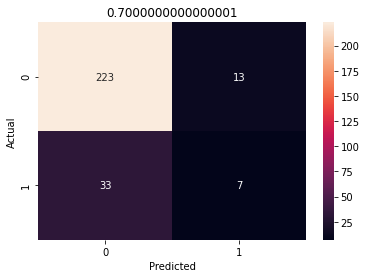

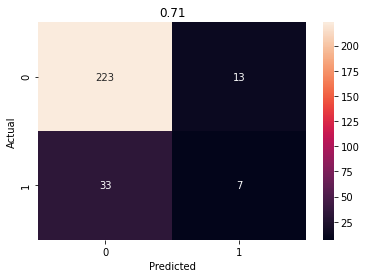

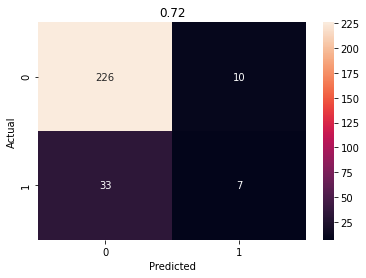

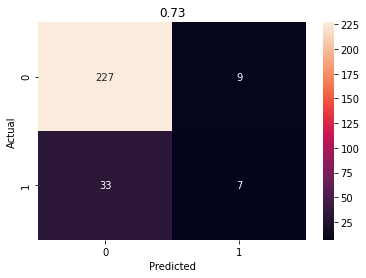

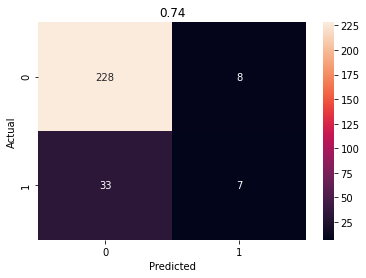

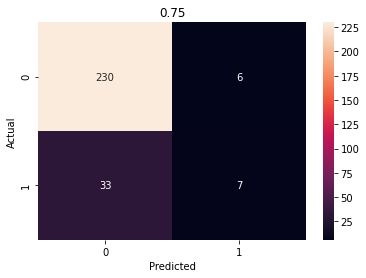

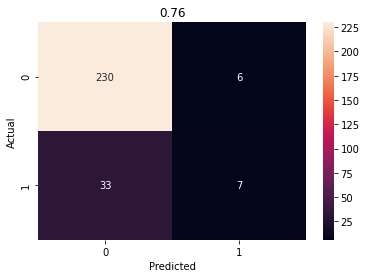

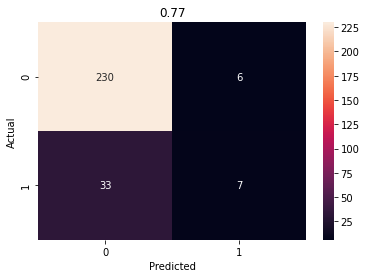

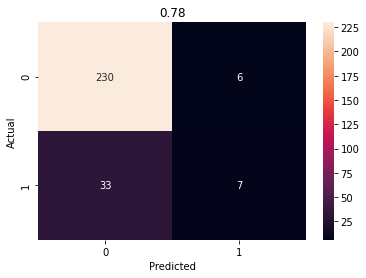

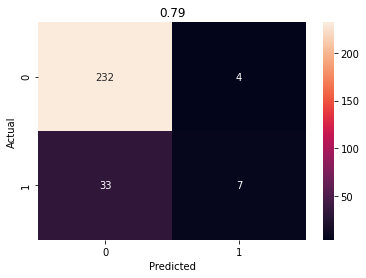

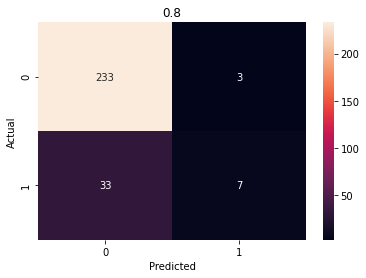

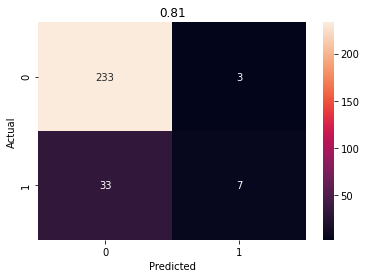

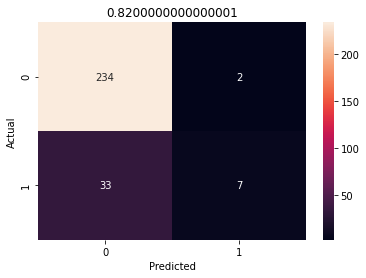

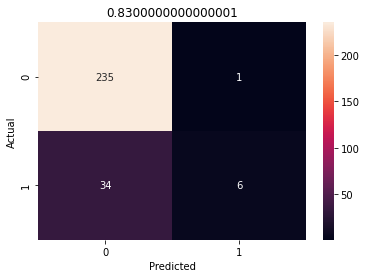

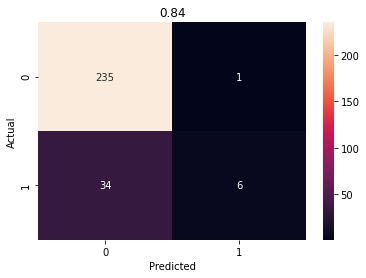

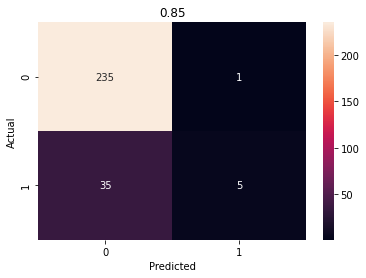

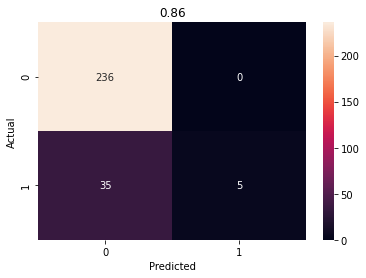

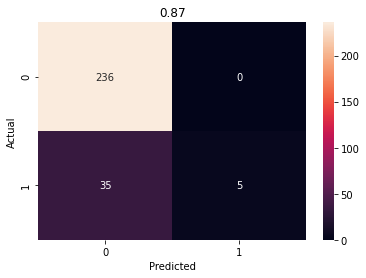

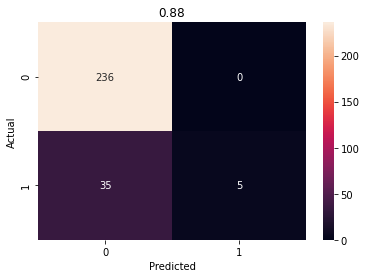

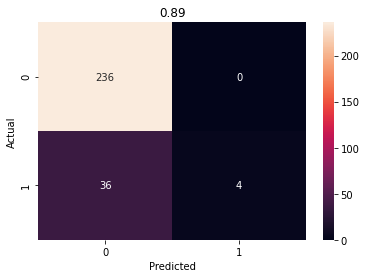

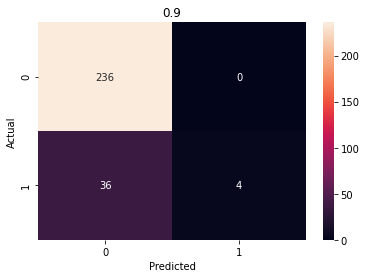

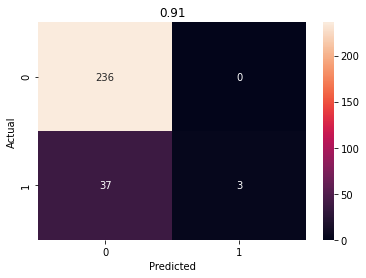

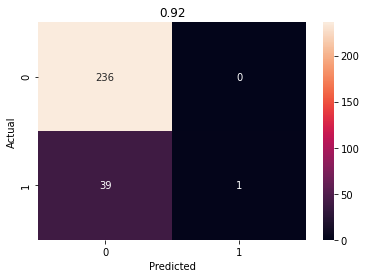

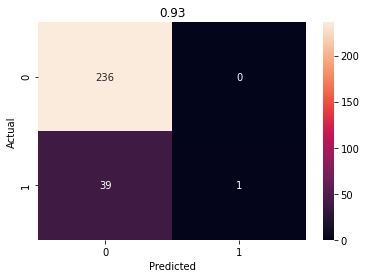

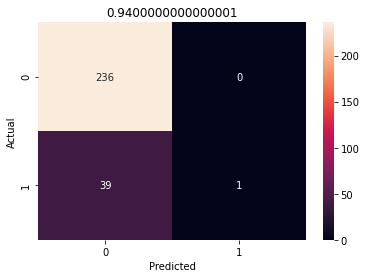

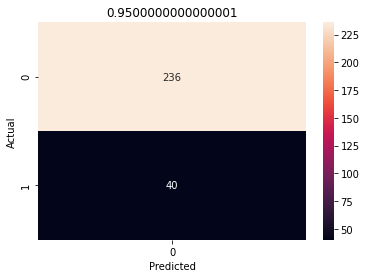

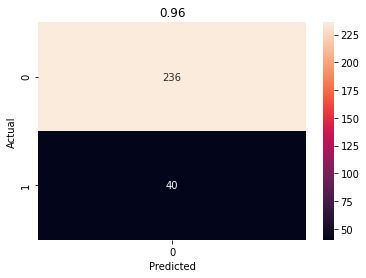

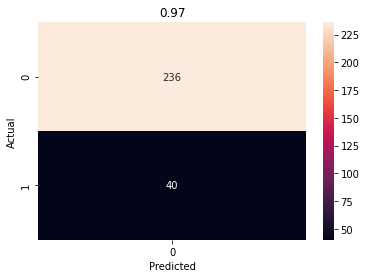

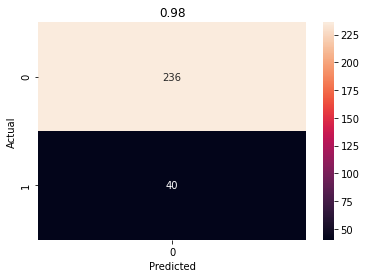

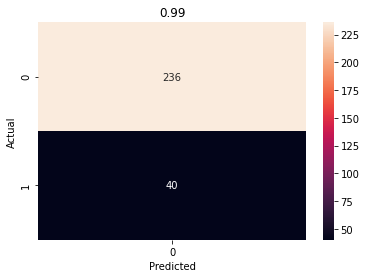

In [207]:
for threshold in np.arange(0,1,0.01):
    predicted_proba = rand_search_log_model.predict_proba(X_val)
    predicted = (predicted_proba[:, 1] >= threshold).astype('int')
#     print(threshold, '================================================== \n', 
#           classification_report(y_val, predicted)
    plt.title(threshold)
#     sns.heatmap(confusion_matrix(y_val, predicted), annot = True)
    data = {
    'y_true':  y_val,
    'y_pred': predicted
    }

    df = pd.DataFrame(data, columns=['y_true','y_pred'])
    
    confusion_matrix = pd.crosstab(df['y_true'], df['y_pred'], rownames=['Actual'], colnames=['Predicted'])
    sns.heatmap(confusion_matrix, annot = True, fmt = 'd')
    plt.show()
#     plt.xlabel('Predicted')
#     plt.ylabel('True')
#     plt.show()

### RandomForestClassifier

In [208]:
rf_model = RandomForestClassifier(random_state = 0)
rf_model.fit(X_train_smote, y_train_smote)

RandomForestClassifier(random_state=0)

In [209]:
y_pred_rf = rf_model.predict(X_val)

In [210]:
for threshold in np.arange(0,1,0.01):
    predicted_proba = rf_model.predict_proba(X_val)
    predicted = (predicted_proba[:, 1] >= threshold).astype('int')
    print(threshold, '================================================== \n', 
          classification_report(y_val, predicted))

0.0 ================================================== 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       236
           1       0.14      1.00      0.25        40

    accuracy                           0.14       276
   macro avg       0.07      0.50      0.13       276
weighted avg       0.02      0.14      0.04       276

0.01 ================================================== 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       236
           1       0.14      1.00      0.25        40

    accuracy                           0.14       276
   macro avg       0.07      0.50      0.13       276
weighted avg       0.02      0.14      0.04       276

0.02 ================================================== 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       236
           1       0.14      1.00      0.25        40

    accur

0.25 ================================================== 
               precision    recall  f1-score   support

           0       0.93      0.59      0.72       236
           1       0.23      0.72      0.35        40

    accuracy                           0.61       276
   macro avg       0.58      0.66      0.54       276
weighted avg       0.83      0.61      0.67       276

0.26 ================================================== 
               precision    recall  f1-score   support

           0       0.93      0.63      0.75       236
           1       0.24      0.70      0.36        40

    accuracy                           0.64       276
   macro avg       0.58      0.67      0.56       276
weighted avg       0.83      0.64      0.69       276

0.27 ================================================== 
               precision    recall  f1-score   support

           0       0.91      0.65      0.76       236
           1       0.23      0.62      0.34        40

    accu

0.49 ================================================== 
               precision    recall  f1-score   support

           0       0.88      0.94      0.91       236
           1       0.42      0.28      0.33        40

    accuracy                           0.84       276
   macro avg       0.65      0.61      0.62       276
weighted avg       0.82      0.84      0.83       276

0.5 ================================================== 
               precision    recall  f1-score   support

           0       0.88      0.94      0.91       236
           1       0.41      0.23      0.29        40

    accuracy                           0.84       276
   macro avg       0.64      0.58      0.60       276
weighted avg       0.81      0.84      0.82       276

0.51 ================================================== 
               precision    recall  f1-score   support

           0       0.88      0.96      0.92       236
           1       0.47      0.23      0.31        40

    accur

0.73 ================================================== 
               precision    recall  f1-score   support

           0       0.86      0.99      0.92       236
           1       0.60      0.07      0.13        40

    accuracy                           0.86       276
   macro avg       0.73      0.53      0.53       276
weighted avg       0.83      0.86      0.81       276

0.74 ================================================== 
               precision    recall  f1-score   support

           0       0.86      0.99      0.92       236
           1       0.60      0.07      0.13        40

    accuracy                           0.86       276
   macro avg       0.73      0.53      0.53       276
weighted avg       0.83      0.86      0.81       276

0.75 ================================================== 
               precision    recall  f1-score   support

           0       0.86      0.99      0.92       236
           1       0.60      0.07      0.13        40

    accu

0.97 ================================================== 
               precision    recall  f1-score   support

           0       0.86      1.00      0.92       236
           1       1.00      0.03      0.05        40

    accuracy                           0.86       276
   macro avg       0.93      0.51      0.49       276
weighted avg       0.88      0.86      0.80       276

0.98 ================================================== 
               precision    recall  f1-score   support

           0       0.86      1.00      0.92       236
           1       1.00      0.03      0.05        40

    accuracy                           0.86       276
   macro avg       0.93      0.51      0.49       276
weighted avg       0.88      0.86      0.80       276

0.99 ================================================== 
               precision    recall  f1-score   support

           0       0.86      1.00      0.92       236
           1       0.00      0.00      0.00        40

    accu

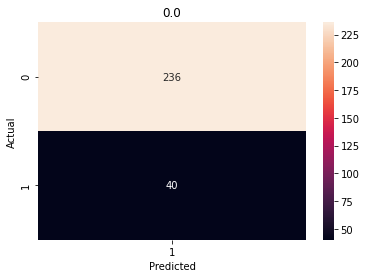

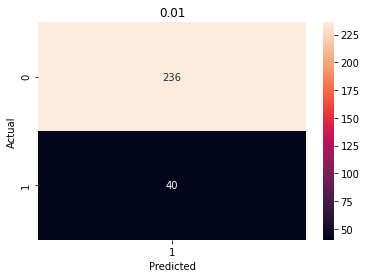

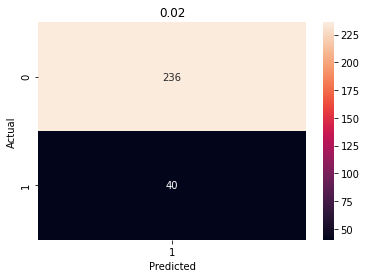

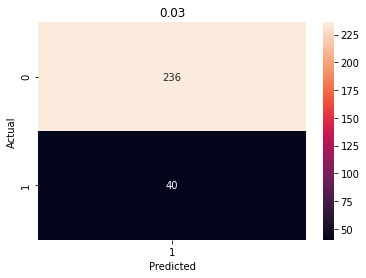

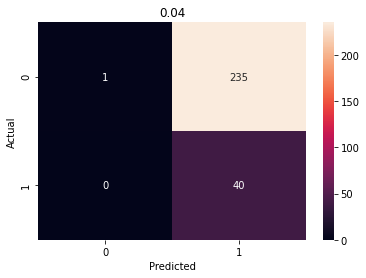

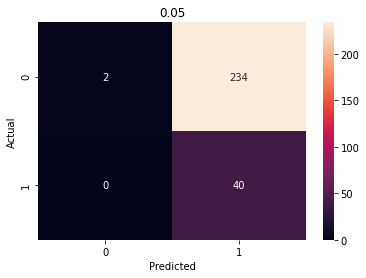

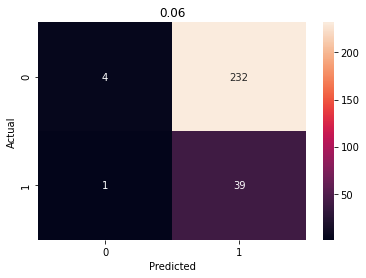

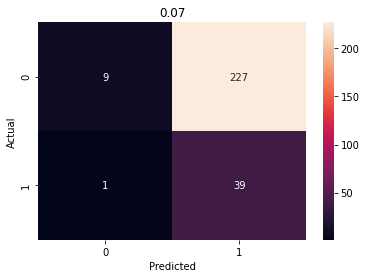

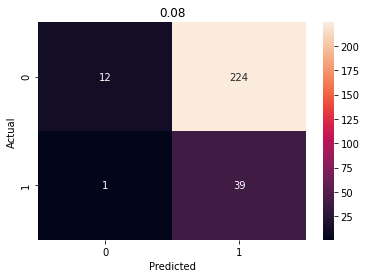

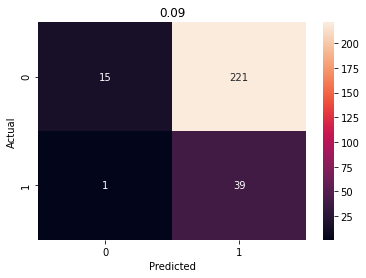

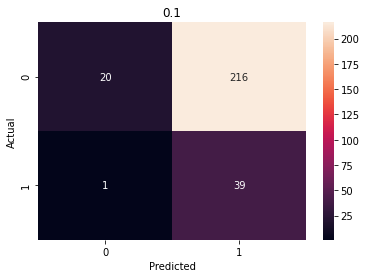

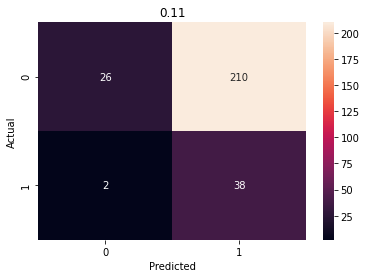

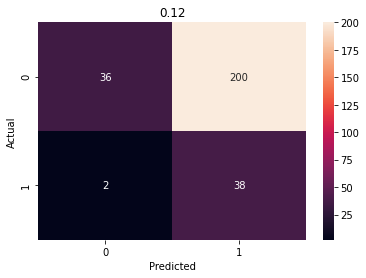

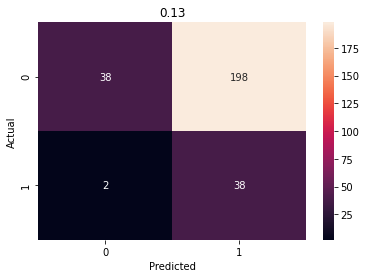

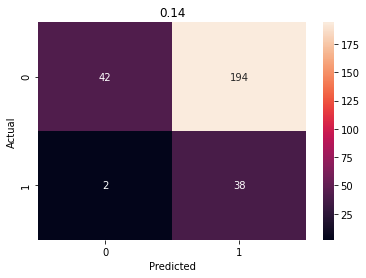

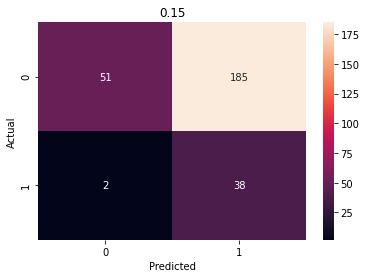

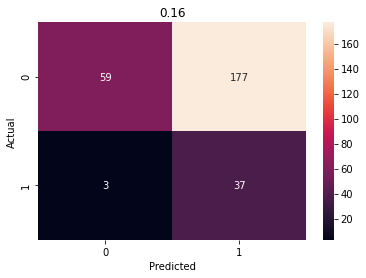

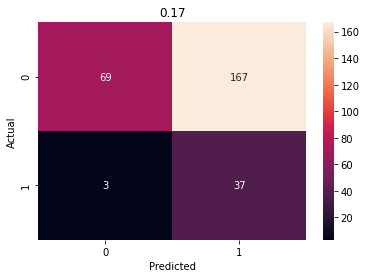

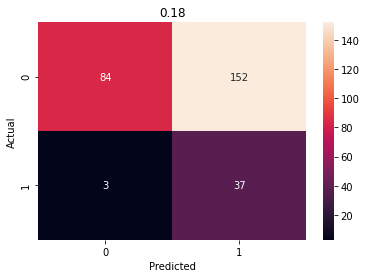

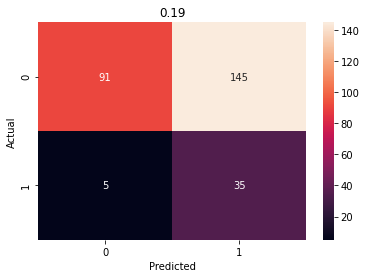

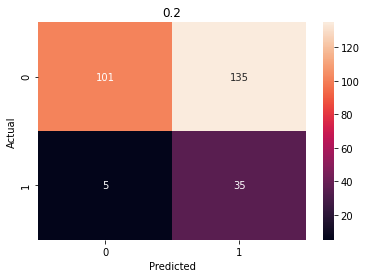

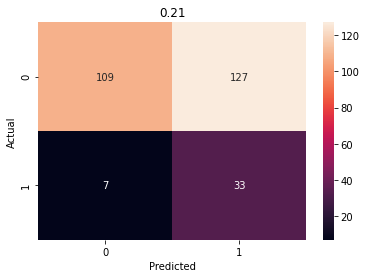

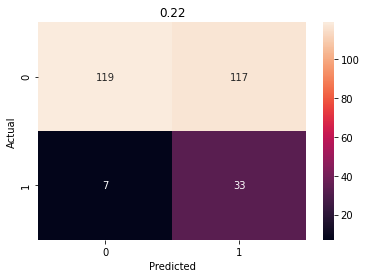

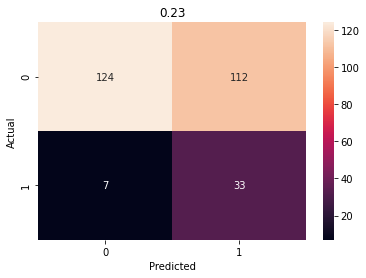

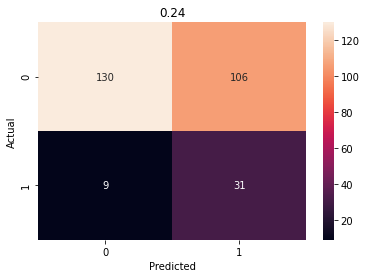

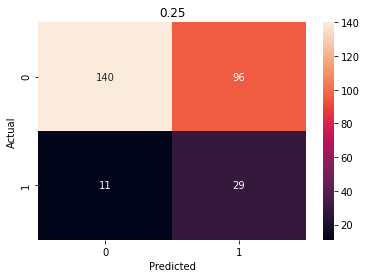

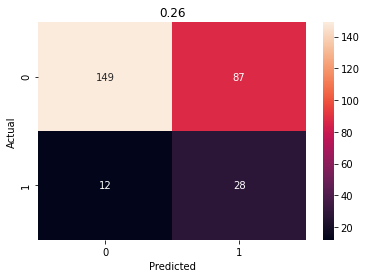

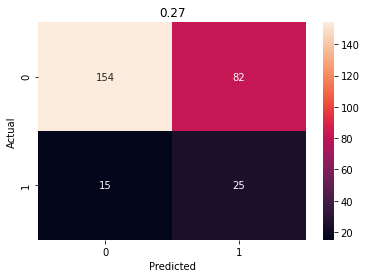

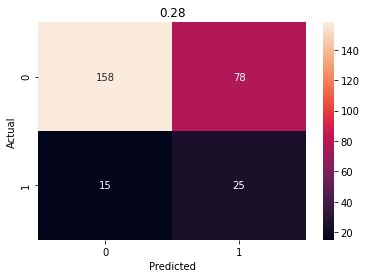

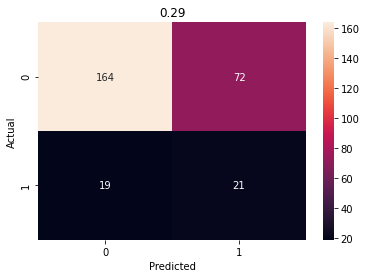

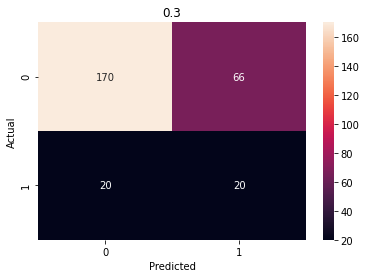

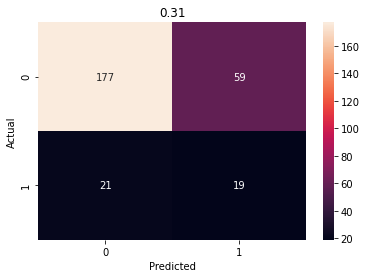

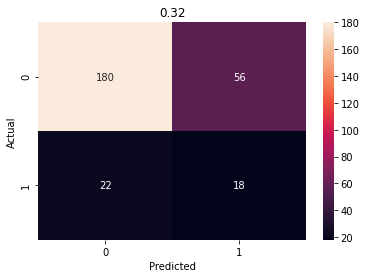

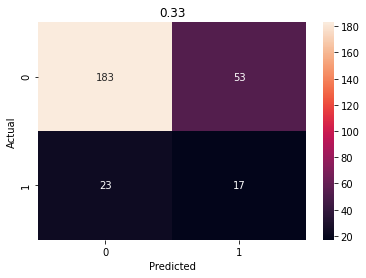

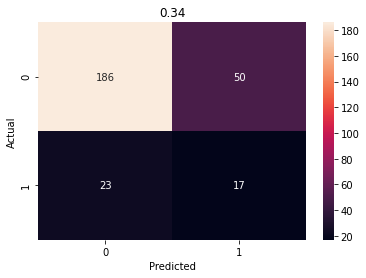

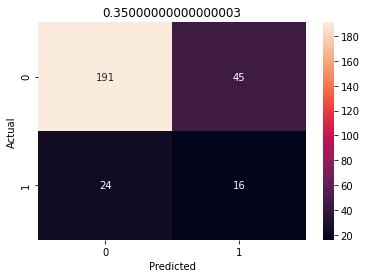

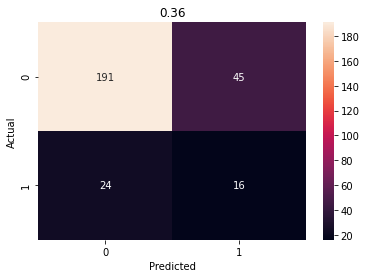

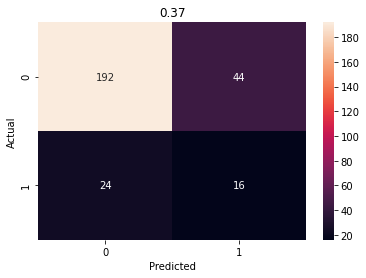

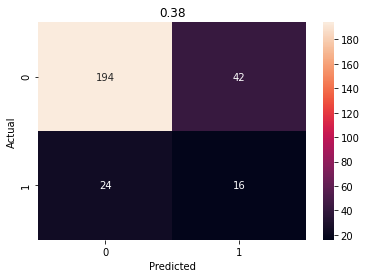

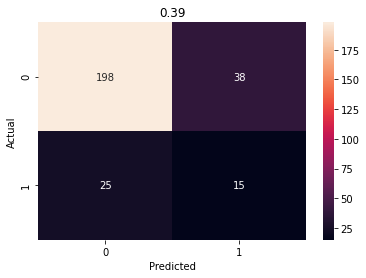

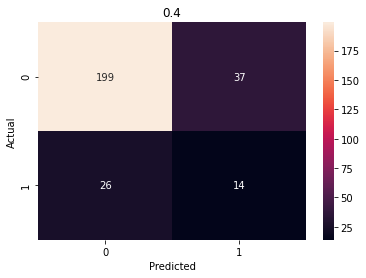

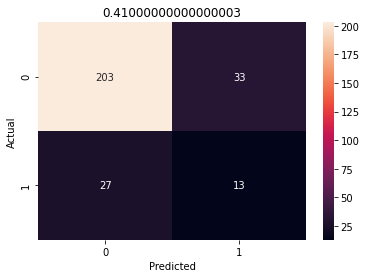

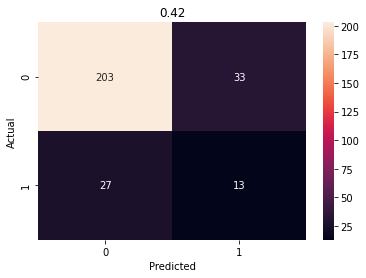

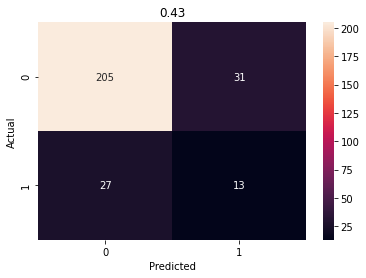

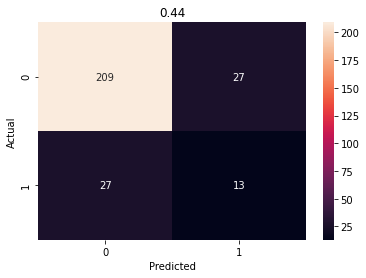

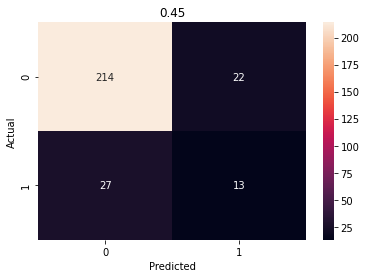

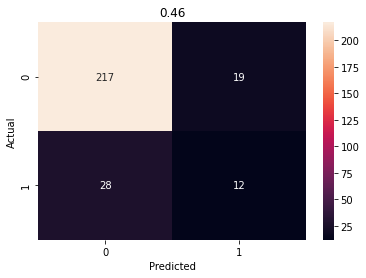

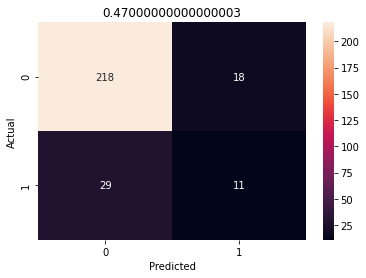

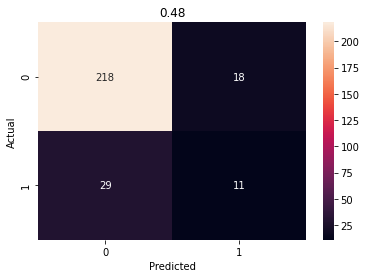

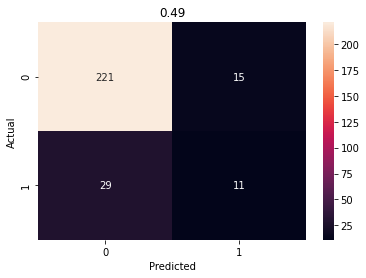

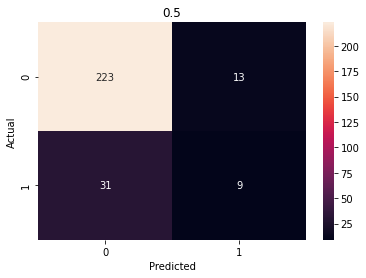

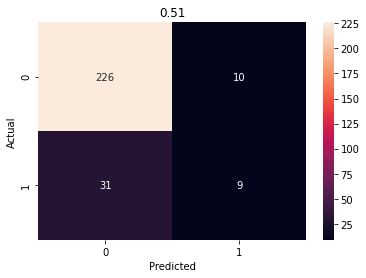

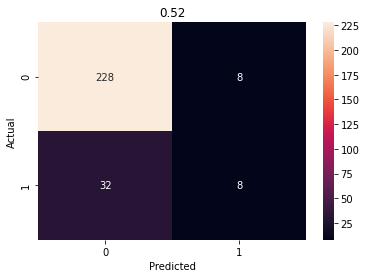

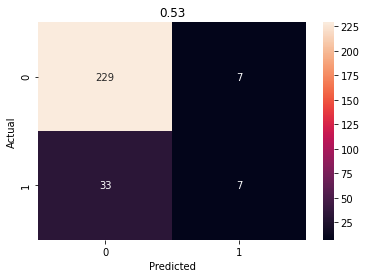

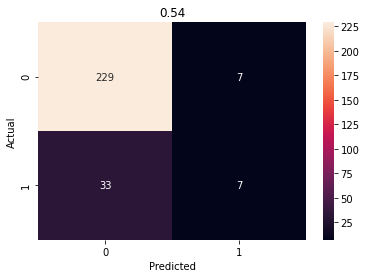

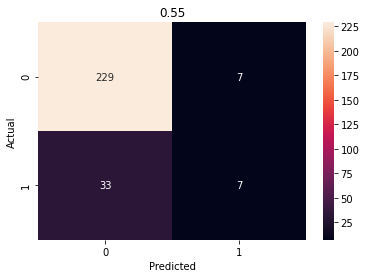

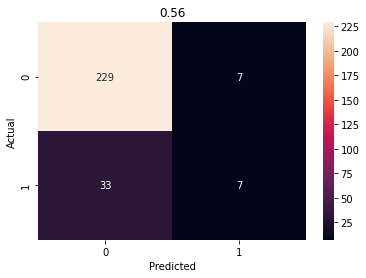

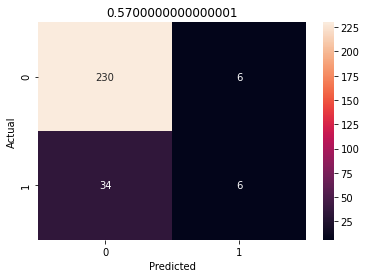

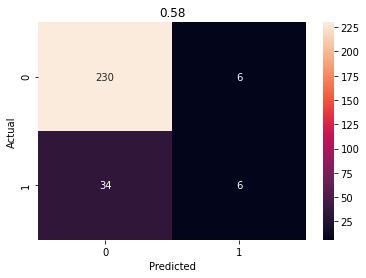

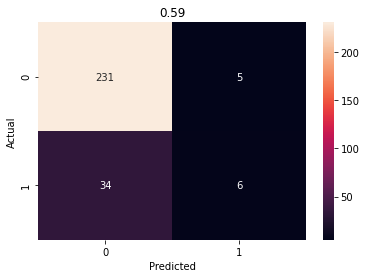

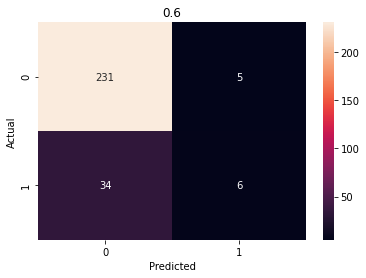

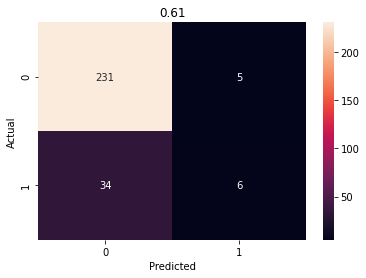

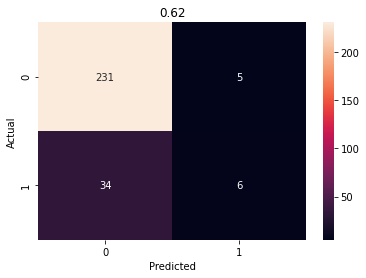

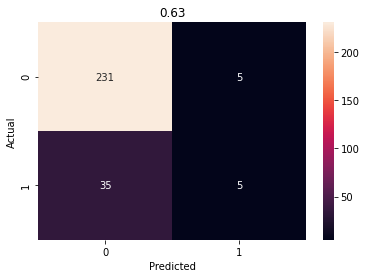

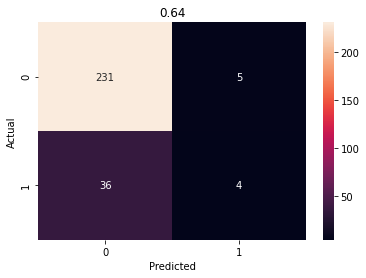

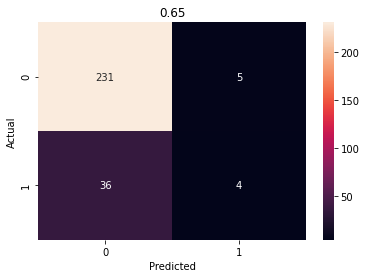

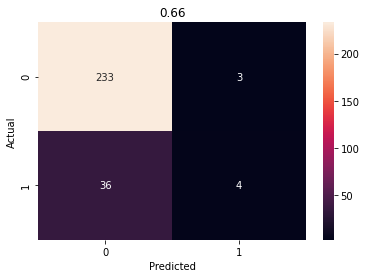

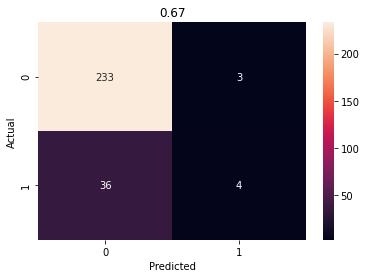

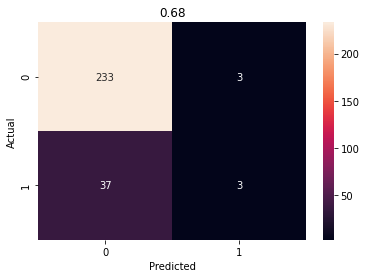

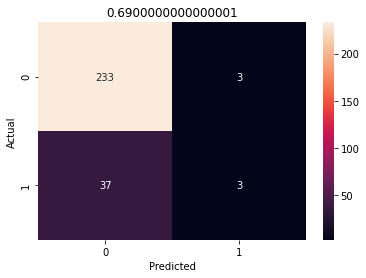

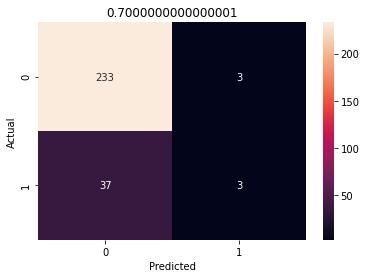

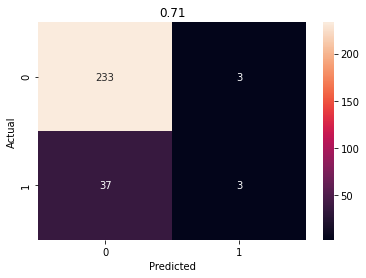

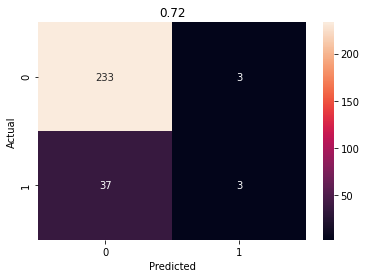

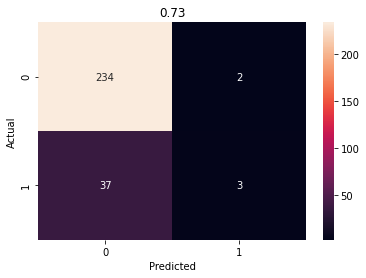

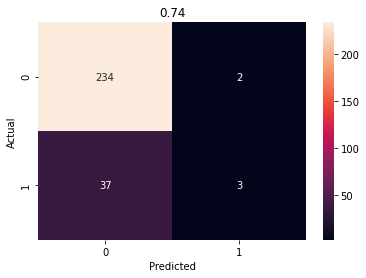

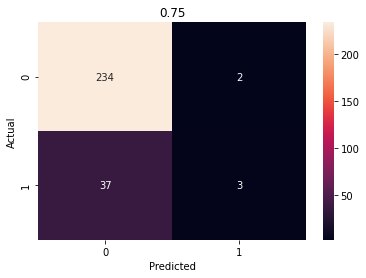

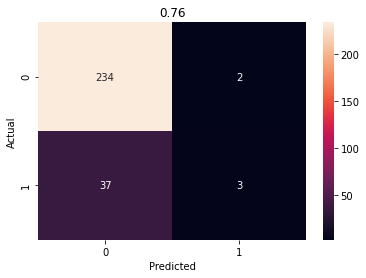

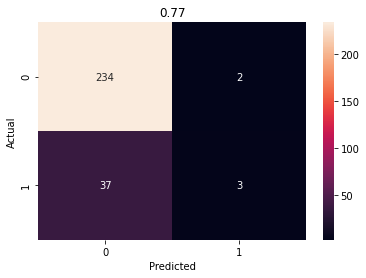

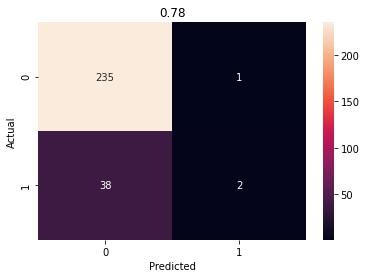

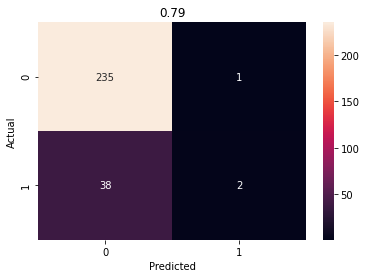

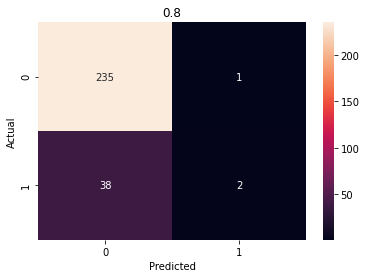

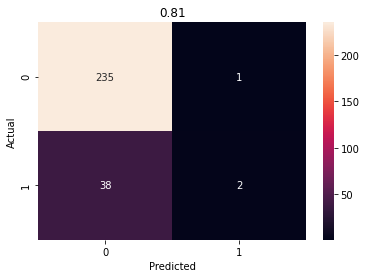

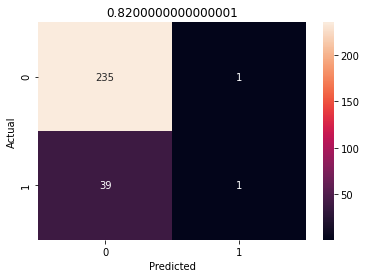

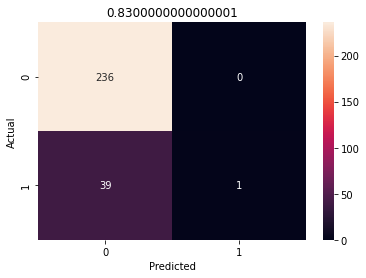

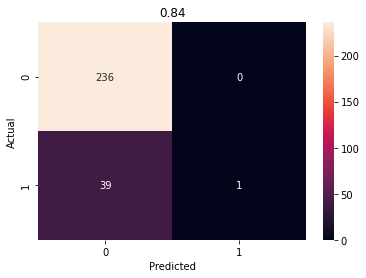

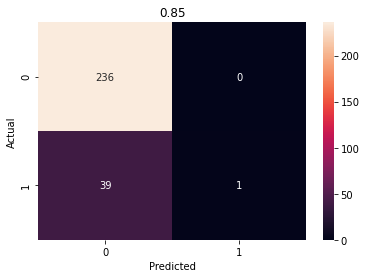

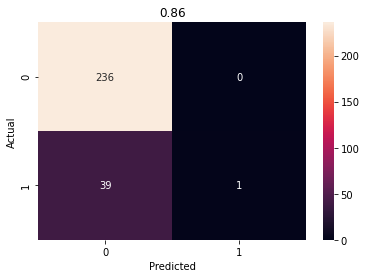

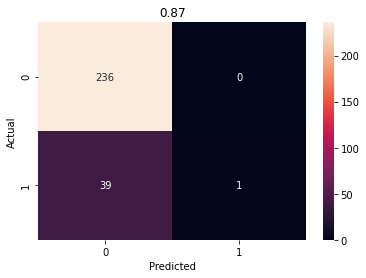

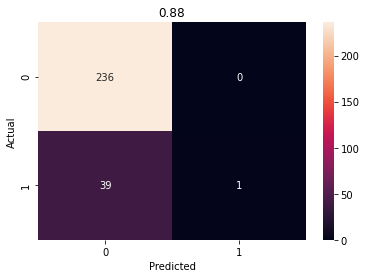

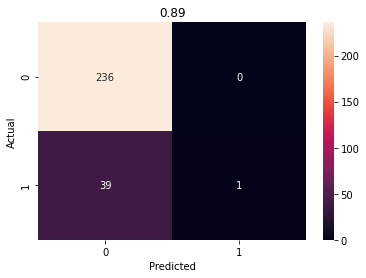

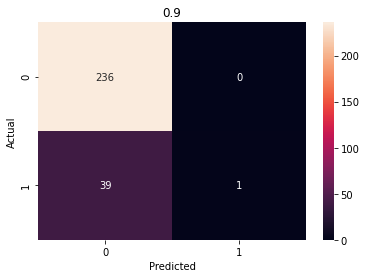

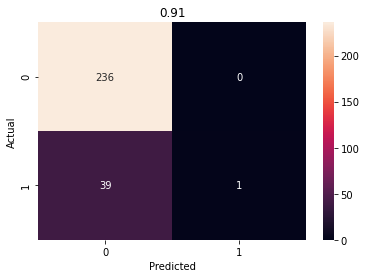

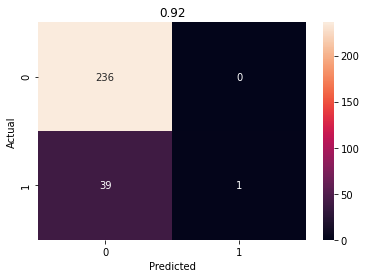

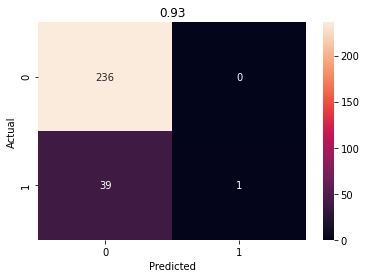

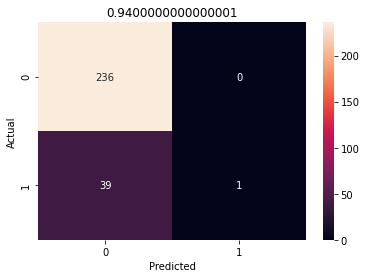

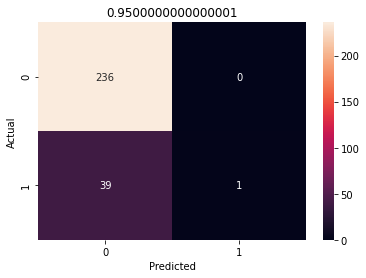

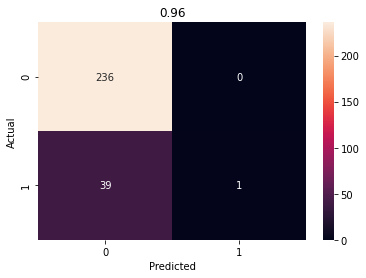

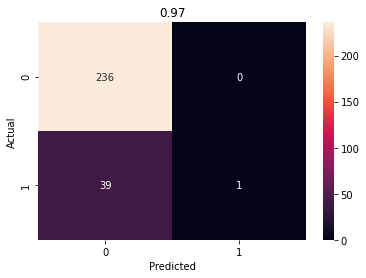

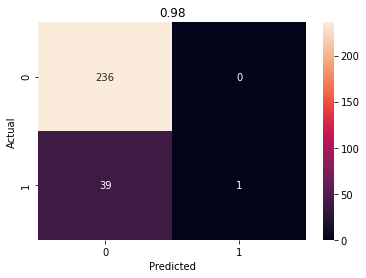

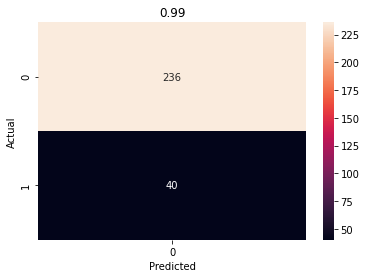

In [211]:
for threshold in np.arange(0,1,0.01):
    predicted_proba = rf_model.predict_proba(X_val)
    predicted = (predicted_proba[:, 1] >= threshold).astype('int')
    plt.title(threshold)
    data = {
    'y_true':  y_val,
    'y_pred': predicted
    }

    df = pd.DataFrame(data, columns=['y_true','y_pred'])
    
    confusion_matrix = pd.crosstab(df['y_true'], df['y_pred'], rownames=['Actual'], colnames=['Predicted'])
    sns.heatmap(confusion_matrix, annot = True, fmt = 'd')
    plt.show()

In [212]:
rf_params = {
#     'n_estimators': np.random.randint(100, 150),
    'criterion': ["gini", "entropy"],
    'max_features': ["auto", "sqrt", "log2"],
#     'max_leaf_nodes': np.random.randint(1, 100),
    'min_impurity_decrease': loguniform(0.01, 1),
    'bootstrap': [True, False],
    'ccp_alpha': loguniform(0.01, 1),
    'max_samples': loguniform(0.5, .75)
}

rand_rf_model = RandomizedSearchCV(rf_model, param_distributions = rf_params, n_iter = 100,
                                   cv = 10, scoring = ['recall', 'f1'], refit = 'f1',
                                   verbose = 1, n_jobs = -1)

In [213]:
rand_rf_model.fit(X_train_smote, y_train_smote)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   13.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   30.0s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:   54.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  1.1min finished


RandomizedSearchCV(cv=10, estimator=RandomForestClassifier(random_state=0),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'ccp_alpha': <scipy.stats._distn_infrastructure.rv_frozen object at 0x14adc80d0>,
                                        'criterion': ['gini', 'entropy'],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'max_samples': <scipy.stats._distn_infrastructure.rv_frozen object at 0x14adc8290>,
                                        'min_impurity_decrease': <scipy.stats._distn_infrastructure.rv_frozen object at 0x14b881a50>},
                   refit='f1', scoring=['recall', 'f1'], verbose=1)

In [214]:
rand_rf_model.best_params_

{'bootstrap': True,
 'ccp_alpha': 0.015126108639270283,
 'criterion': 'entropy',
 'max_features': 'auto',
 'max_samples': 0.6740198884275629,
 'min_impurity_decrease': 0.0197237923731223}

In [215]:
y_pred_rf_model = rand_rf_model.predict(X_val)

In [216]:
for threshold in np.arange(0,1,0.01):
    predicted_proba = rand_rf_model.predict_proba(X_val)
    predicted = (predicted_proba[:, 1] >= threshold).astype('int')
    print(threshold, '================================================== \n', 
          classification_report(y_val, predicted))

0.0 ================================================== 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       236
           1       0.14      1.00      0.25        40

    accuracy                           0.14       276
   macro avg       0.07      0.50      0.13       276
weighted avg       0.02      0.14      0.04       276

0.01 ================================================== 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       236
           1       0.14      1.00      0.25        40

    accuracy                           0.14       276
   macro avg       0.07      0.50      0.13       276
weighted avg       0.02      0.14      0.04       276

0.02 ================================================== 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       236
           1       0.14      1.00      0.25        40

    accur

0.25 ================================================== 
               precision    recall  f1-score   support

           0       1.00      0.03      0.05       236
           1       0.15      1.00      0.26        40

    accuracy                           0.17       276
   macro avg       0.57      0.51      0.15       276
weighted avg       0.88      0.17      0.08       276

0.26 ================================================== 
               precision    recall  f1-score   support

           0       1.00      0.04      0.08       236
           1       0.15      1.00      0.26        40

    accuracy                           0.18       276
   macro avg       0.58      0.52      0.17       276
weighted avg       0.88      0.18      0.11       276

0.27 ================================================== 
               precision    recall  f1-score   support

           0       0.95      0.08      0.14       236
           1       0.15      0.97      0.26        40

    accu

0.5 ================================================== 
               precision    recall  f1-score   support

           0       0.88      0.83      0.86       236
           1       0.26      0.35      0.30        40

    accuracy                           0.76       276
   macro avg       0.57      0.59      0.58       276
weighted avg       0.79      0.76      0.78       276

0.51 ================================================== 
               precision    recall  f1-score   support

           0       0.88      0.85      0.87       236
           1       0.27      0.33      0.30        40

    accuracy                           0.78       276
   macro avg       0.58      0.59      0.58       276
weighted avg       0.79      0.78      0.78       276

0.52 ================================================== 
               precision    recall  f1-score   support

           0       0.88      0.89      0.88       236
           1       0.31      0.30      0.30        40

    accur

0.76 ================================================== 
               precision    recall  f1-score   support

           0       0.86      1.00      0.92       236
           1       0.00      0.00      0.00        40

    accuracy                           0.86       276
   macro avg       0.43      0.50      0.46       276
weighted avg       0.73      0.86      0.79       276

0.77 ================================================== 
               precision    recall  f1-score   support

           0       0.86      1.00      0.92       236
           1       0.00      0.00      0.00        40

    accuracy                           0.86       276
   macro avg       0.43      0.50      0.46       276
weighted avg       0.73      0.86      0.79       276

0.78 ================================================== 
               precision    recall  f1-score   support

           0       0.86      1.00      0.92       236
           1       0.00      0.00      0.00        40

    accu

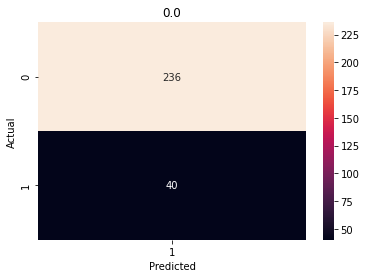

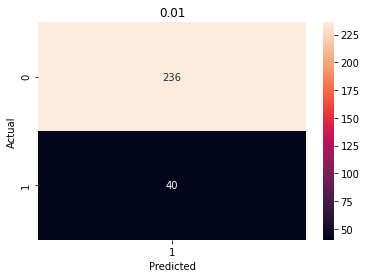

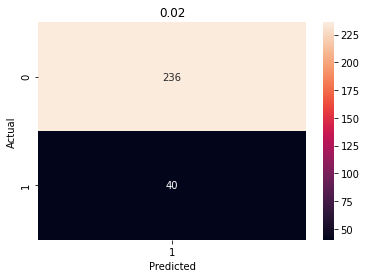

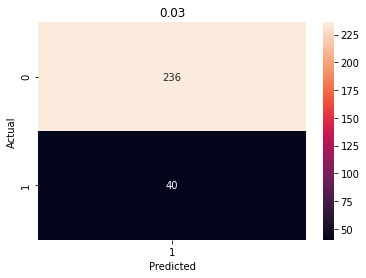

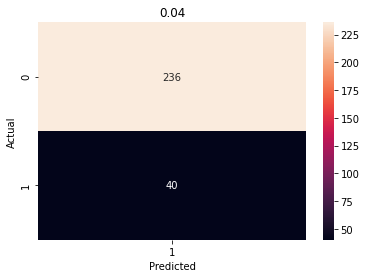

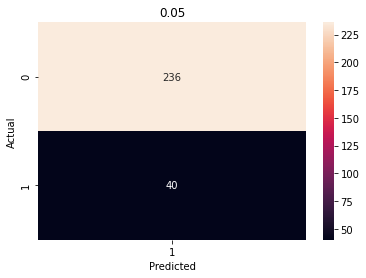

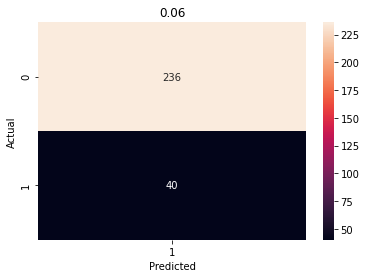

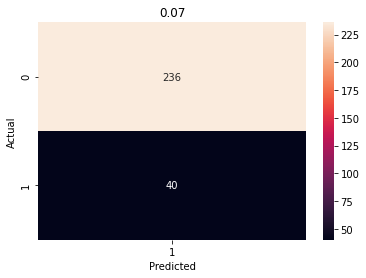

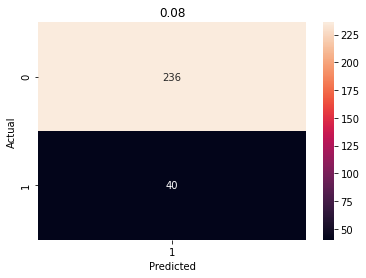

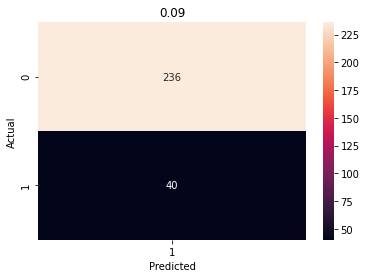

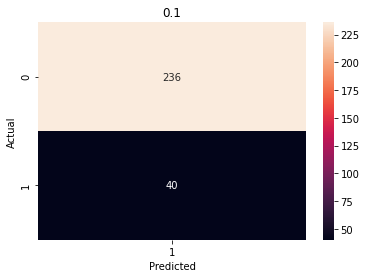

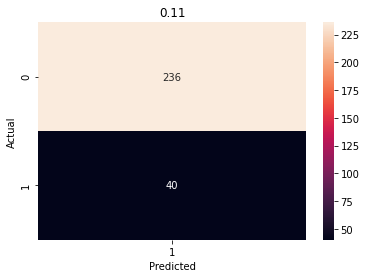

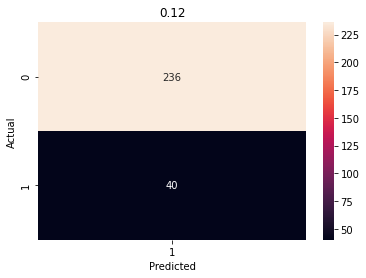

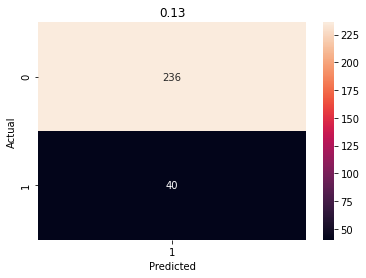

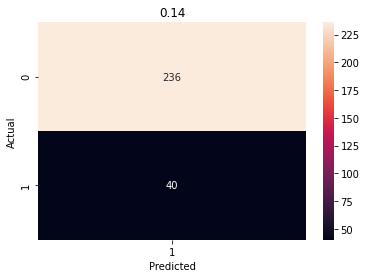

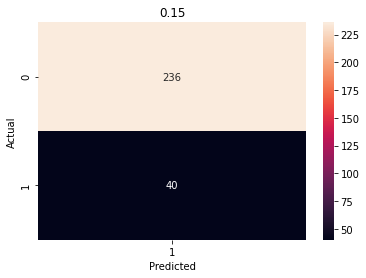

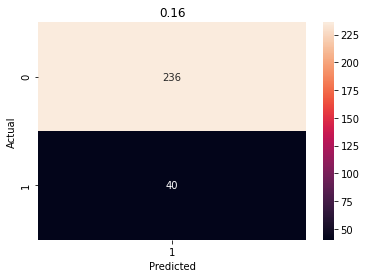

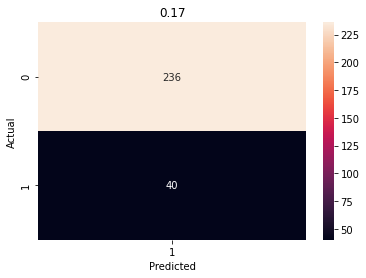

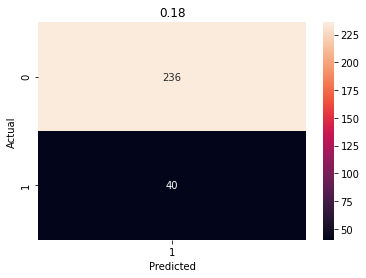

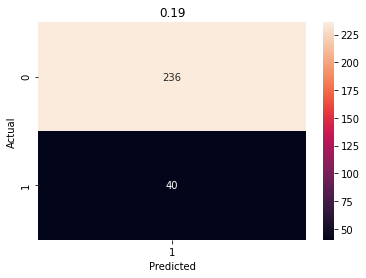

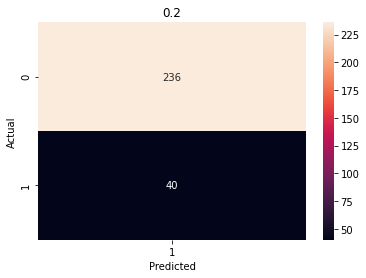

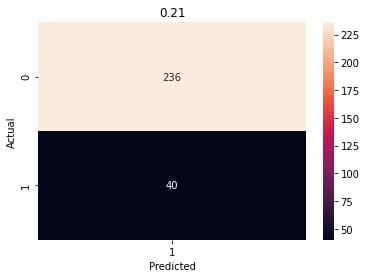

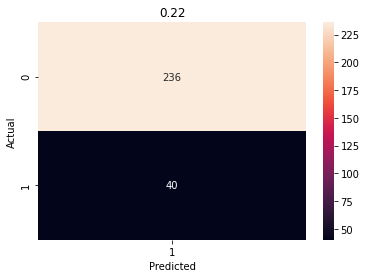

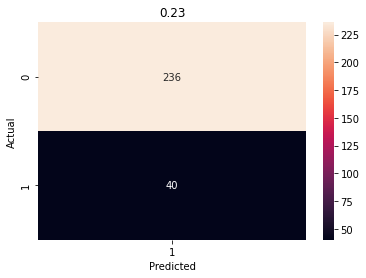

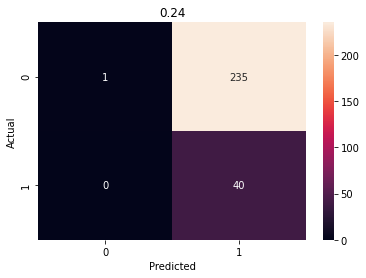

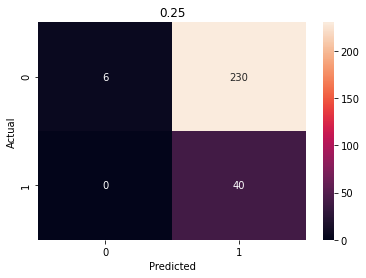

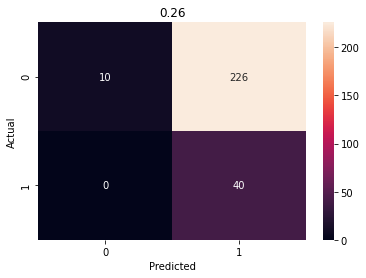

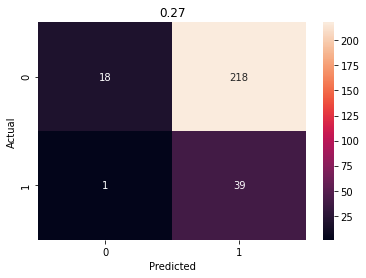

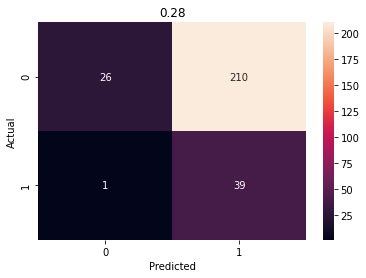

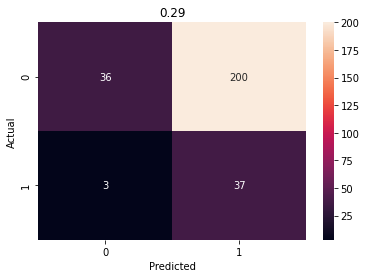

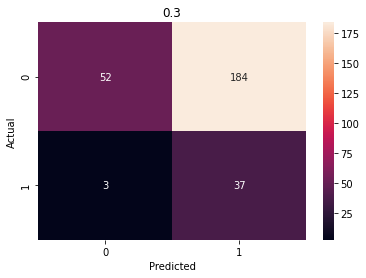

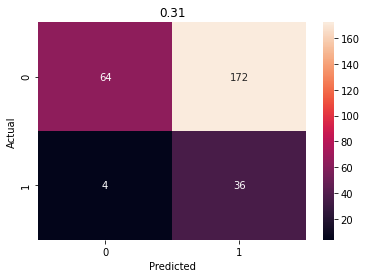

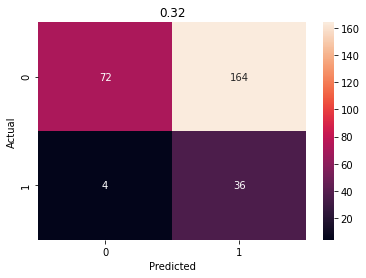

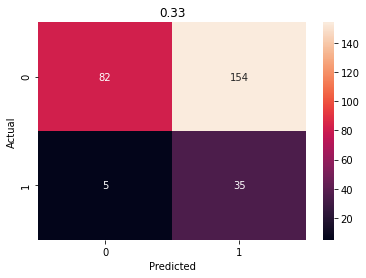

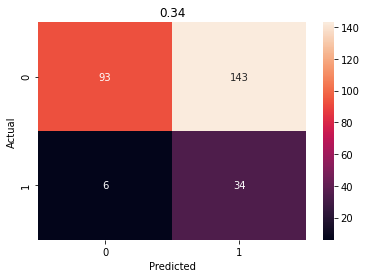

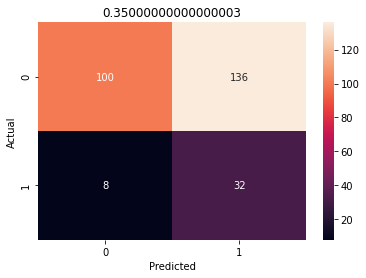

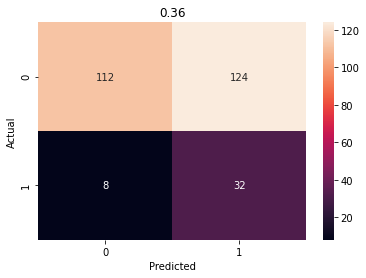

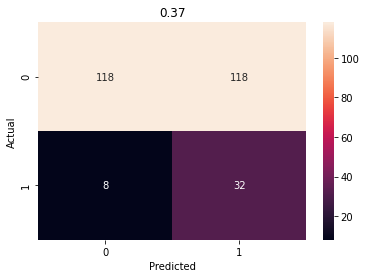

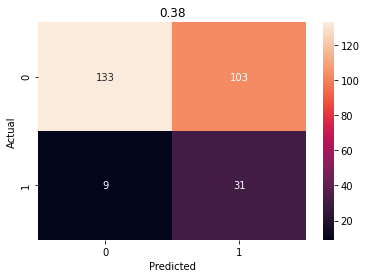

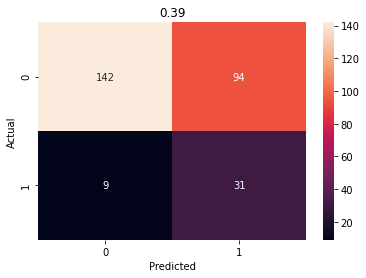

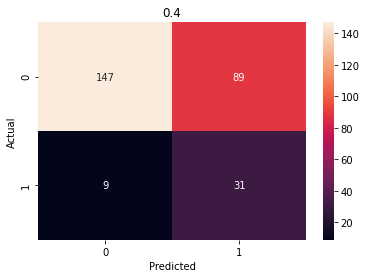

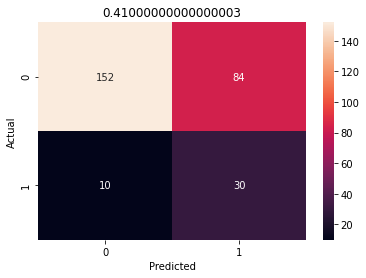

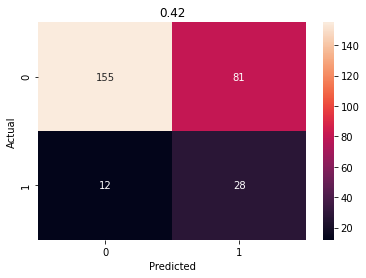

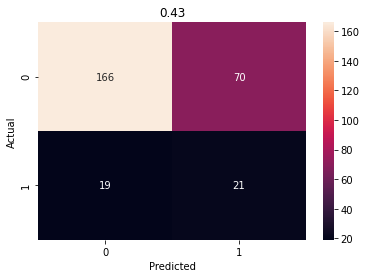

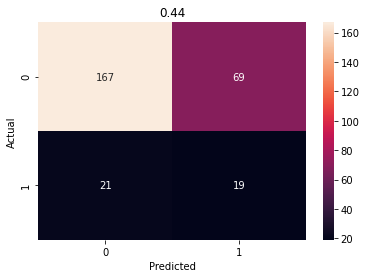

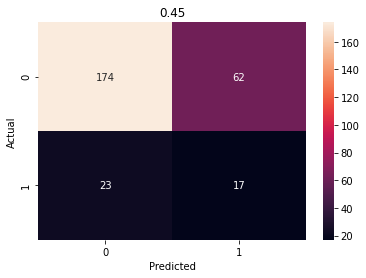

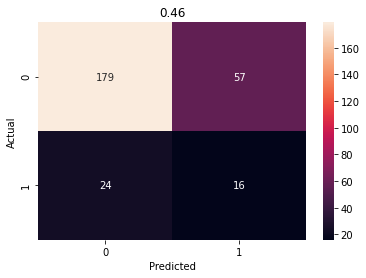

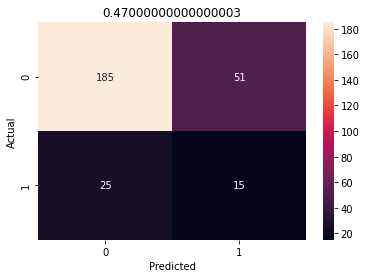

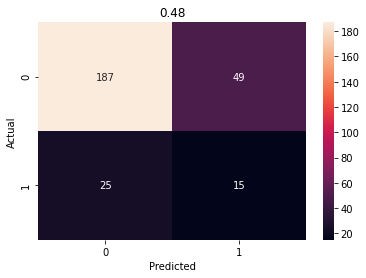

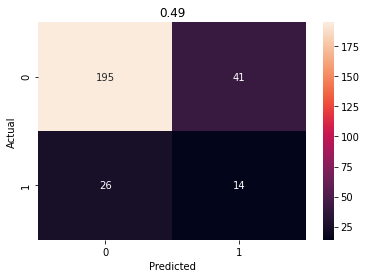

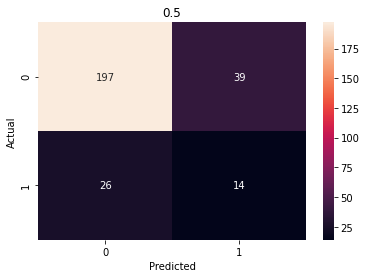

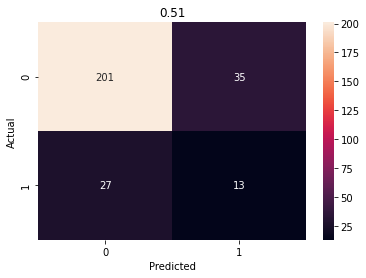

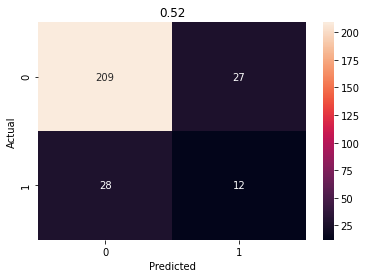

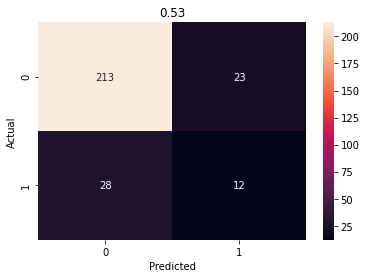

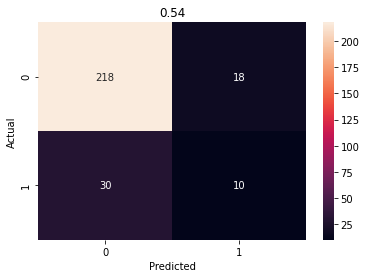

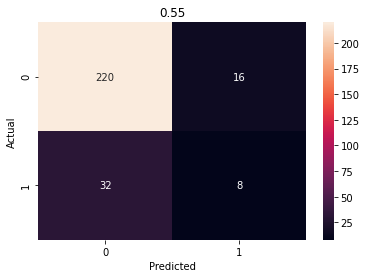

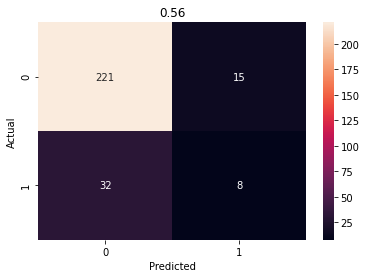

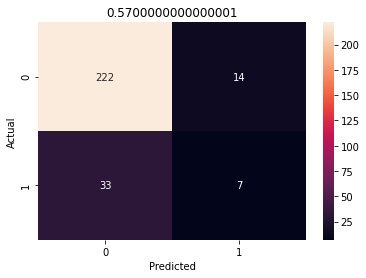

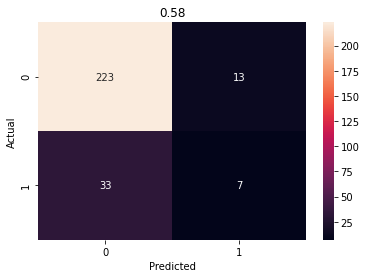

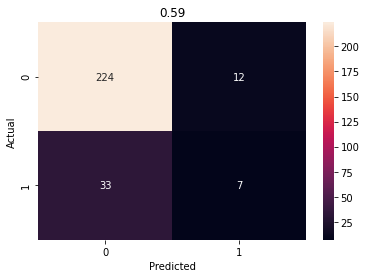

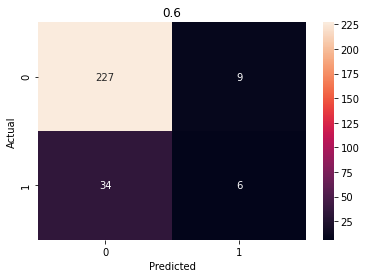

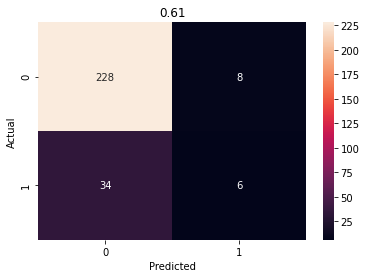

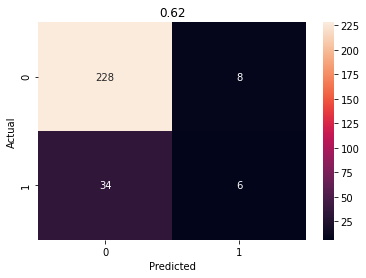

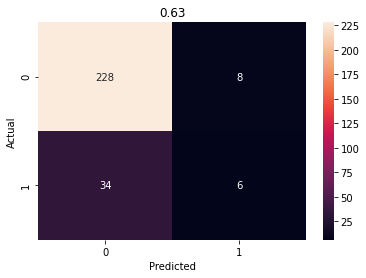

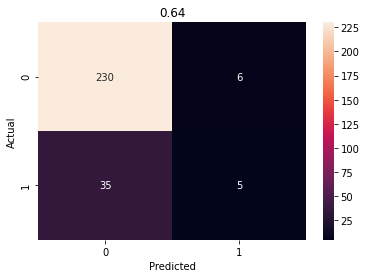

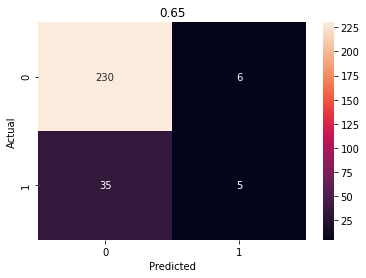

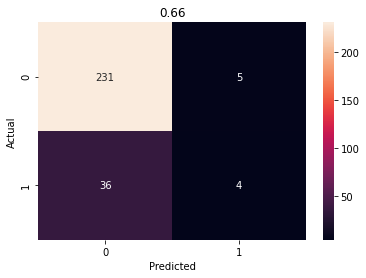

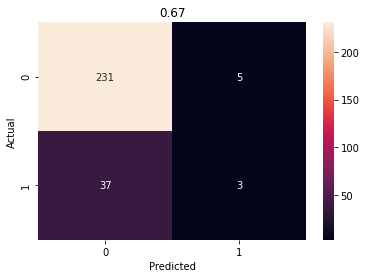

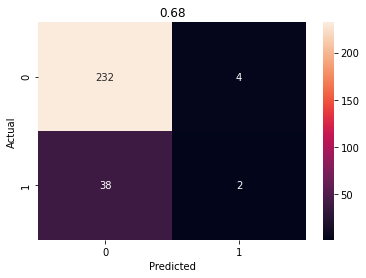

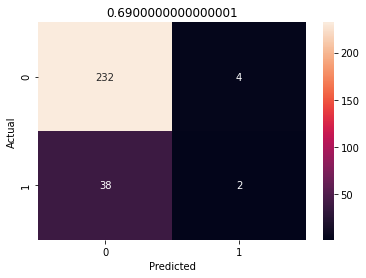

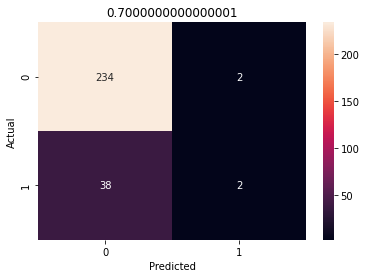

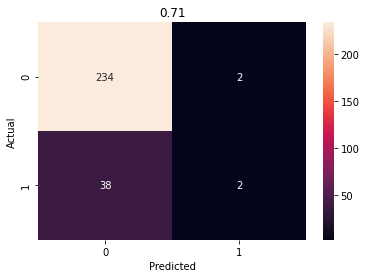

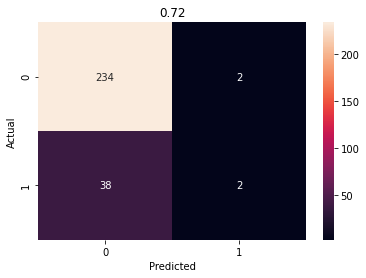

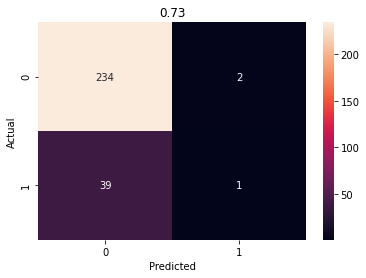

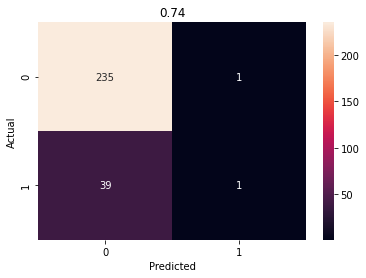

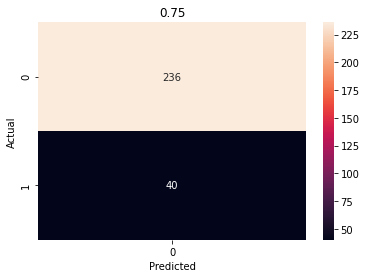

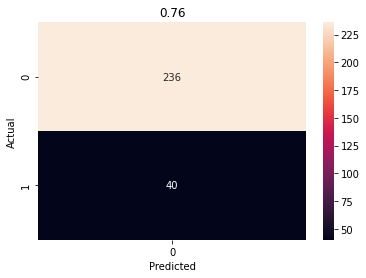

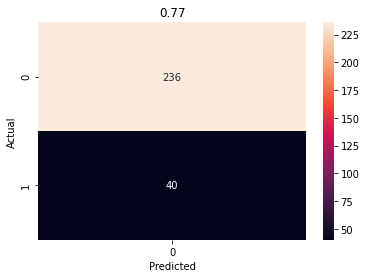

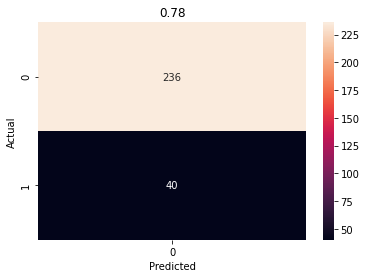

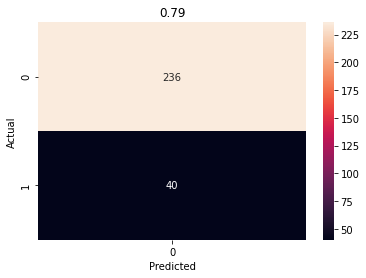

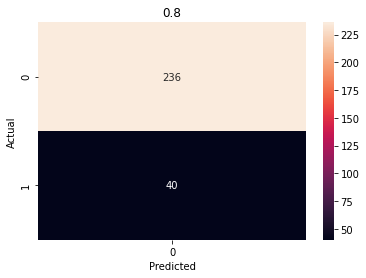

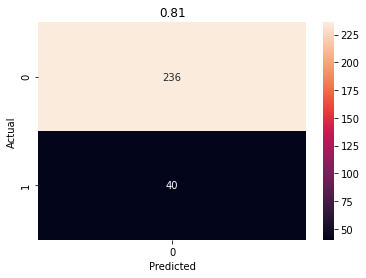

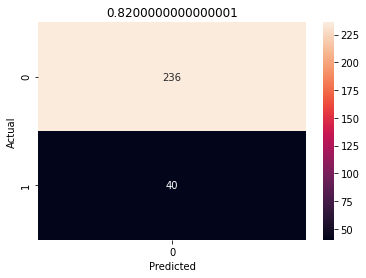

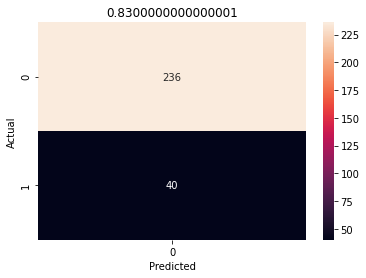

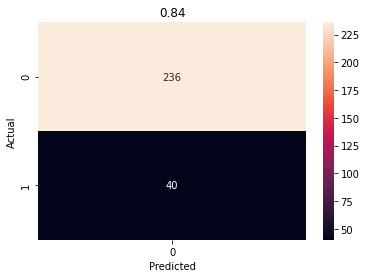

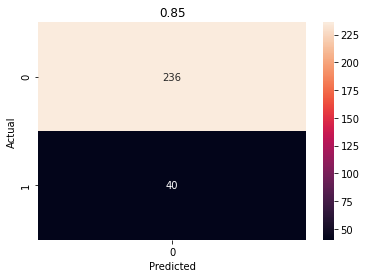

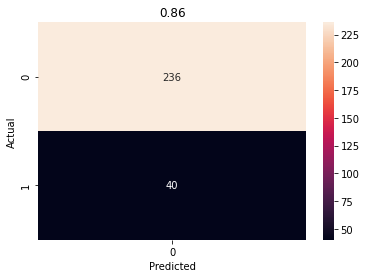

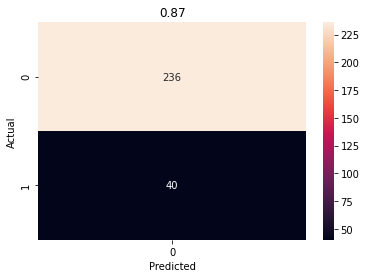

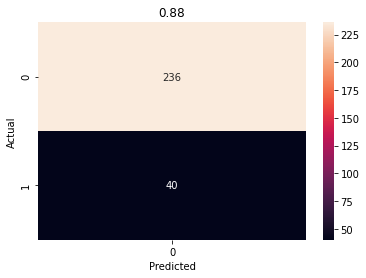

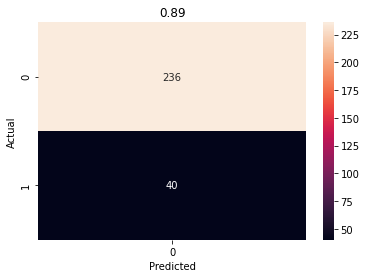

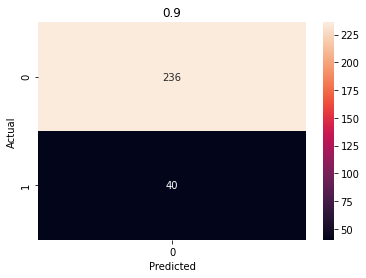

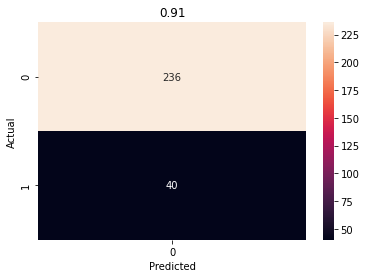

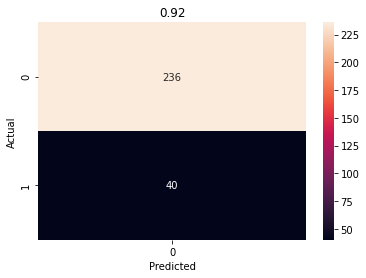

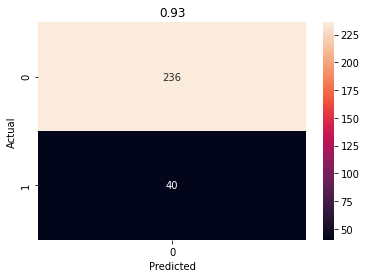

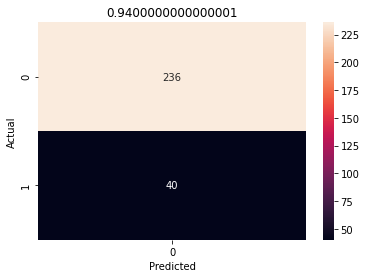

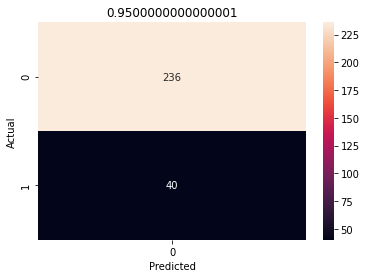

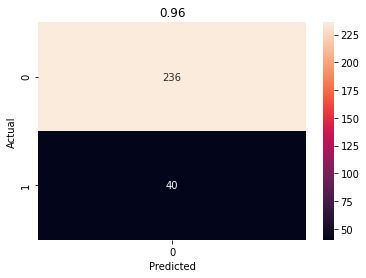

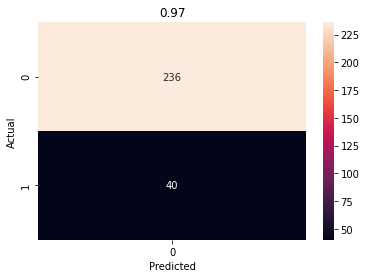

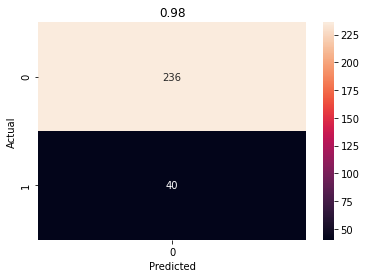

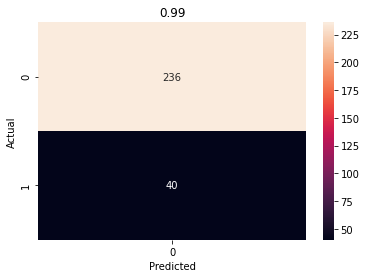

In [217]:
for threshold in np.arange(0,1,0.01):
    predicted_proba = rand_rf_model.predict_proba(X_val)
    predicted = (predicted_proba[:, 1] >= threshold).astype('int')
    plt.title(threshold)
    data = {
    'y_true':  y_val,
    'y_pred': predicted
    }

    df = pd.DataFrame(data, columns=['y_true','y_pred'])
    
    confusion_matrix = pd.crosstab(df['y_true'], df['y_pred'], rownames=['Actual'], colnames=['Predicted'])
    sns.heatmap(confusion_matrix, annot = True, fmt = 'd')
    plt.show()

### KNN

In [218]:
# knn_model = KNeighborsClassifier()
# knn_model.fit(X_train_smote, y_train_smote)

In [219]:
# y_pred_knn = knn_model.predict(X_val)

In [220]:
# for threshold in np.arange(0,1,0.01):
#     predicted_proba = knn_model.predict_proba(X_val)
#     predicted = (predicted_proba[:, 1] >= threshold).astype('int')
#     print(threshold, '================================================== \n', 
#           classification_report(y_val, predicted))

### Neural Network

In [221]:
# from tensorflow.keras import optimizers
# from tensorflow.keras import metrics

In [222]:
# ann_model = models.Sequential()
# ann_model.add(layers.Dense(22, input_shape = (X_train_smote.shape), activation = 'relu'))
# ann_model.add(layers.Dense(128, activation = 'relu'))
# ann_model.add(layers.Dense(56, activation = 'relu'))
# ann_model.add(layers.Dense(28, activation = 'relu'))
# ann_model.add(layers.Dense(16, activation = 'relu'))
# ann_model.add(layers.Dense(1, activation = 'sigmoid'))

# # adam_opt = optimizers.Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999)

# ann_model.compile(loss='binary_crossentropy',
#                   optimizer='adam',
#                   metrics=[metrics.Recall()])

In [223]:
# ann_model.fit(X_train_smote, y_train_smote,
#               batch_size=16,
#               epochs=100,
#               validation_split = .3)

In [224]:
# y_pred_ann_model = ann_model.predict(X_val)
# y_pred_ann_model

In [225]:
# for threshold in np.arange(0,1,0.01):
#     predicted_proba = ann_model.predict(X_val)
#     predicted = (predicted_proba >= threshold).astype('int')
#     print(threshold, '================================================== \n', 
#           classification_report(y_val, predicted))

### XGBoost Classfiier

#### Baseline XGBoost Model

In [226]:
# xgb_model = XGBClassifier(random_state = 0)

In [227]:
# xgb_model.fit(X_train_smote, y_train_smote)

In [228]:
# y_pred_xgb = xgb_model.predict(X_val)

In [229]:
# for threshold in np.arange(0,1,0.01):
#     predicted_proba = xgb_model.predict_proba(X_val)
#     predicted = (predicted_proba[:, 1] >= threshold).astype('int')
#     print(threshold, '================================================== \n', 
#           classification_report(y_val, predicted))

In [230]:
# for threshold in np.arange(0,1,0.01):
#     predicted_proba = xgb_model.predict_proba(X_val)
#     predicted = (predicted_proba[:, 1] >= threshold).astype('int')
#     plt.title(threshold)
#     data = {
#     'y_true':  y_val,
#     'y_pred': predicted
#     }

#     df = pd.DataFrame(data, columns=['y_true','y_pred'])
    
#     confusion_matrix = pd.crosstab(df['y_true'], df['y_pred'], rownames=['Actual'], colnames=['Predicted'])
#     sns.heatmap(confusion_matrix, annot = True, fmt = 'd')
#     plt.show()

#### Second Baseline XGBoost Model

In [231]:
# xgb_model2 = XGBClassifier(objective = 'binary:logistic')

In [232]:
# history = xgb_model2.fit(X_train_smote, y_train_smote, 
#                eval_metric = 'logloss',
#                eval_set = [(X_train_smote, y_train_smote), (X_val, y_val)],
#                early_stopping_rounds = 1000, verbose = 1)

In [233]:
# history.best_score

In [234]:
# y_pred_xgb2 = history.predict(X_val)

In [235]:
# print(classification_report(y_val, y_pred_xgb2))

In [236]:
# for threshold in np.arange(0,1,0.01):
#     predicted_proba = xgb_model2.predict_proba(X_val)
#     predicted = (predicted_proba[:, 1] >= threshold).astype('int')
#     print(threshold, '================================================== \n', 
#           classification_report(y_val, predicted))

In [237]:
# for threshold in np.arange(0,1,0.01):
#     predicted_proba = xgb_model2.predict_proba(X_val)
#     predicted = (predicted_proba[:, 1] >= threshold).astype('int')
#     plt.title(threshold)
#     data = {
#     'y_true':  y_val,
#     'y_pred': predicted
#     }

#     df = pd.DataFrame(data, columns=['y_true','y_pred'])
    
#     confusion_matrix = pd.crosstab(df['y_true'], df['y_pred'], rownames=['Actual'], colnames=['Predicted'])
#     sns.heatmap(confusion_matrix, annot = True, fmt = 'd')
#     plt.show()

In [238]:
# xgb_params = {
#     'eta': loguniform(0.01, 0.1),
#     'gamma': loguniform(0.01, 0.1),
# #     'min_child_weight': np.random.randint(0, 10),
# #     'max_delta_step': np.random.randint(0, 10),
#     'subsample': loguniform(.75, 1),
# #     'lambda': np.random.randint(0, 4),
# #     'alpha': np.random.randint(0, 4),
#     'col_sample_bytree': loguniform(.3, 1),
#     'grow_policy': ['depthwise', 'lossguide'],
# }

# rs_xgb_model2 = RandomizedSearchCV(xgb_model2, param_distributions = xgb_params, n_iter = 250, 
#                                    scoring = ['precision', 'recall', 'f1'], refit = 'f1', 
#                                    cv = 5, n_jobs = -1, verbose = 1)

In [239]:
# rs_xgb_model2.fit(X_train_smote, y_train_smote)

In [240]:
# rs_xgb_model2.best_estimator_

In [241]:
# y_pred_rs_xgb2 = rs_xgb_model2.predict(X_val)

In [242]:
# print(classification_report(y_val, y_pred_rs_xgb2))

In [243]:
# for threshold in np.arange(0,1,0.01):
#     predicted_proba = rs_xgb_model2.predict_proba(X_val)
#     predicted = (predicted_proba[:, 1] >= threshold).astype('int')
#     plt.title(threshold)
#     data = {
#     'y_true':  y_val,
#     'y_pred': predicted
#     }

#     df = pd.DataFrame(data, columns=['y_true','y_pred'])
    
#     confusion_matrix = pd.crosstab(df['y_true'], df['y_pred'], rownames=['Actual'], colnames=['Predicted'])
#     sns.heatmap(confusion_matrix, annot = True, fmt = 'd')
#     plt.show()

In [244]:
# for threshold in np.arange(0,1,0.01):
#     predicted_proba = rs_xgb_model2.predict_proba(X_val)
#     predicted = (predicted_proba[:, 1] >= threshold).astype('int')
#     plt.title(threshold)
#     data = {
#     'y_true':  y_val,
#     'y_pred': predicted
#     }

#     df = pd.DataFrame(data, columns=['y_true','y_pred'])
    
#     confusion_matrix = pd.crosstab(df['y_true'], df['y_pred'], rownames=['Actual'], colnames=['Predicted'])
#     sns.heatmap(confusion_matrix, annot = True, fmt = 'd')
#     plt.show()

#### _Final_ XGBoost Model with RandomizedSearchCV

In [245]:
rs_xgb_model3 = RandomizedSearchCV(xgb_model2, param_distributions = xgb_params, n_iter = 250, 
                                   scoring = ['precision', 'recall', 'f1'], refit = 'recall', 
                                   cv = 10, n_jobs = -1, verbose = 1)

In [246]:
rs_xgb_model3.fit(X_train_smote, y_train_smote)

Fitting 10 folds for each of 250 candidates, totalling 2500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   18.4s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   42.4s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 2500 out of 2500 | elapsed:  4.0min finished


[11:05:08] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { col_sample_bytree } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




RandomizedSearchCV(cv=10,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           gpu_id=-1, importance_type='gain',
                                           interaction_constraints='',
                                           learning_rate=0.300000012,
                                           max_delta_step=0, max_depth=6,
                                           min_child_weight=1, missing=nan,
                                           monotone_constraints='()',
                                           n_estimators=100, n_jobs=0,
                                           num_p...
                   param_distributions={'col_sample_bytree': <scipy.stats._distn_infrastructure.rv_frozen object at 0x14a91d410>,
      

In [247]:
y_pred_rs_xgb3 = rs_xgb_model3.predict(X_val)

In [248]:
print(classification_report(y_val, y_pred_rs_xgb3))

              precision    recall  f1-score   support

           0       0.90      0.93      0.91       236
           1       0.47      0.38      0.42        40

    accuracy                           0.85       276
   macro avg       0.68      0.65      0.66       276
weighted avg       0.84      0.85      0.84       276



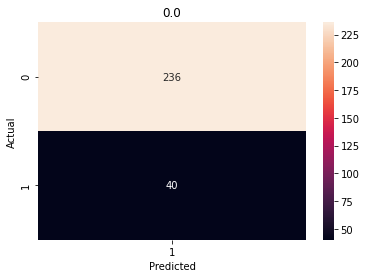

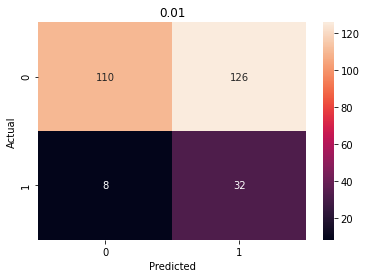

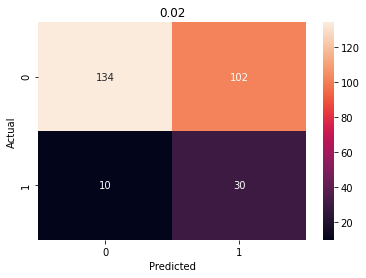

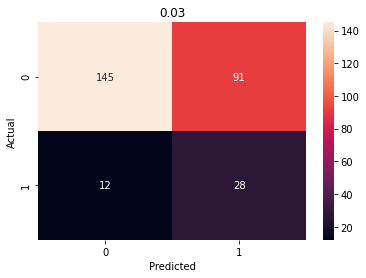

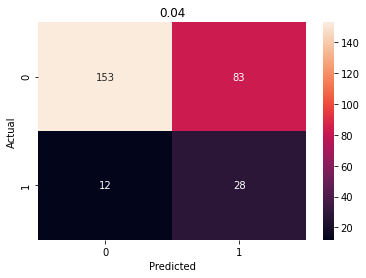

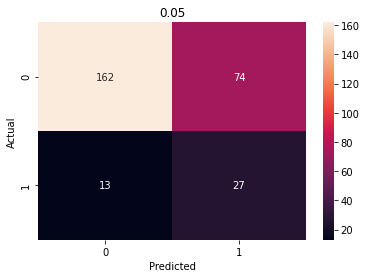

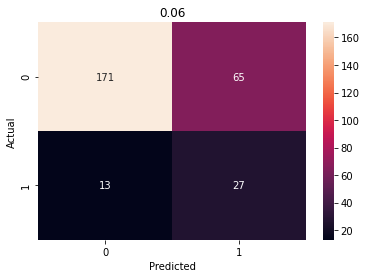

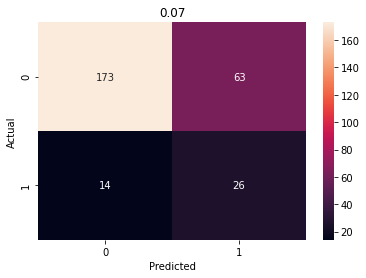

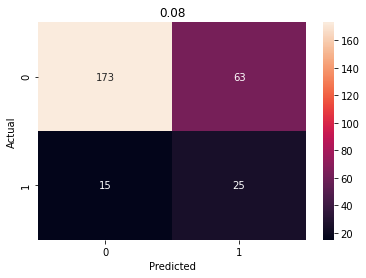

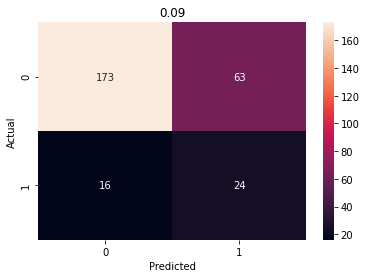

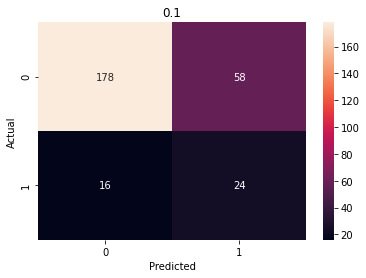

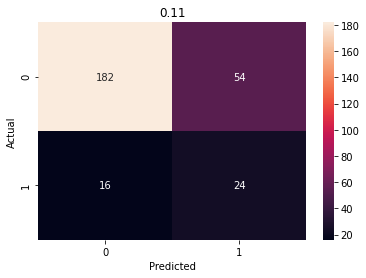

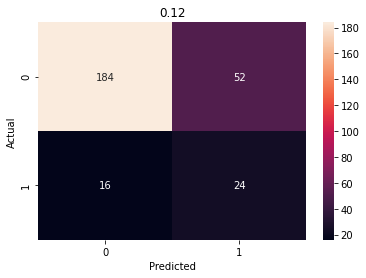

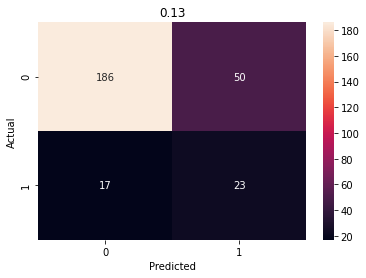

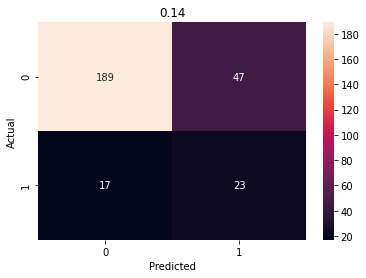

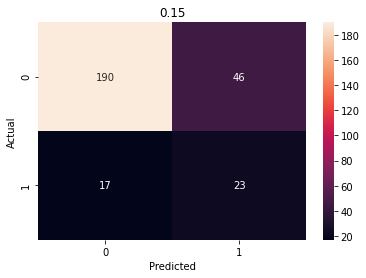

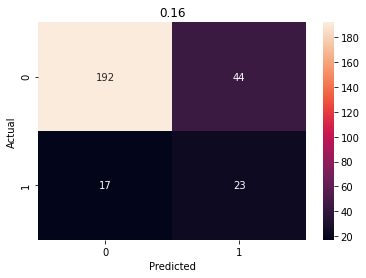

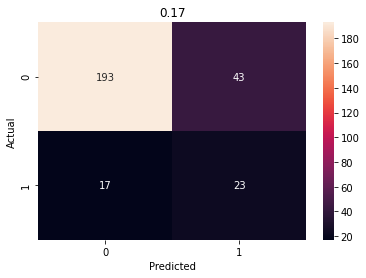

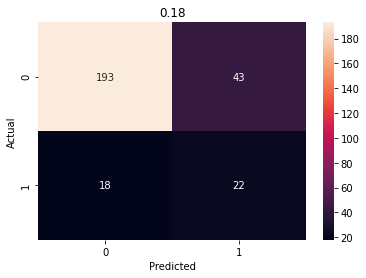

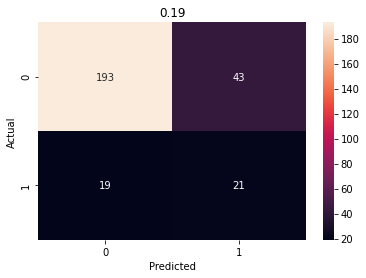

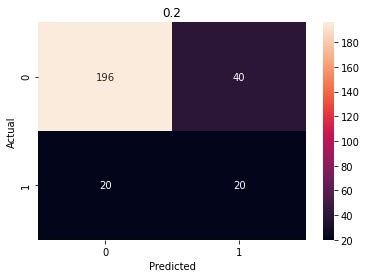

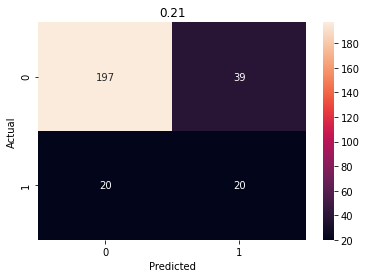

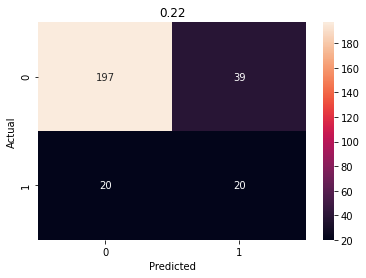

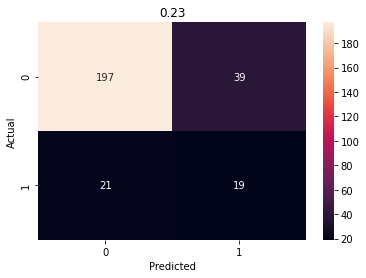

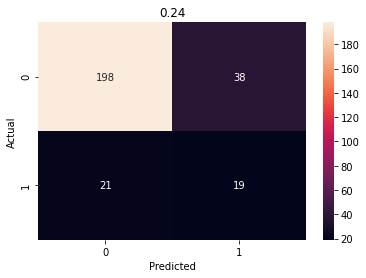

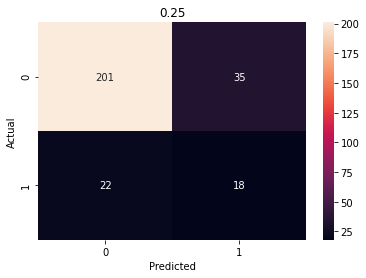

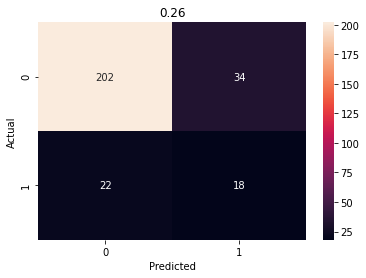

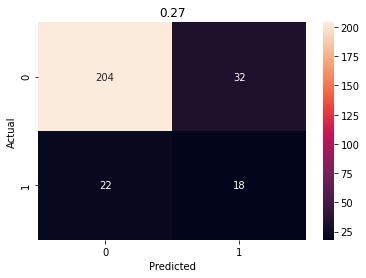

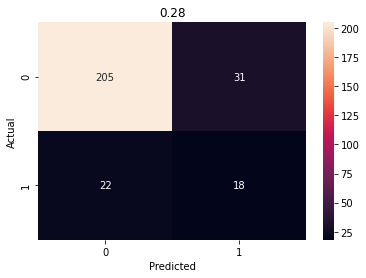

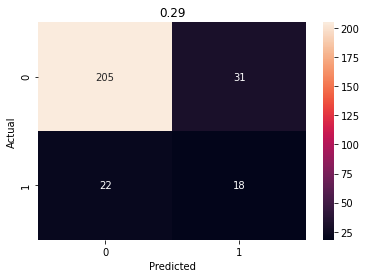

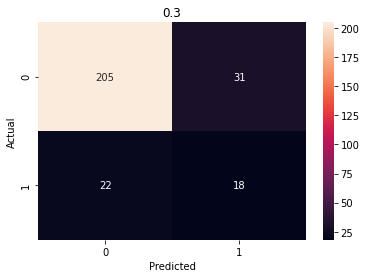

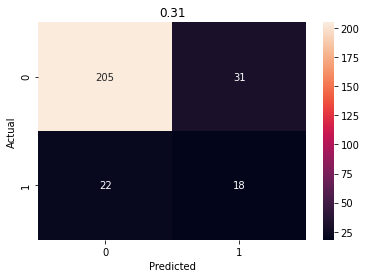

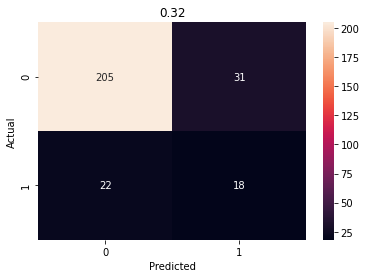

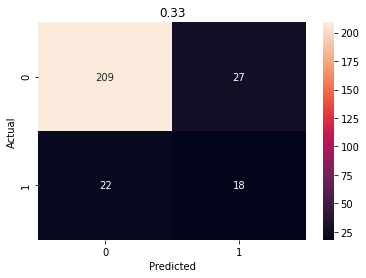

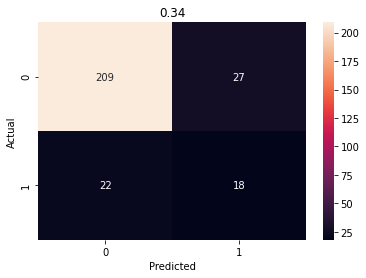

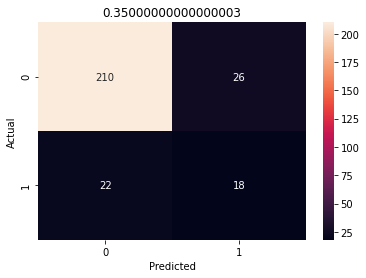

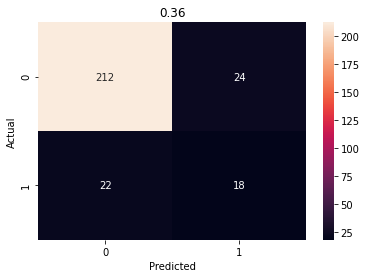

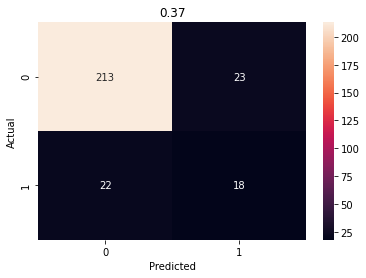

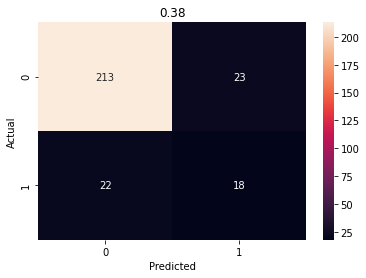

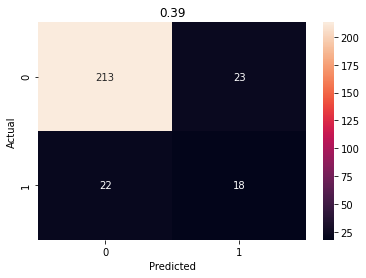

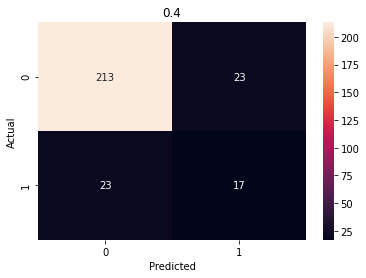

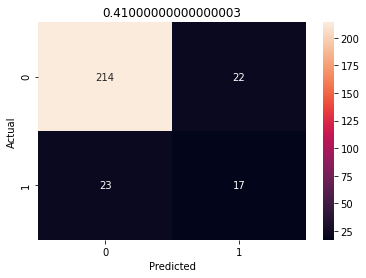

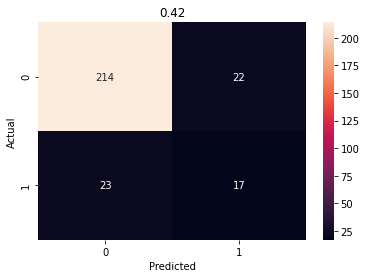

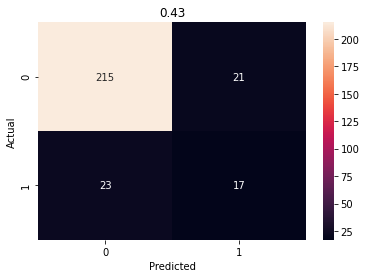

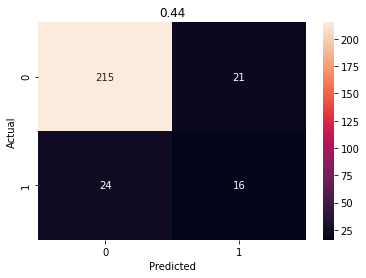

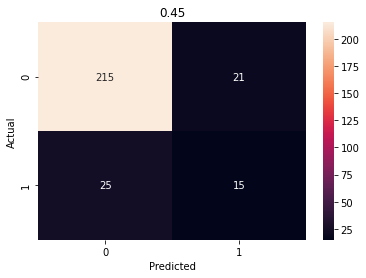

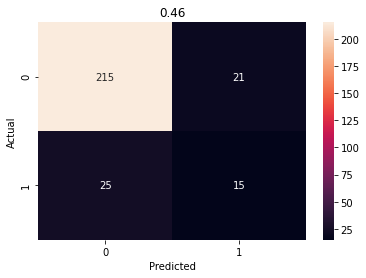

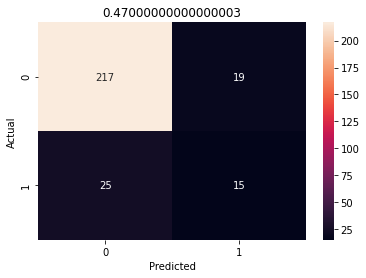

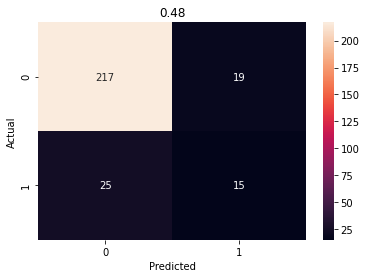

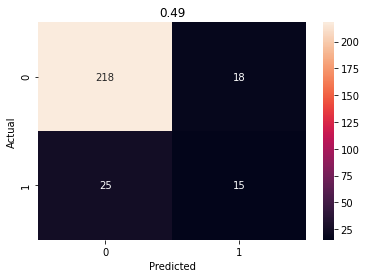

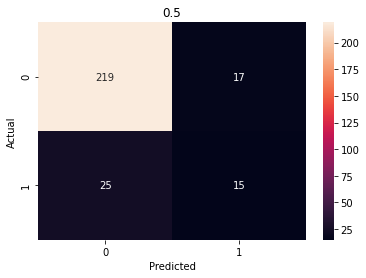

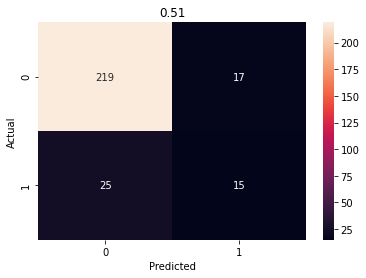

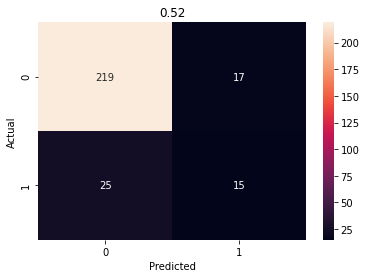

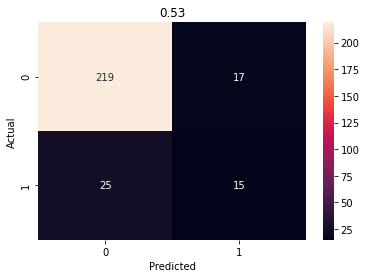

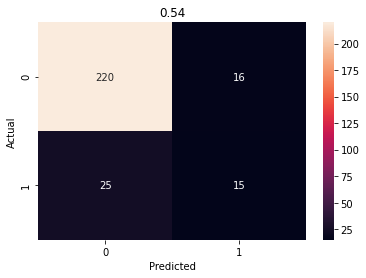

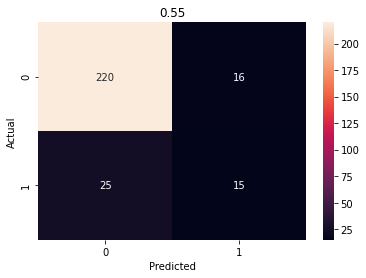

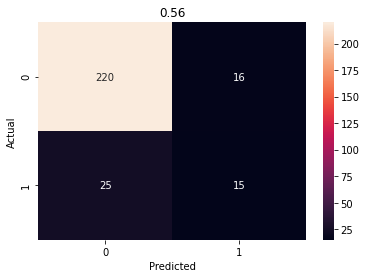

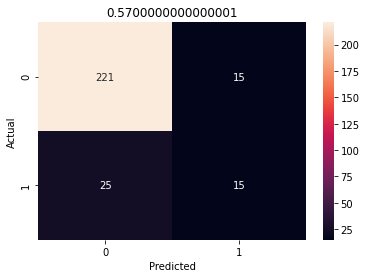

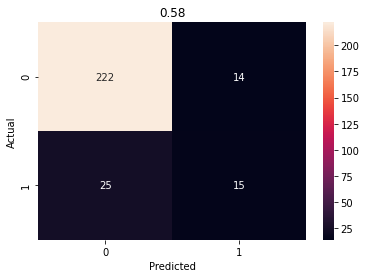

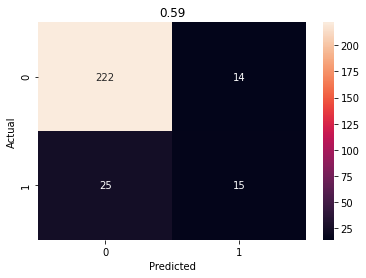

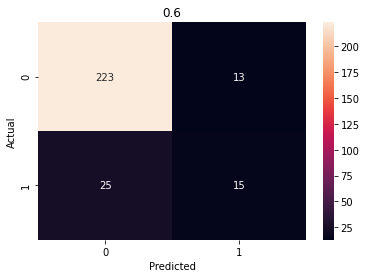

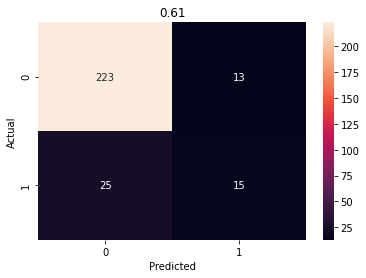

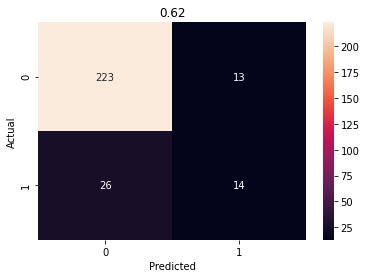

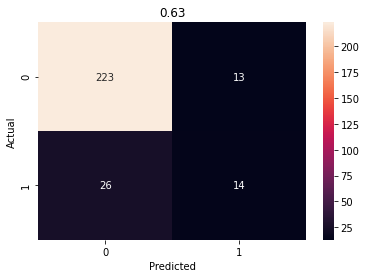

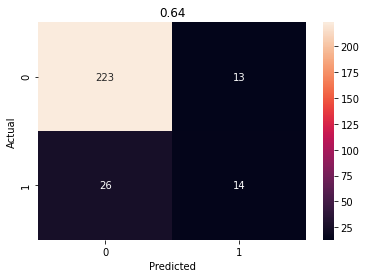

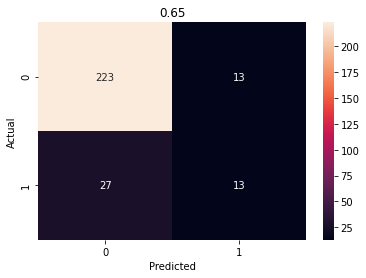

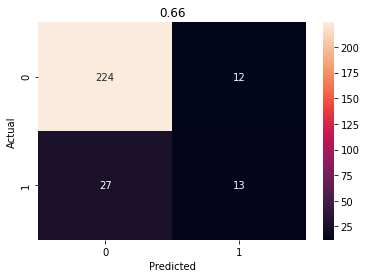

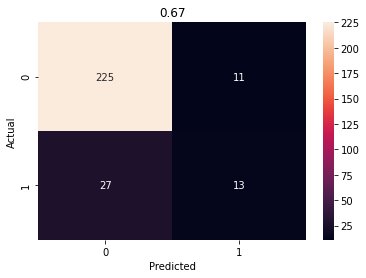

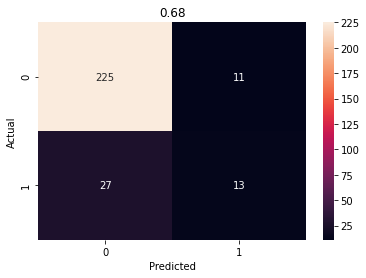

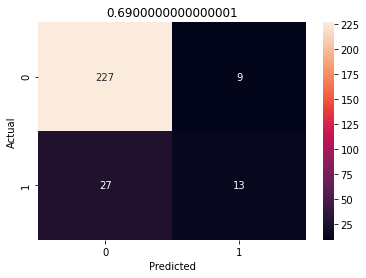

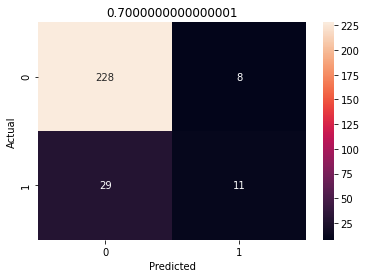

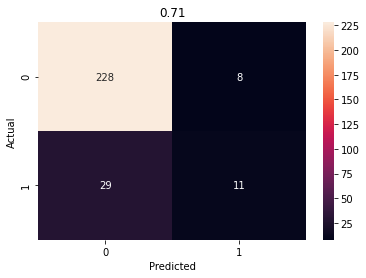

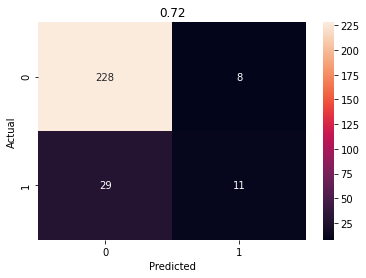

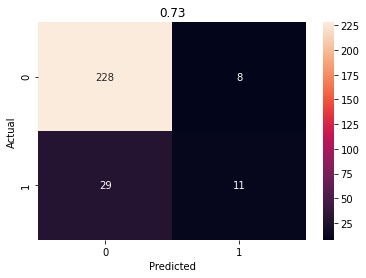

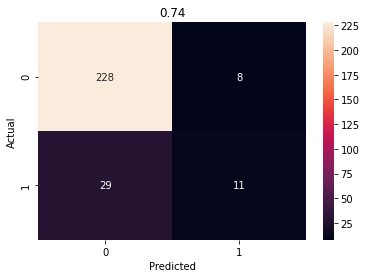

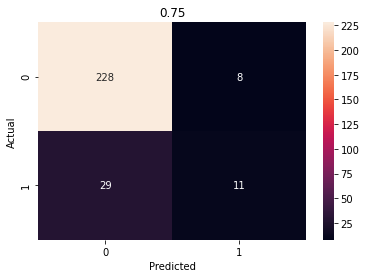

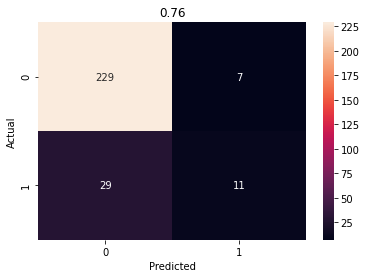

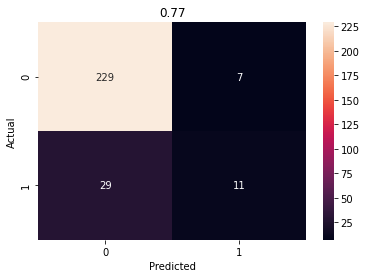

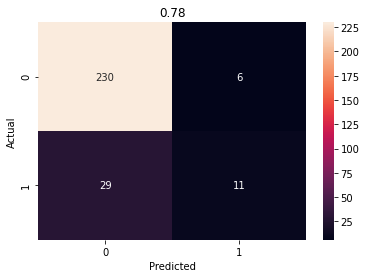

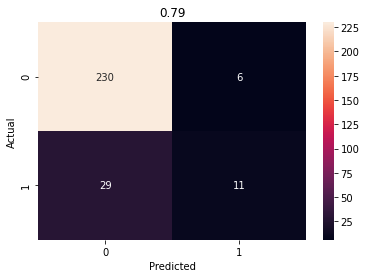

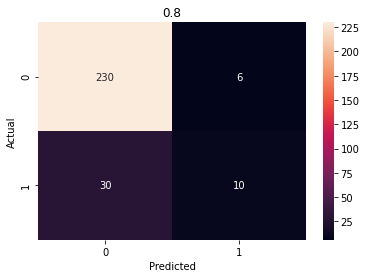

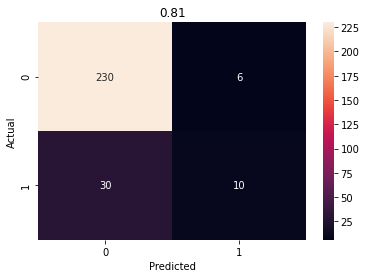

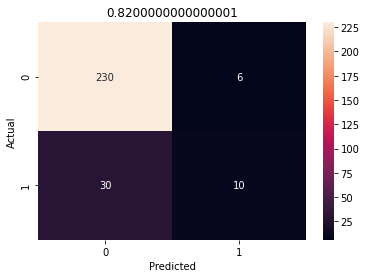

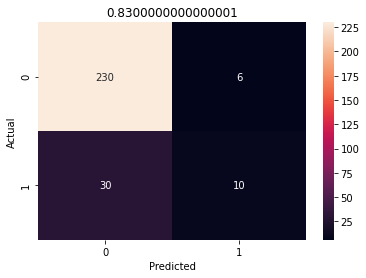

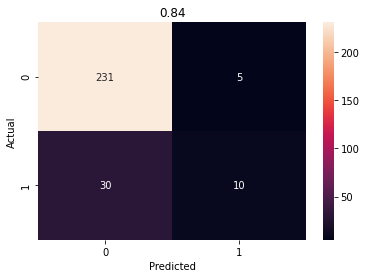

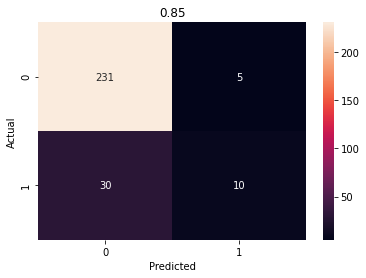

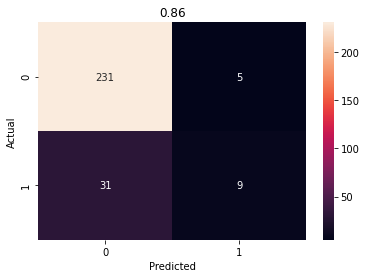

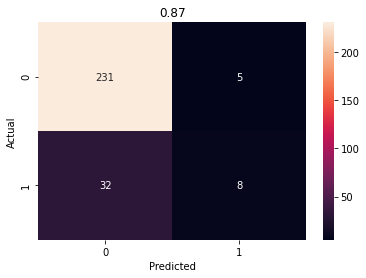

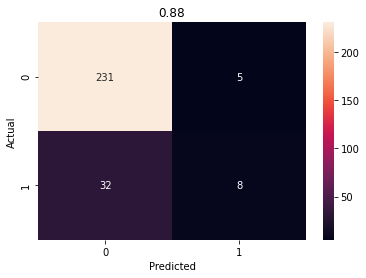

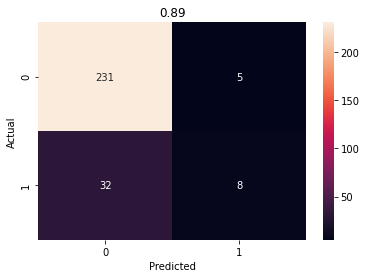

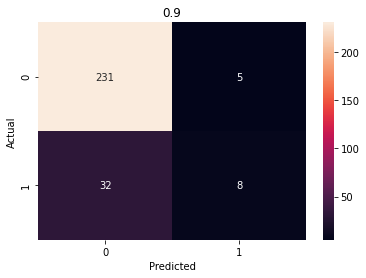

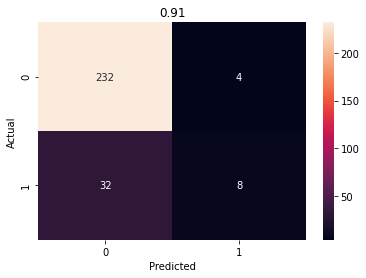

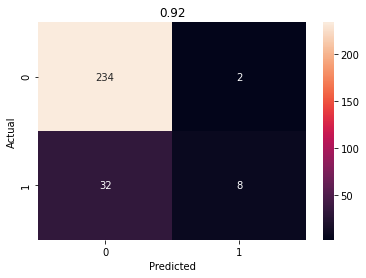

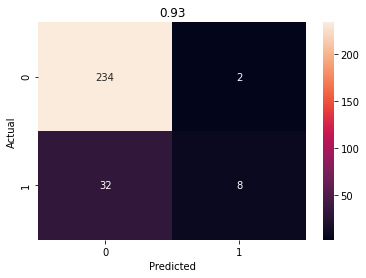

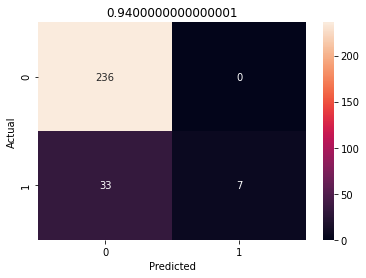

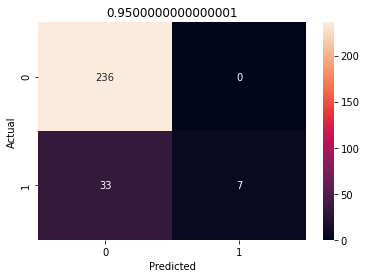

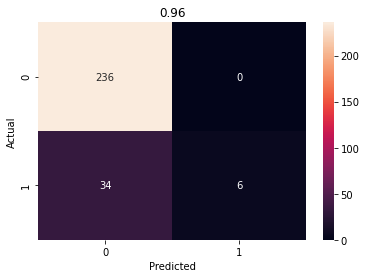

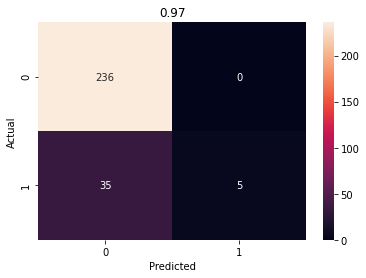

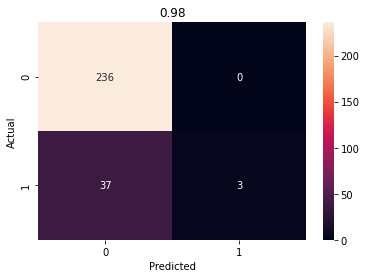

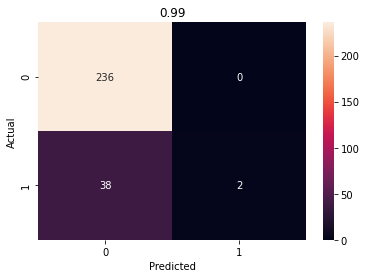

In [249]:
for threshold in np.arange(0,1,0.01):
    predicted_proba = rs_xgb_model3.predict_proba(X_val)
    predicted = (predicted_proba[:, 1] >= threshold).astype('int')
    plt.title(threshold)
    data = {
    'y_true':  y_val,
    'y_pred': predicted
    }

    df = pd.DataFrame(data, columns=['y_true','y_pred'])
    
    confusion_matrix = pd.crosstab(df['y_true'], df['y_pred'], rownames=['Actual'], colnames=['Predicted'])
    sns.heatmap(confusion_matrix, annot = True, fmt = 'd')
    plt.show()

In [250]:
for threshold in np.arange(0,1,0.01):
    predicted_proba = rs_xgb_model3.predict_proba(X_val)
    predicted = (predicted_proba[:, 1] >= threshold).astype('int')
    print(threshold, '================================================== \n', 
          classification_report(y_val, predicted))

0.0 ================================================== 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       236
           1       0.14      1.00      0.25        40

    accuracy                           0.14       276
   macro avg       0.07      0.50      0.13       276
weighted avg       0.02      0.14      0.04       276

0.01 ================================================== 
               precision    recall  f1-score   support

           0       0.93      0.47      0.62       236
           1       0.20      0.80      0.32        40

    accuracy                           0.51       276
   macro avg       0.57      0.63      0.47       276
weighted avg       0.83      0.51      0.58       276

0.02 ================================================== 
               precision    recall  f1-score   support

           0       0.93      0.57      0.71       236
           1       0.23      0.75      0.35        40

    accur

0.32 ================================================== 
               precision    recall  f1-score   support

           0       0.90      0.87      0.89       236
           1       0.37      0.45      0.40        40

    accuracy                           0.81       276
   macro avg       0.64      0.66      0.65       276
weighted avg       0.83      0.81      0.82       276

0.33 ================================================== 
               precision    recall  f1-score   support

           0       0.90      0.89      0.90       236
           1       0.40      0.45      0.42        40

    accuracy                           0.82       276
   macro avg       0.65      0.67      0.66       276
weighted avg       0.83      0.82      0.83       276

0.34 ================================================== 
               precision    recall  f1-score   support

           0       0.90      0.89      0.90       236
           1       0.40      0.45      0.42        40

    accu

0.5700000000000001 ================================================== 
               precision    recall  f1-score   support

           0       0.90      0.94      0.92       236
           1       0.50      0.38      0.43        40

    accuracy                           0.86       276
   macro avg       0.70      0.66      0.67       276
weighted avg       0.84      0.86      0.85       276

0.58 ================================================== 
               precision    recall  f1-score   support

           0       0.90      0.94      0.92       236
           1       0.52      0.38      0.43        40

    accuracy                           0.86       276
   macro avg       0.71      0.66      0.68       276
weighted avg       0.84      0.86      0.85       276

0.59 ================================================== 
               precision    recall  f1-score   support

           0       0.90      0.94      0.92       236
           1       0.52      0.38      0.43      

0.91 ================================================== 
               precision    recall  f1-score   support

           0       0.88      0.98      0.93       236
           1       0.67      0.20      0.31        40

    accuracy                           0.87       276
   macro avg       0.77      0.59      0.62       276
weighted avg       0.85      0.87      0.84       276

0.92 ================================================== 
               precision    recall  f1-score   support

           0       0.88      0.99      0.93       236
           1       0.80      0.20      0.32        40

    accuracy                           0.88       276
   macro avg       0.84      0.60      0.63       276
weighted avg       0.87      0.88      0.84       276

0.93 ================================================== 
               precision    recall  f1-score   support

           0       0.88      0.99      0.93       236
           1       0.80      0.20      0.32        40

    accu

In [251]:
best_xgb_model = rs_xgb_model3.best_estimator_

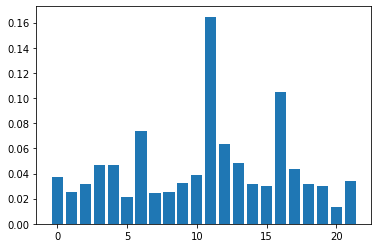

In [252]:
plt.bar(range(len(best_xgb_model.feature_importances_)), best_xgb_model.feature_importances_)
plt.show()

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

<Figure size 1152x720 with 0 Axes>

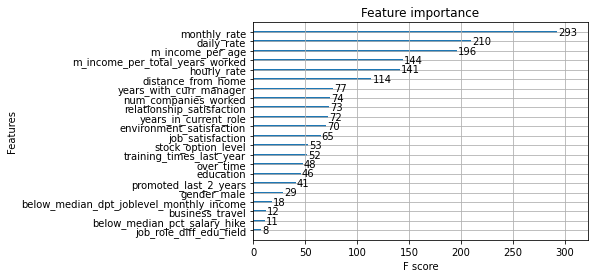

In [253]:
plt.figure(figsize = (16, 10))
plot_importance(best_xgb_model)

## Voting Classifier

In [255]:
from sklearn.ensemble import VotingClassifier

In [259]:
soft_voting_model = VotingClassifier(estimators = [
    ('log_model', rand_search_log_model),
    ('rf_model', rand_rf_model),
    ('xgb_model', rs_xgb_model3)], 
    voting = 'soft', verbose = True)

In [260]:
soft_voting_model.fit(X_train_smote, y_train_smote)

Fitting 10 folds for each of 250 candidates, totalling 2500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 2320 tasks      | elapsed:   17.2s
[Parallel(n_jobs=-1)]: Done 2500 out of 2500 | elapsed:   18.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[Voting] ................ (1 of 3) Processing log_model, total=  18.9s
Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   22.0s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   48.6s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  1.7min finished


[Voting] ................. (2 of 3) Processing rf_model, total= 1.7min
Fitting 10 folds for each of 250 candidates, totalling 2500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   23.7s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   54.7s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 2500 out of 2500 | elapsed:  5.1min finished


[11:22:49] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { col_sample_bytree } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[Voting] ................ (3 of 3) Processing xgb_model, total= 5.1min


VotingClassifier(estimators=[('log_model',
                              RandomizedSearchCV(cv=10,
                                                 estimator=LogisticRegression(random_state=0),
                                                 n_iter=250, n_jobs=-1,
                                                 param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x14b542ed0>,
                                                                      'l1_ratio': <scipy.stats._distn_infrastructure.rv_frozen object at 0x14a6b5510>,
                                                                      'penalty': ['l1',
                                                                                  'l2',
                                                                                  'elasticnet',
                                                                                  'none'],
                                                                      'solve

In [261]:
soft_voting_model.predict(X_val)

array([0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [264]:
for threshold in np.arange(0,1,0.01):
    predicted_proba = soft_voting_model.predict_proba(X_val)
    predicted = (predicted_proba[:, 1] >= threshold).astype('int')
    print(threshold, '================================================== \n', 
          classification_report(y_val, predicted))

0.0 ================================================== 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       236
           1       0.14      1.00      0.25        40

    accuracy                           0.14       276
   macro avg       0.07      0.50      0.13       276
weighted avg       0.02      0.14      0.04       276

0.01 ================================================== 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       236
           1       0.14      1.00      0.25        40

    accuracy                           0.14       276
   macro avg       0.07      0.50      0.13       276
weighted avg       0.02      0.14      0.04       276

0.02 ================================================== 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       236
           1       0.14      1.00      0.25        40

    accur

0.23 ================================================== 
               precision    recall  f1-score   support

           0       0.95      0.52      0.67       236
           1       0.23      0.85      0.36        40

    accuracy                           0.57       276
   macro avg       0.59      0.69      0.52       276
weighted avg       0.85      0.57      0.63       276

0.24 ================================================== 
               precision    recall  f1-score   support

           0       0.94      0.55      0.69       236
           1       0.23      0.78      0.35        40

    accuracy                           0.58       276
   macro avg       0.58      0.66      0.52       276
weighted avg       0.83      0.58      0.64       276

0.25 ================================================== 
               precision    recall  f1-score   support

           0       0.93      0.58      0.71       236
           1       0.23      0.72      0.35        40

    accu

0.51 ================================================== 
               precision    recall  f1-score   support

           0       0.89      0.92      0.90       236
           1       0.38      0.30      0.33        40

    accuracy                           0.83       276
   macro avg       0.63      0.61      0.62       276
weighted avg       0.81      0.83      0.82       276

0.52 ================================================== 
               precision    recall  f1-score   support

           0       0.89      0.92      0.90       236
           1       0.39      0.30      0.34        40

    accuracy                           0.83       276
   macro avg       0.64      0.61      0.62       276
weighted avg       0.81      0.83      0.82       276

0.53 ================================================== 
               precision    recall  f1-score   support

           0       0.89      0.92      0.90       236
           1       0.39      0.30      0.34        40

    accu

0.73 ================================================== 
               precision    recall  f1-score   support

           0       0.88      0.99      0.93       236
           1       0.70      0.17      0.28        40

    accuracy                           0.87       276
   macro avg       0.79      0.58      0.60       276
weighted avg       0.85      0.87      0.83       276

0.74 ================================================== 
               precision    recall  f1-score   support

           0       0.88      0.99      0.93       236
           1       0.70      0.17      0.28        40

    accuracy                           0.87       276
   macro avg       0.79      0.58      0.60       276
weighted avg       0.85      0.87      0.83       276

0.75 ================================================== 
               precision    recall  f1-score   support

           0       0.87      0.99      0.93       236
           1       0.67      0.15      0.24        40

    accu

0.99 ================================================== 
               precision    recall  f1-score   support

           0       0.86      1.00      0.92       236
           1       0.00      0.00      0.00        40

    accuracy                           0.86       276
   macro avg       0.43      0.50      0.46       276
weighted avg       0.73      0.86      0.79       276



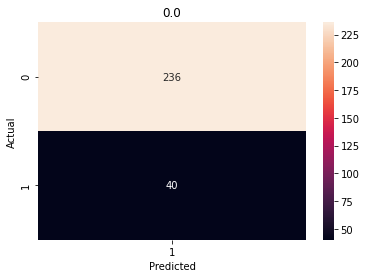

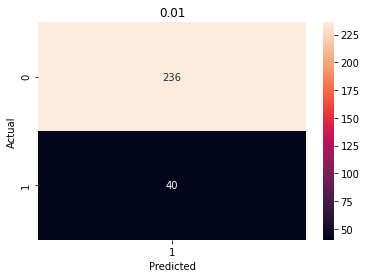

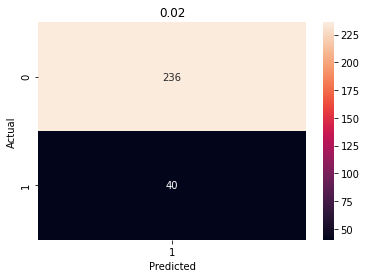

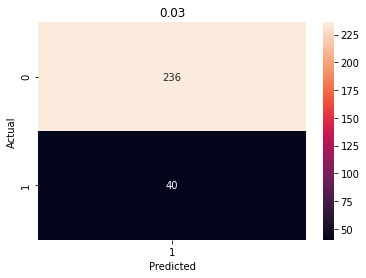

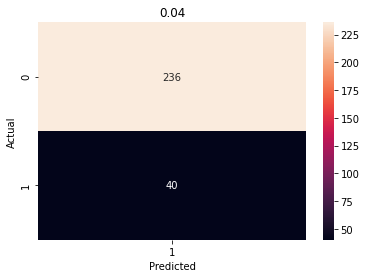

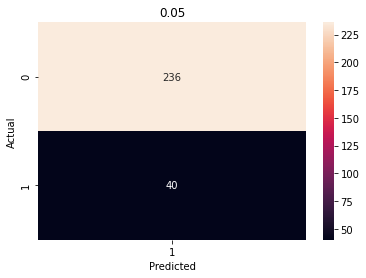

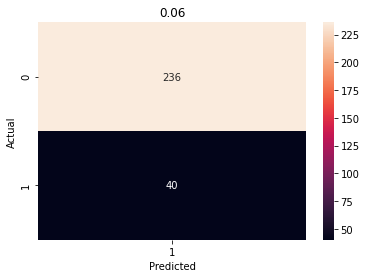

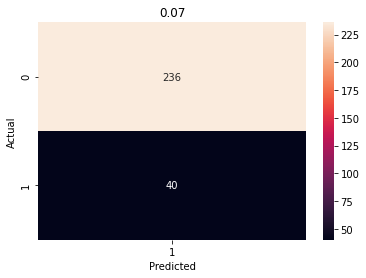

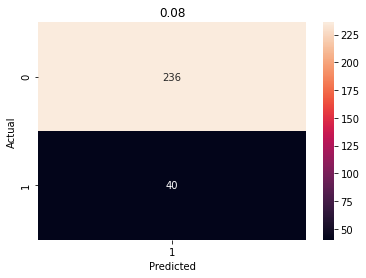

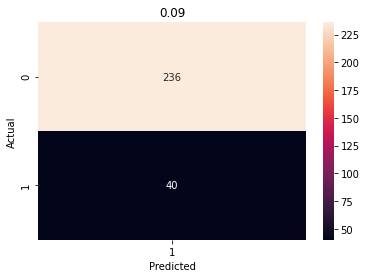

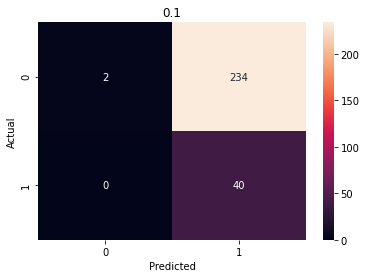

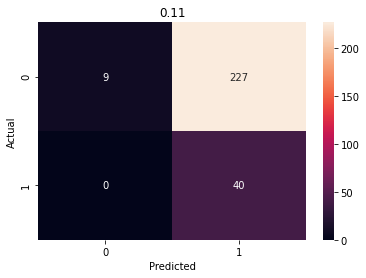

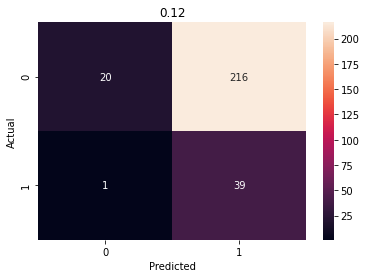

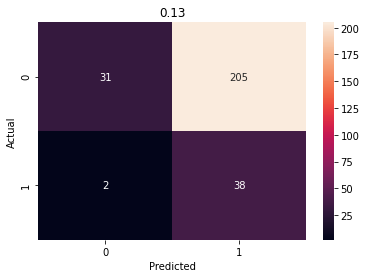

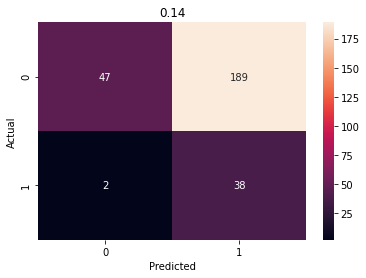

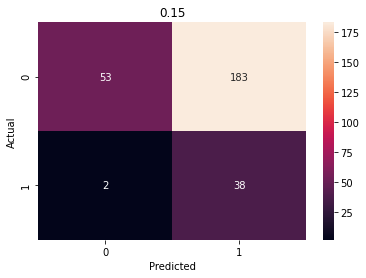

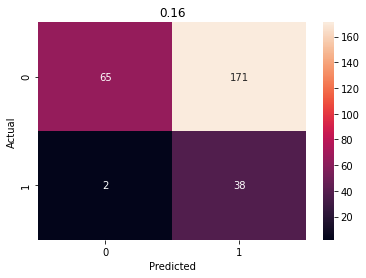

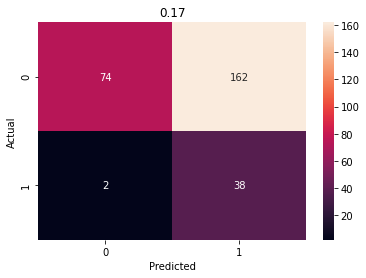

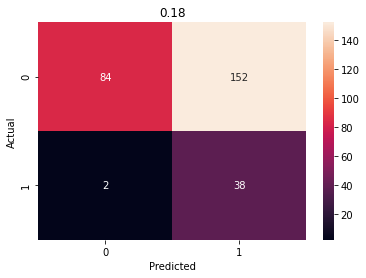

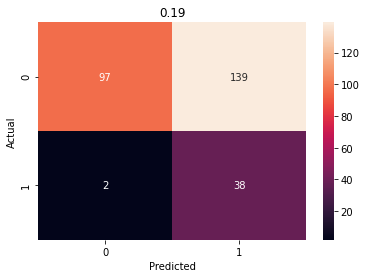

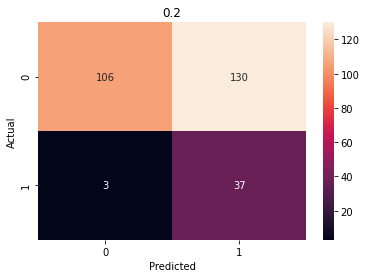

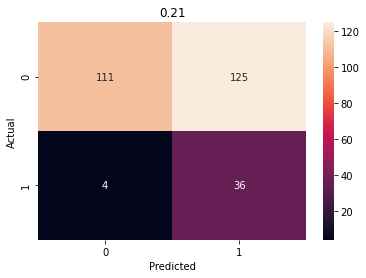

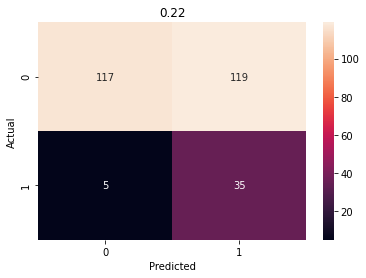

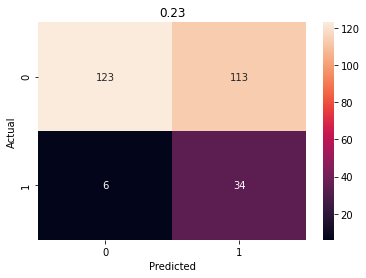

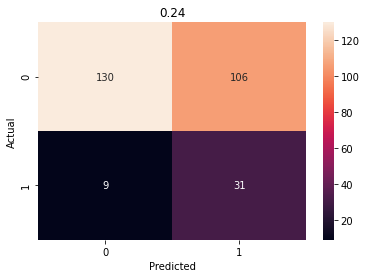

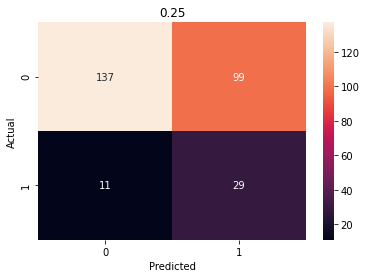

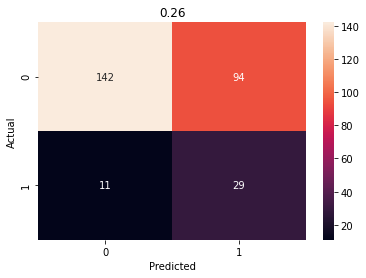

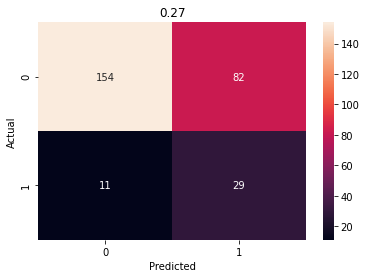

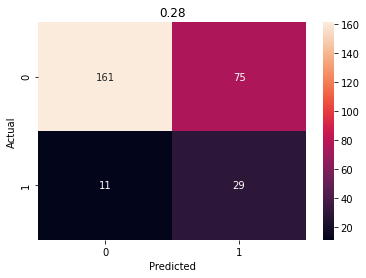

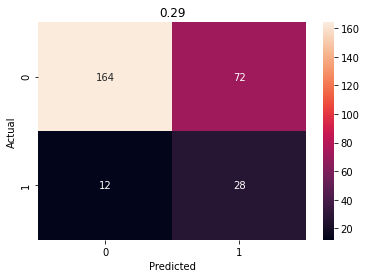

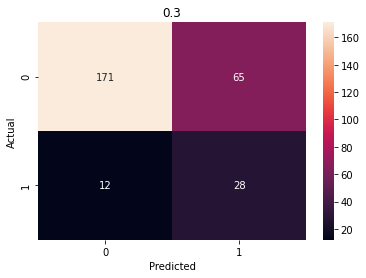

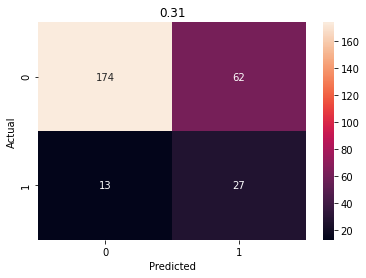

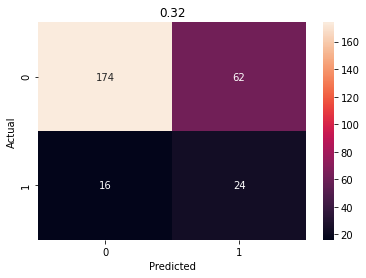

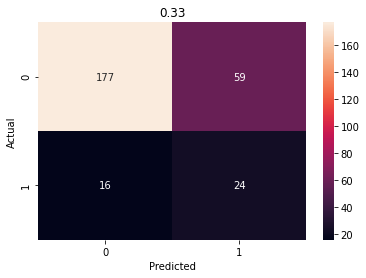

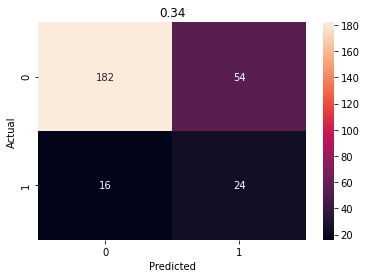

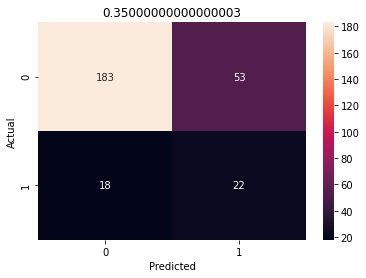

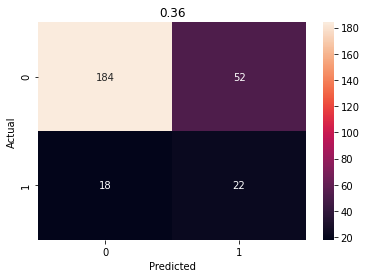

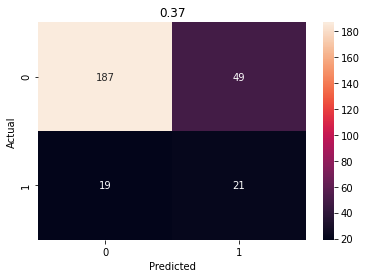

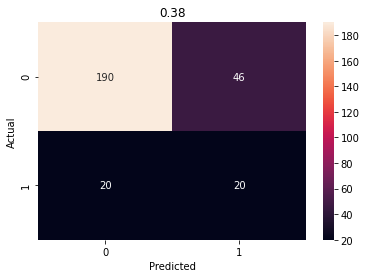

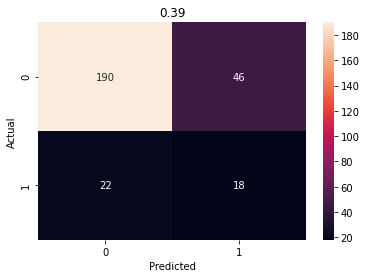

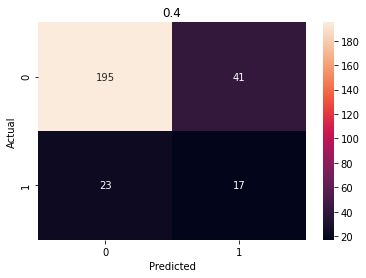

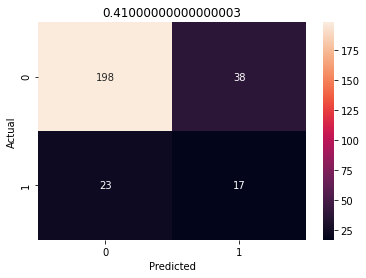

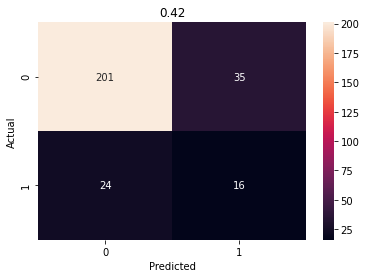

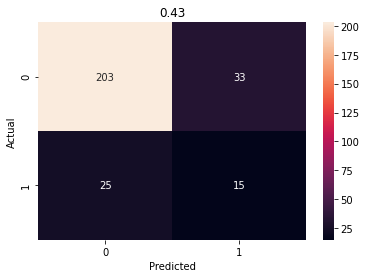

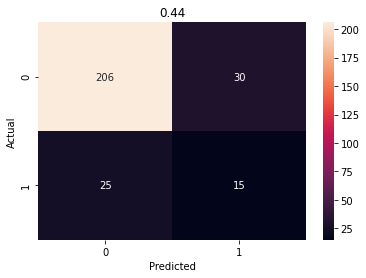

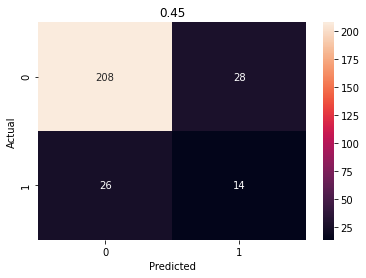

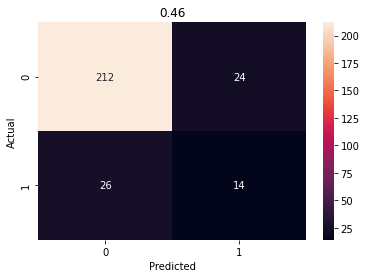

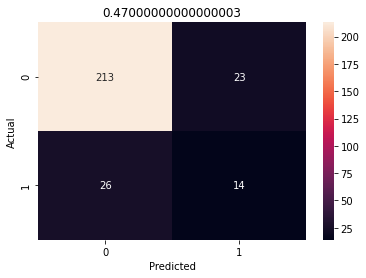

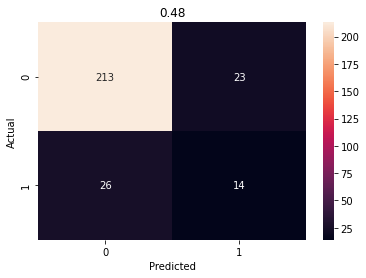

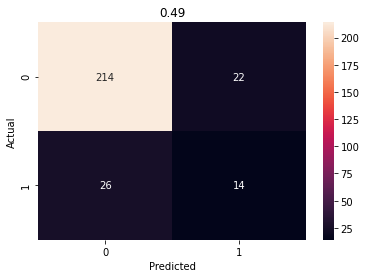

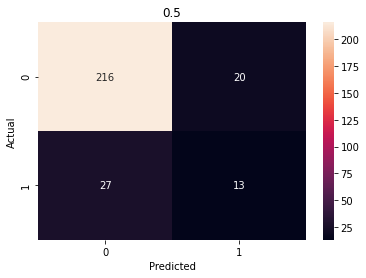

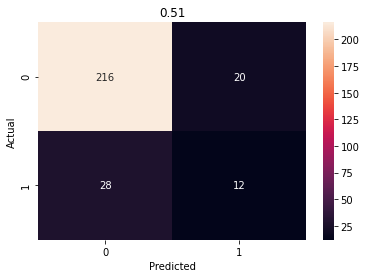

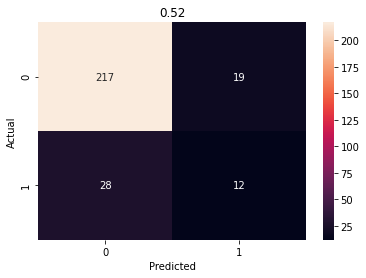

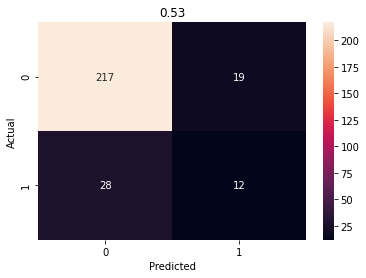

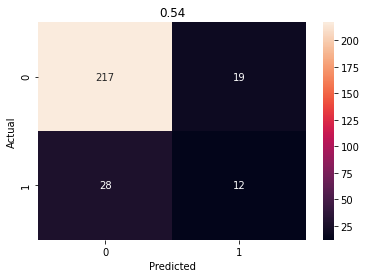

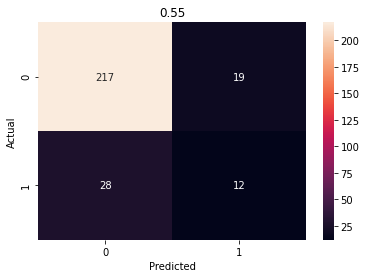

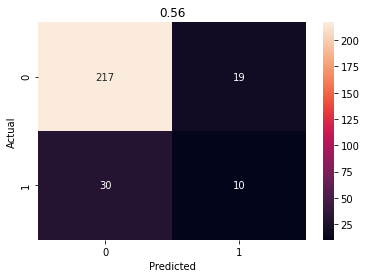

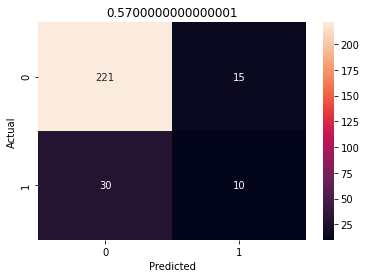

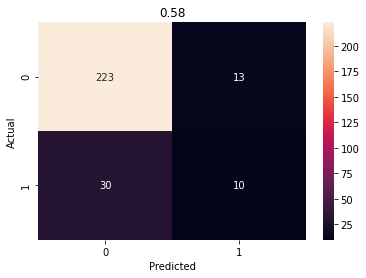

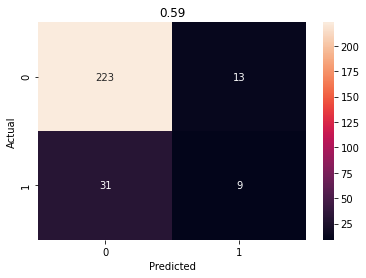

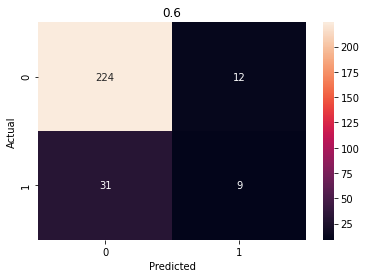

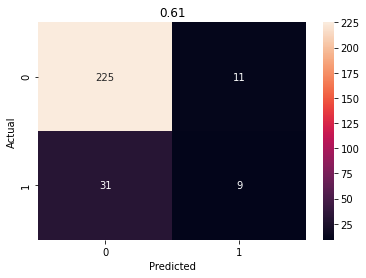

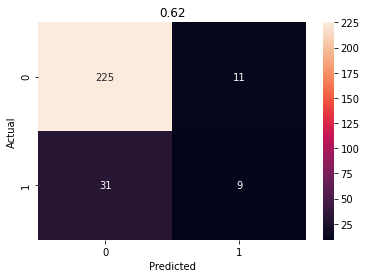

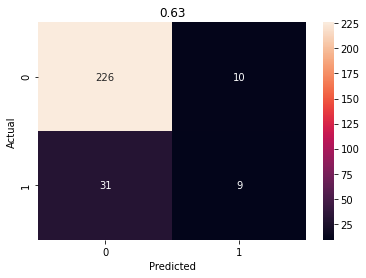

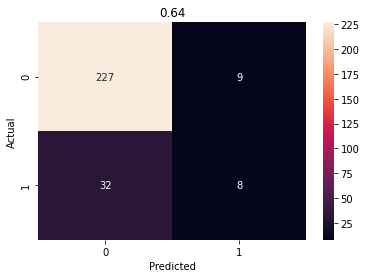

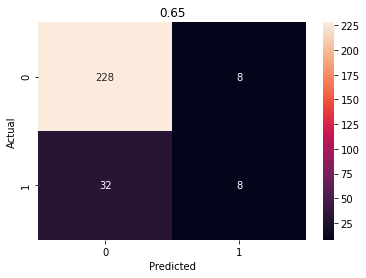

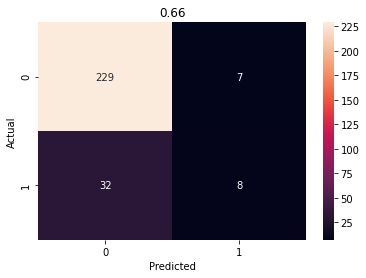

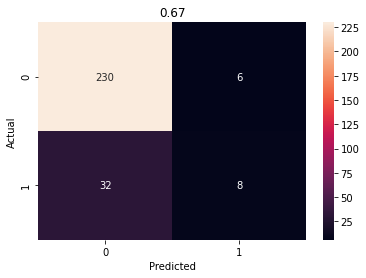

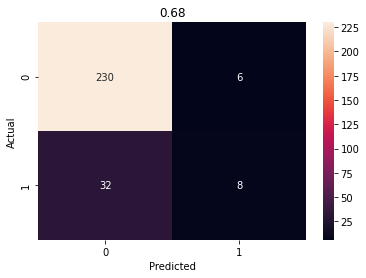

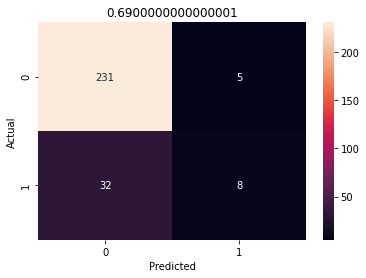

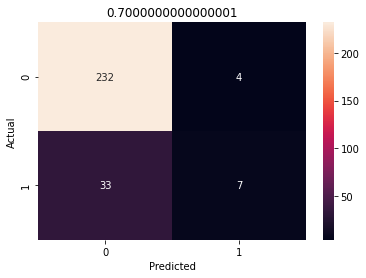

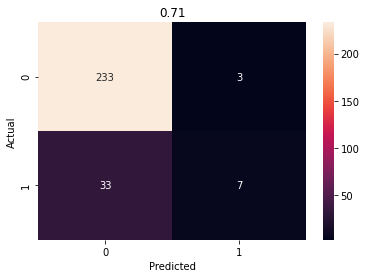

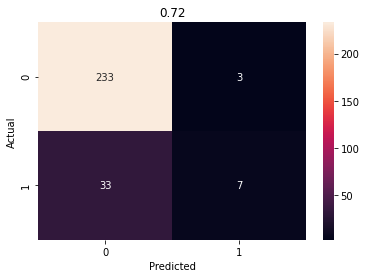

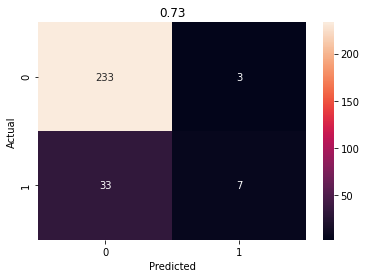

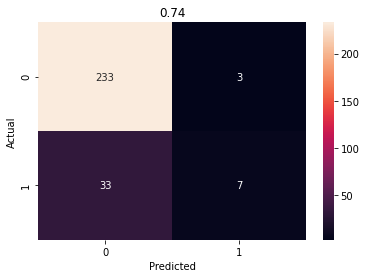

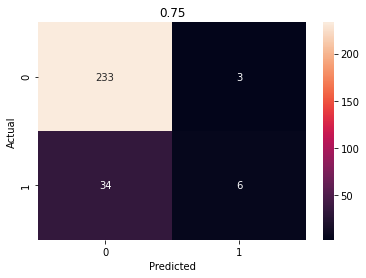

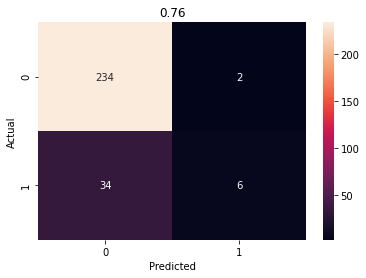

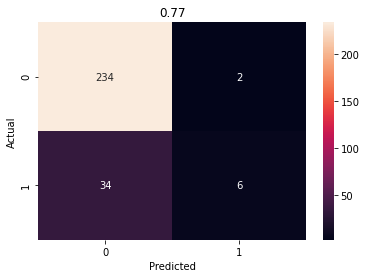

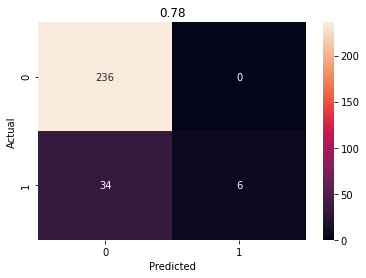

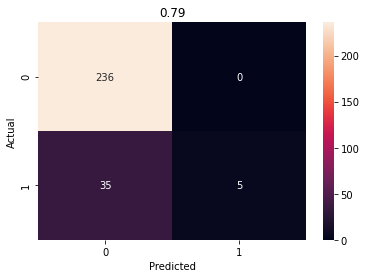

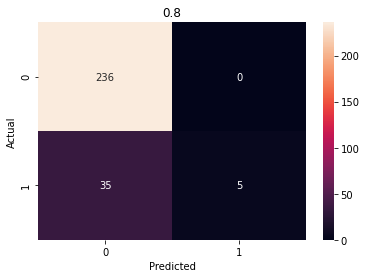

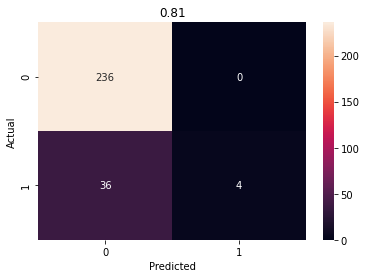

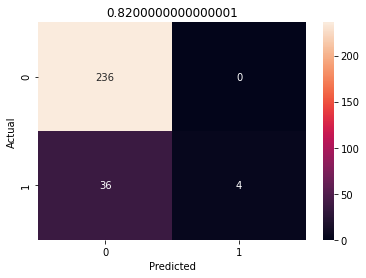

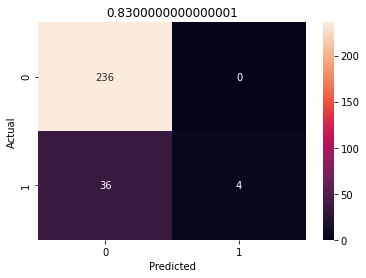

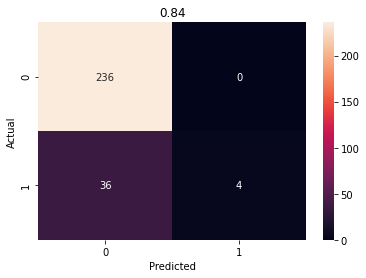

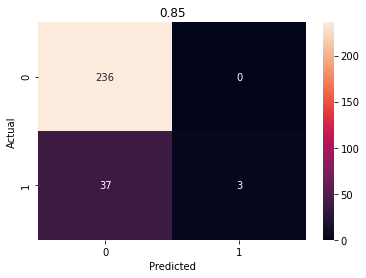

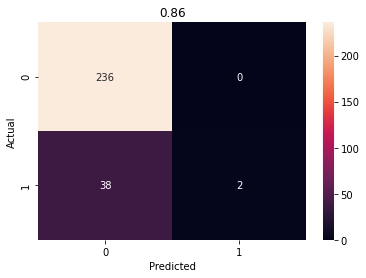

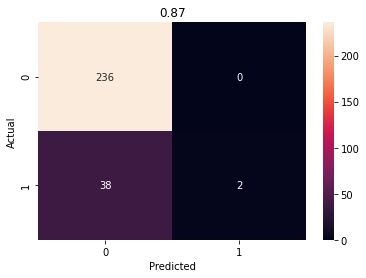

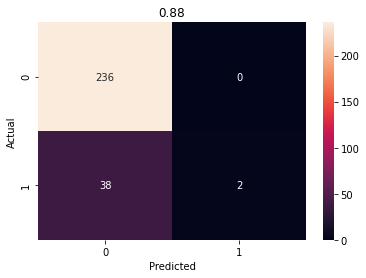

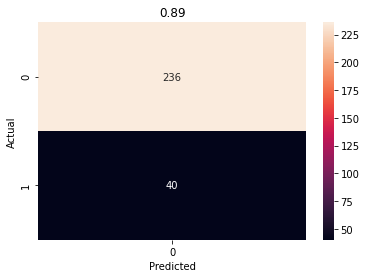

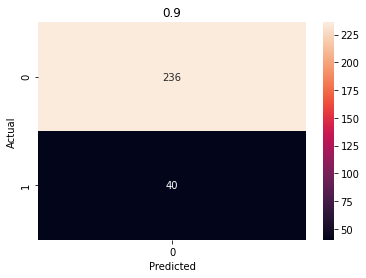

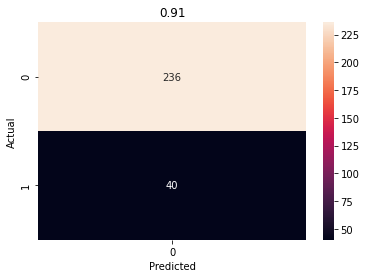

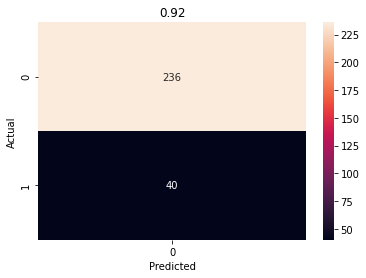

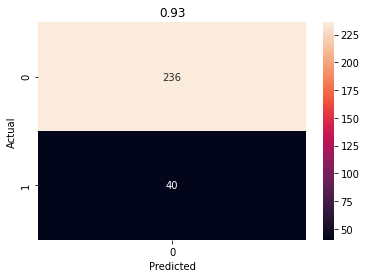

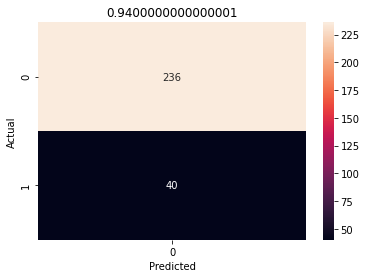

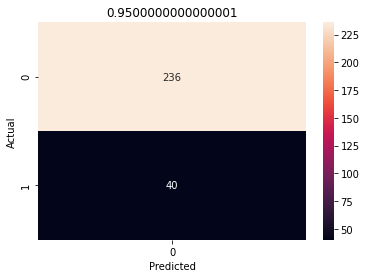

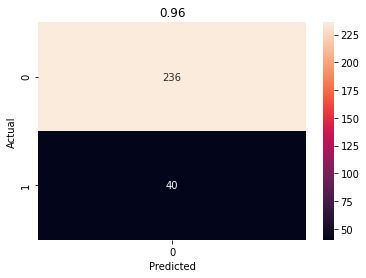

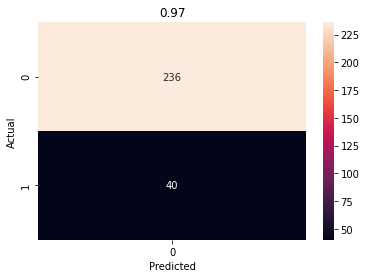

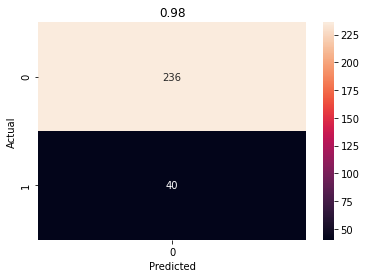

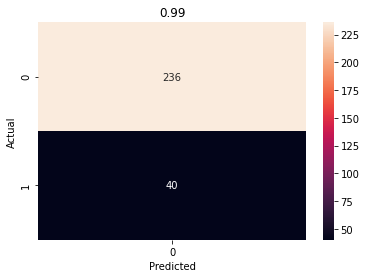

In [265]:
for threshold in np.arange(0,1,0.01):
    predicted_proba = soft_voting_model.predict_proba(X_val)
    predicted = (predicted_proba[:, 1] >= threshold).astype('int')
    plt.title(threshold)
    data = {
    'y_true':  y_val,
    'y_pred': predicted
    }

    df = pd.DataFrame(data, columns=['y_true','y_pred'])
    
    confusion_matrix = pd.crosstab(df['y_true'], df['y_pred'], rownames=['Actual'], colnames=['Predicted'])
    sns.heatmap(confusion_matrix, annot = True, fmt = 'd')
    plt.show()

In [266]:
import joblib
model_name = 'final_model_softvoting_logr_rf_xgb.joblib'
joblib.dump(soft_voting_model, model_name)

['final_model_softvoting_logr_rf_xgb.joblib']

In [103]:
path = '/Users/renanfmoises/code/renanfmoises/people-analytics/rs_xgboost_final.joblib'
model = joblib.load(path)

In [105]:
y_pred = model.predict(X_val)

In [109]:
pd.Series(y_pred).value_counts()

print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.90      0.89       236
           1       0.35      0.33      0.34        40

    accuracy                           0.82       276
   macro avg       0.62      0.61      0.62       276
weighted avg       0.81      0.82      0.81       276



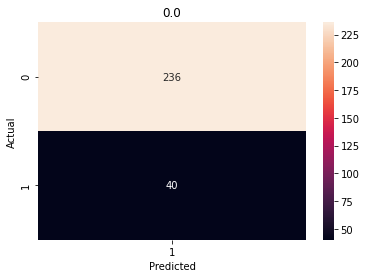

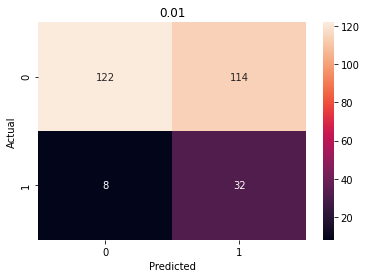

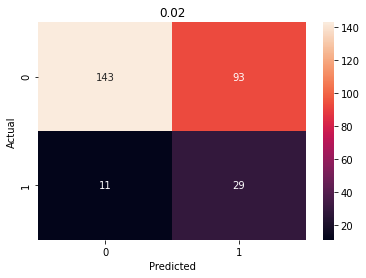

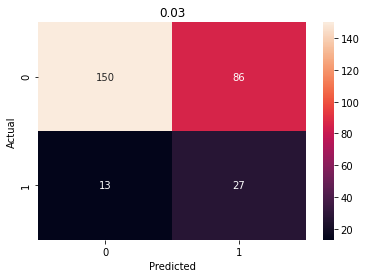

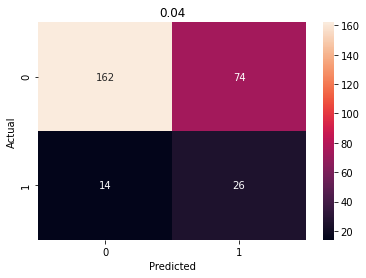

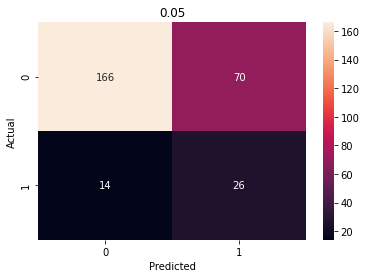

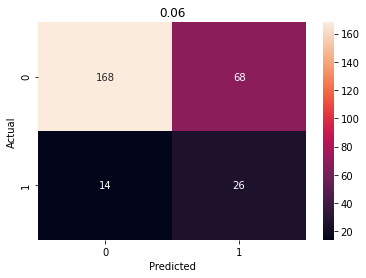

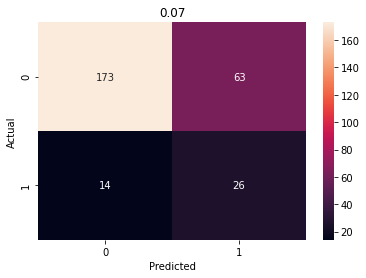

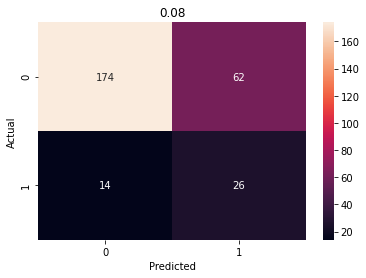

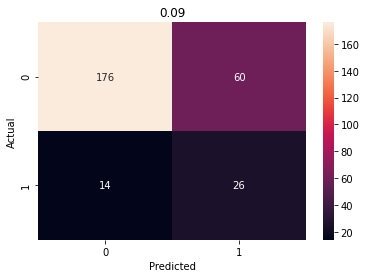

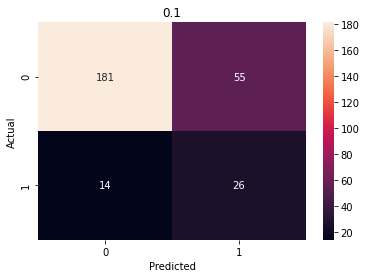

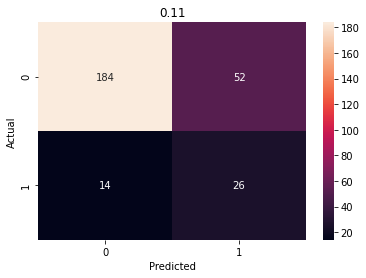

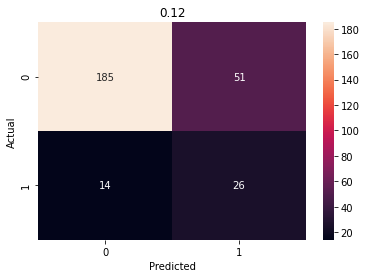

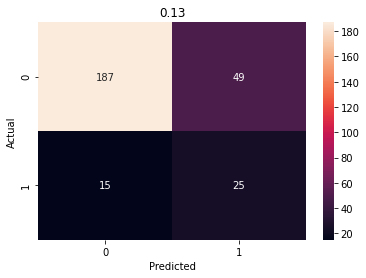

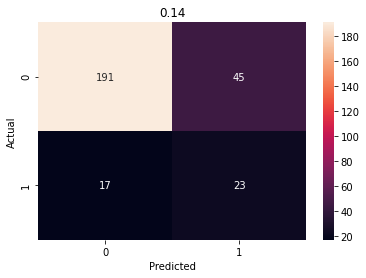

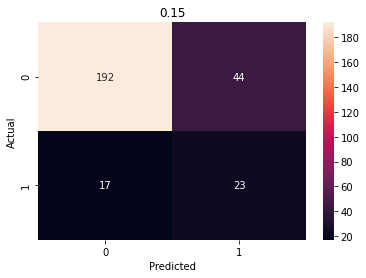

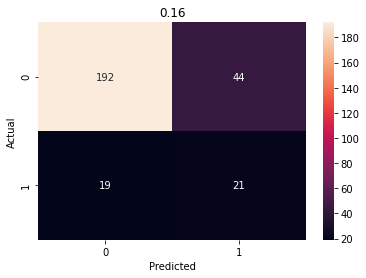

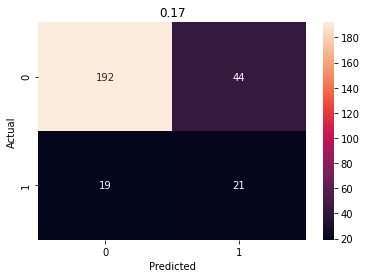

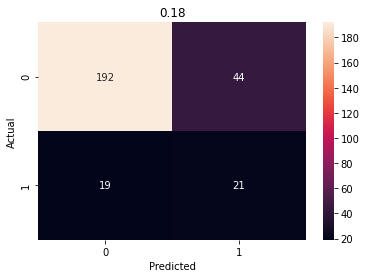

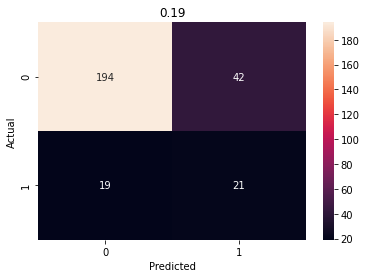

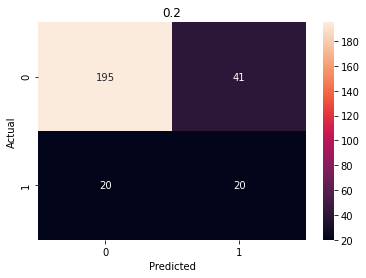

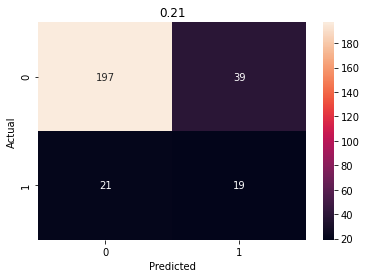

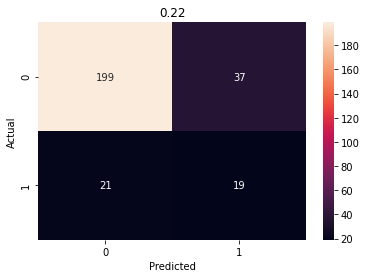

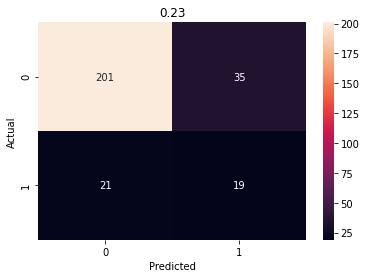

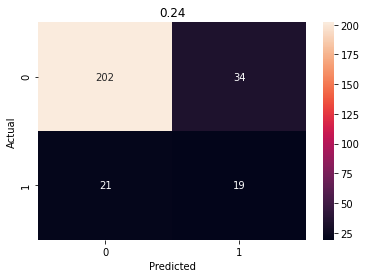

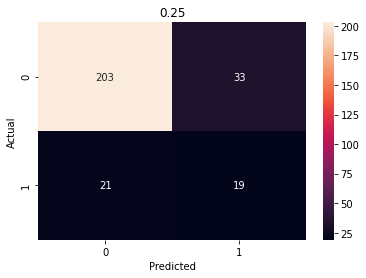

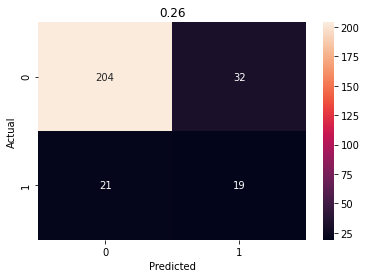

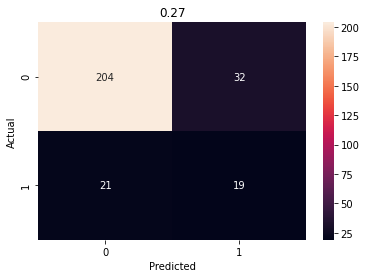

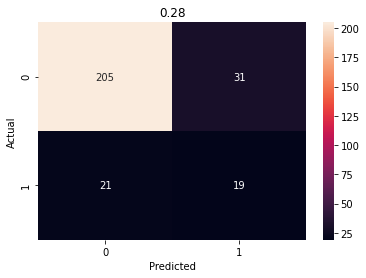

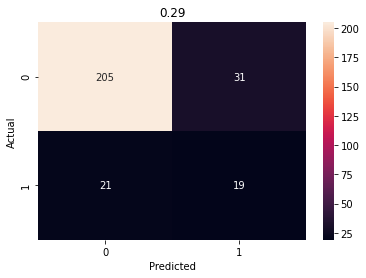

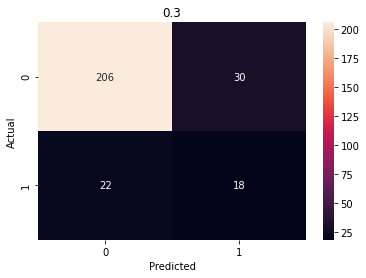

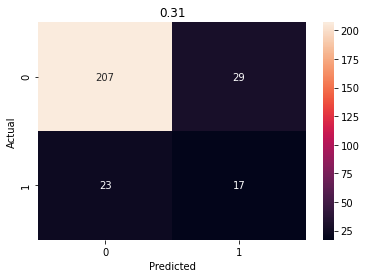

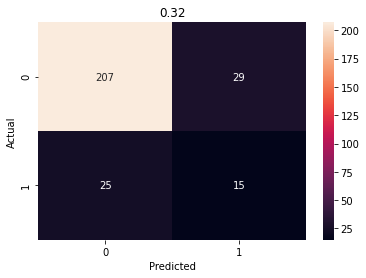

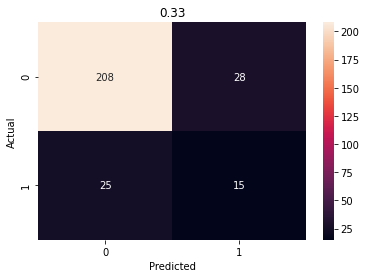

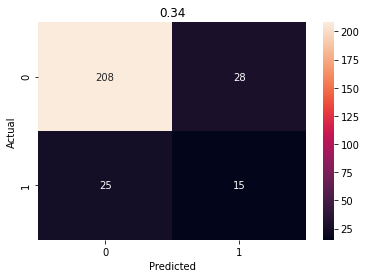

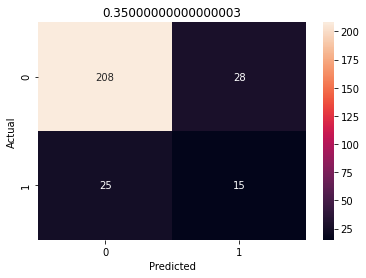

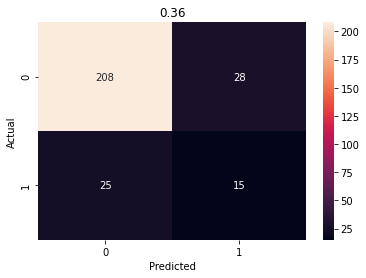

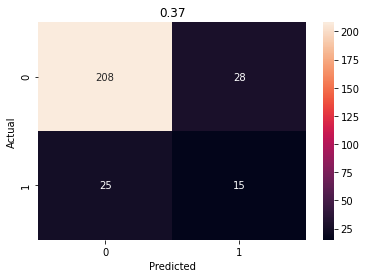

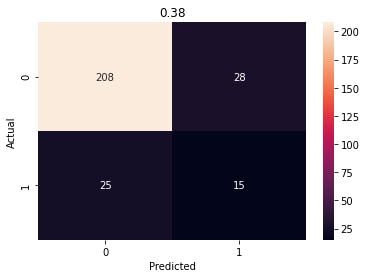

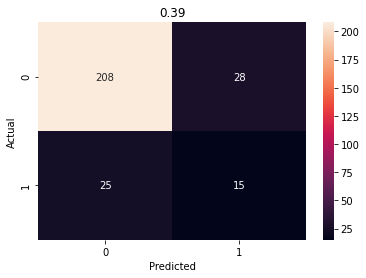

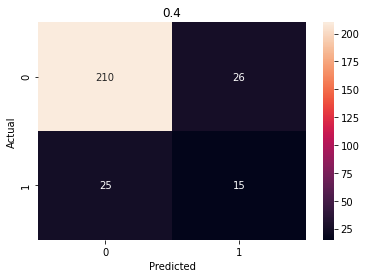

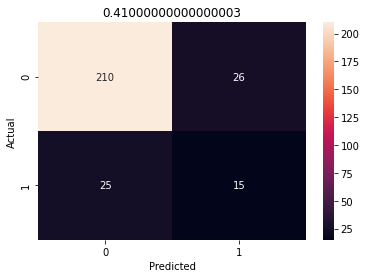

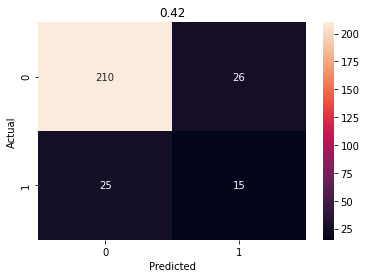

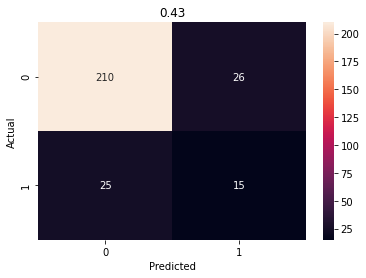

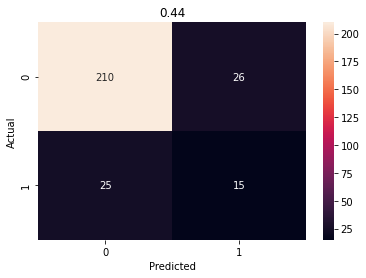

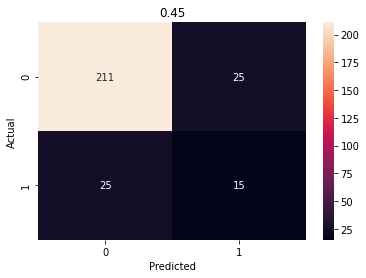

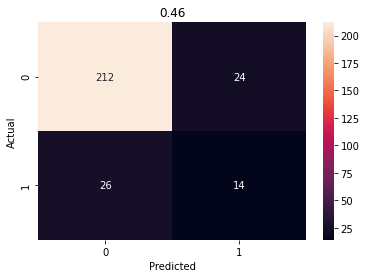

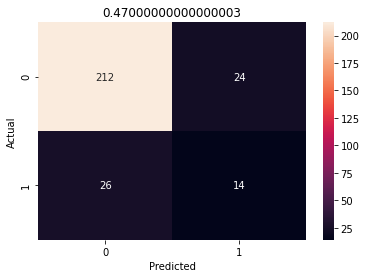

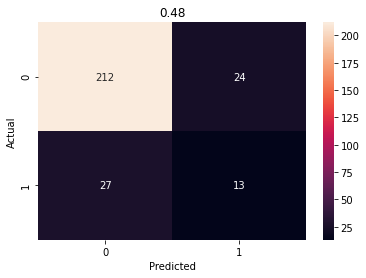

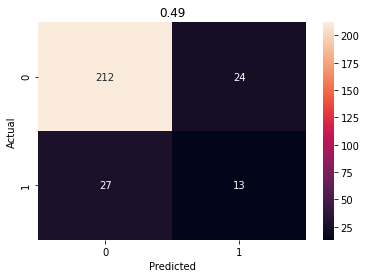

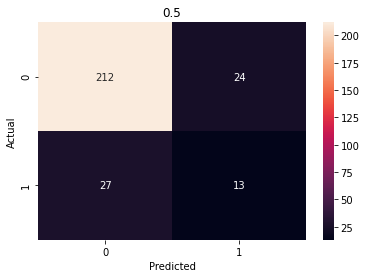

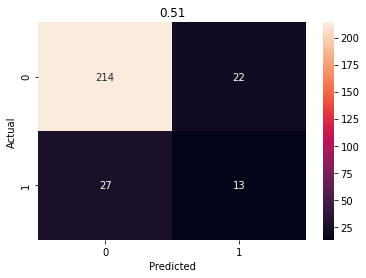

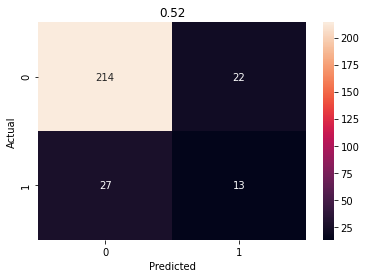

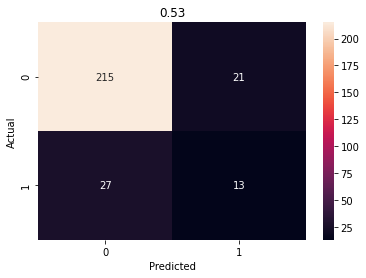

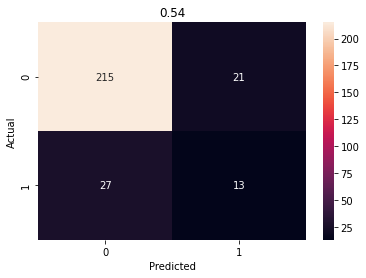

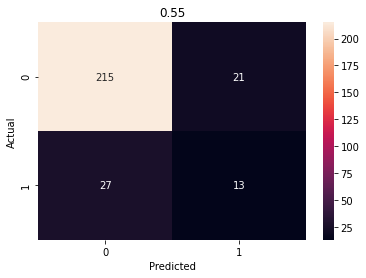

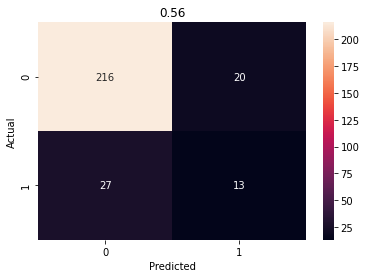

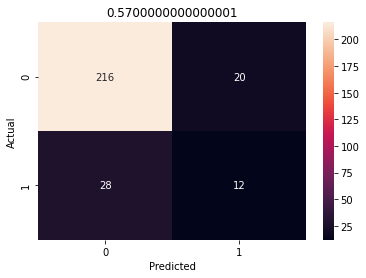

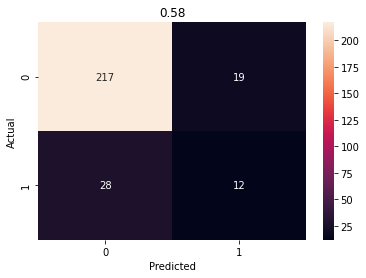

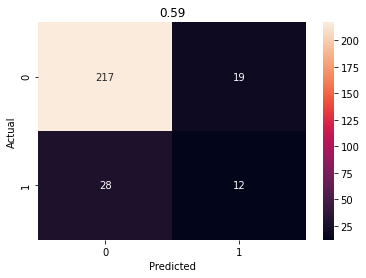

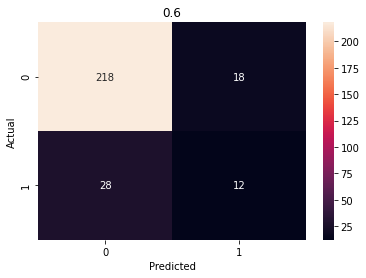

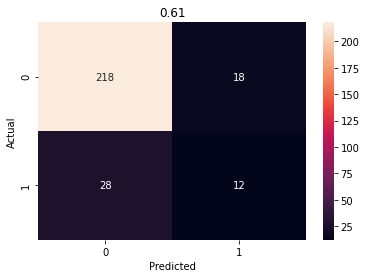

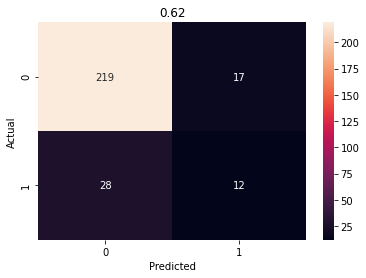

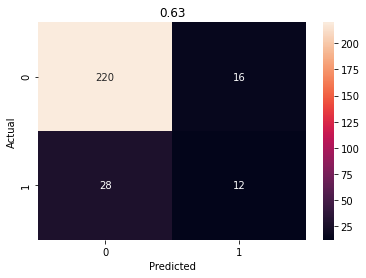

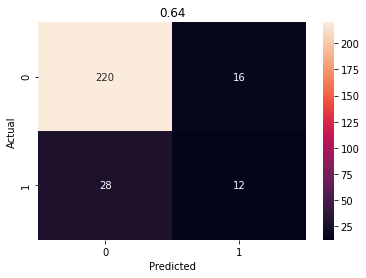

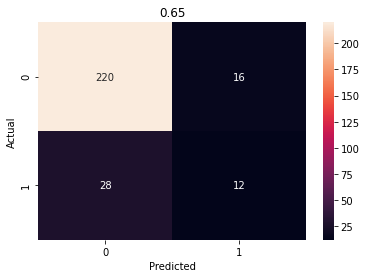

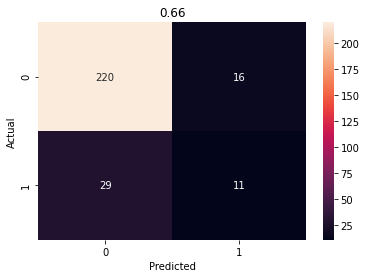

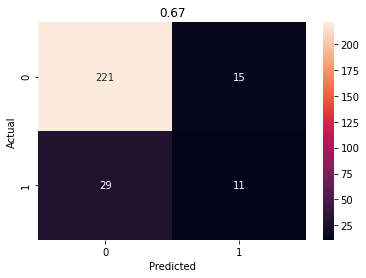

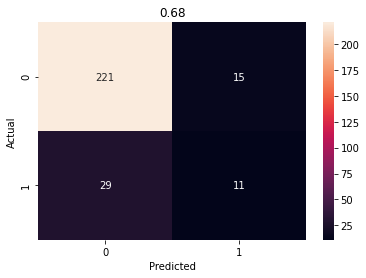

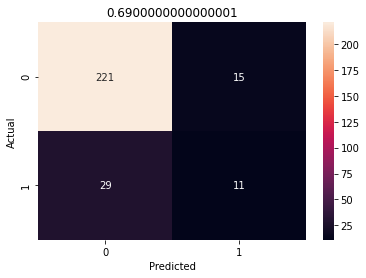

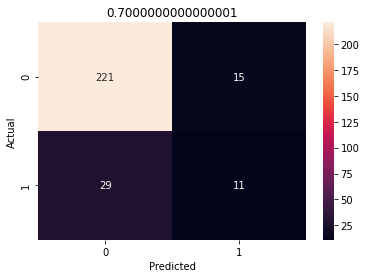

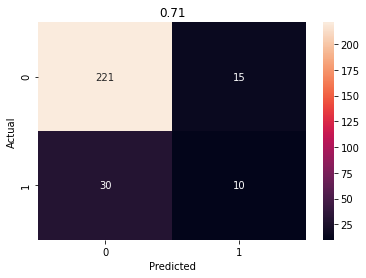

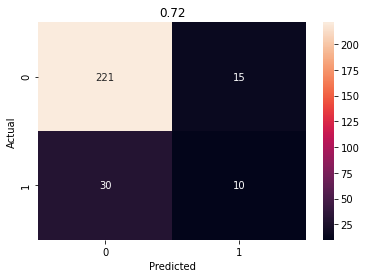

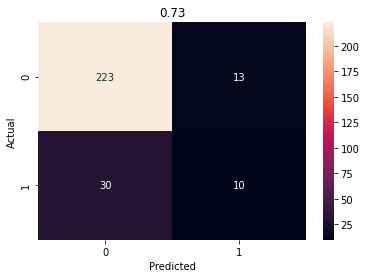

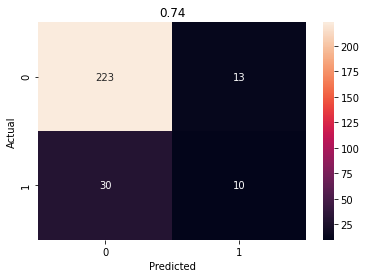

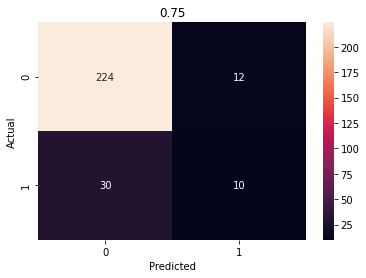

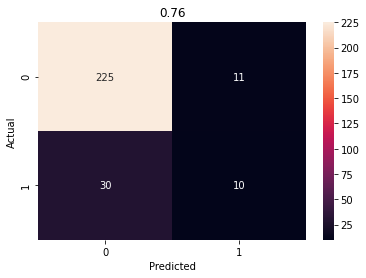

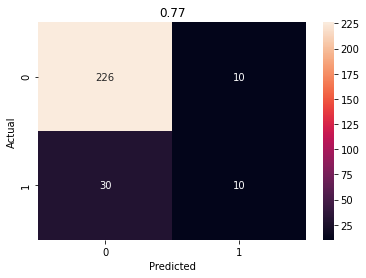

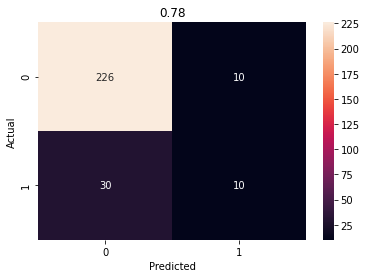

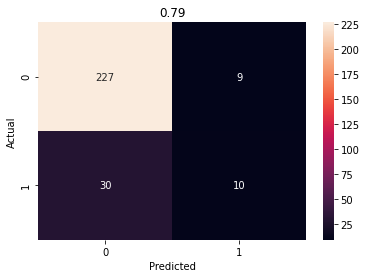

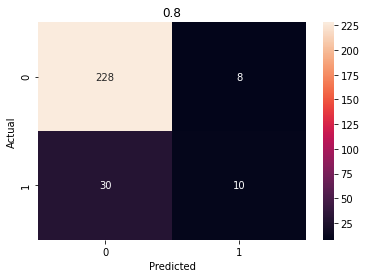

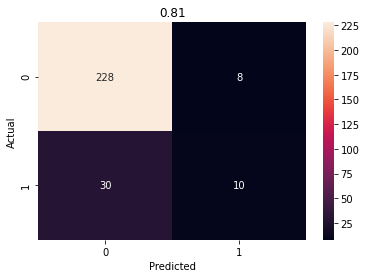

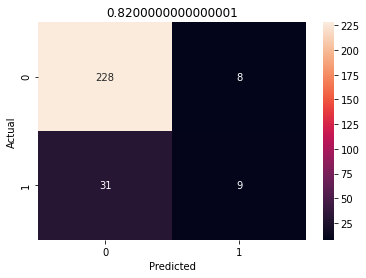

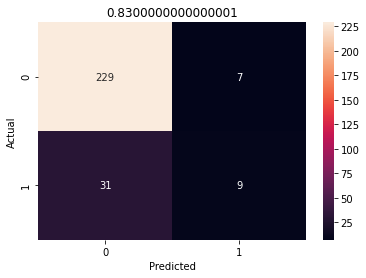

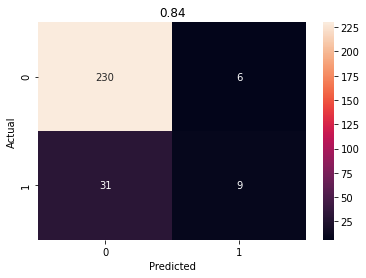

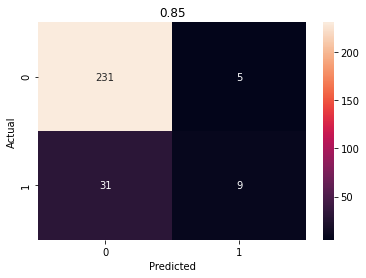

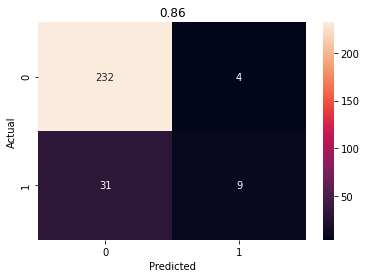

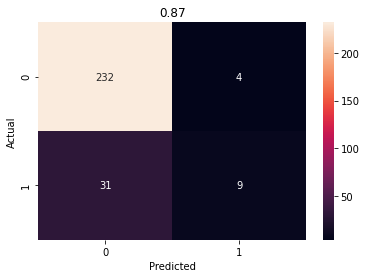

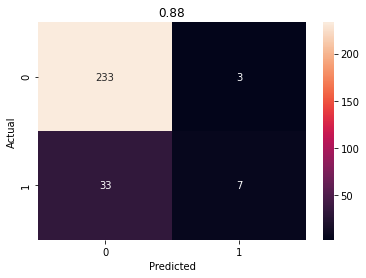

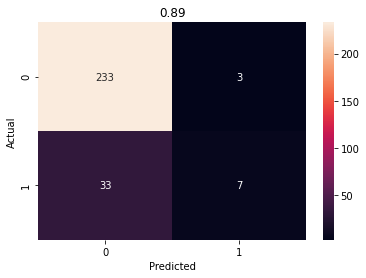

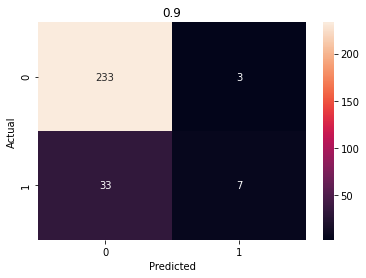

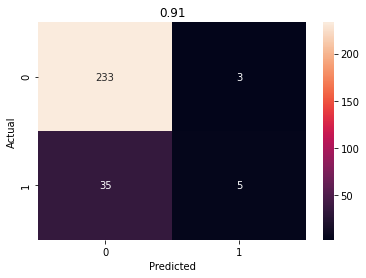

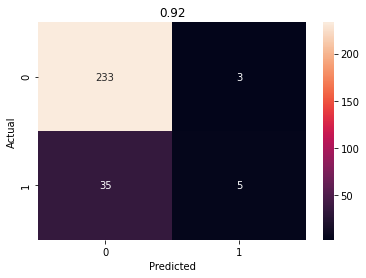

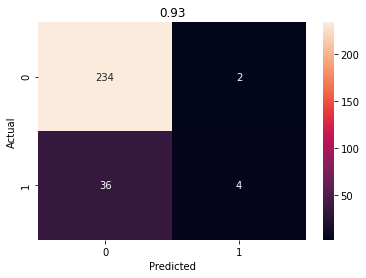

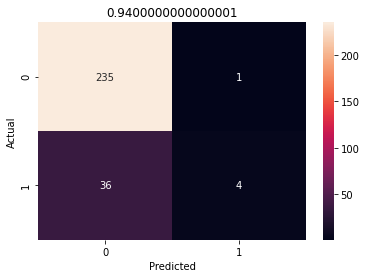

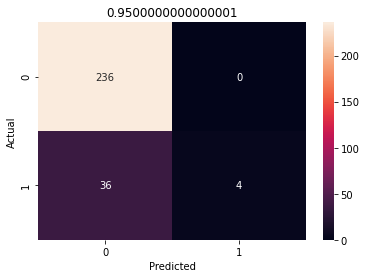

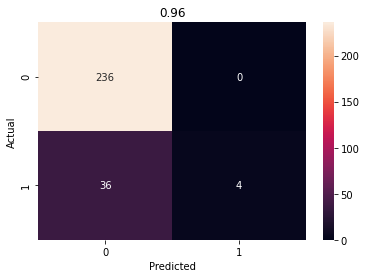

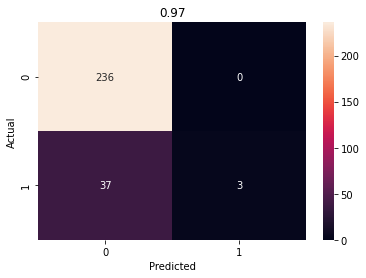

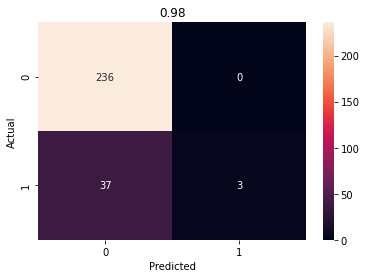

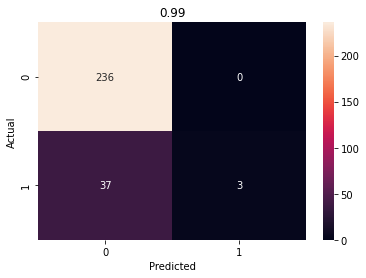

In [121]:
for threshold in np.arange(0,1,0.01):
    predicted_proba = model.predict_proba(X_val)
    predicted = (predicted_proba[:, 1] >= threshold).astype('int')
    plt.title(threshold)
    data = {
    'y_true':  y_val,
    'y_pred': predicted
    }

    df = pd.DataFrame(data, columns=['y_true','y_pred'])
    
    confusion_matrix = pd.crosstab(df['y_true'], df['y_pred'], rownames=['Actual'], colnames=['Predicted'])
    sns.heatmap(confusion_matrix, annot = True, fmt = 'd')
    plt.show()

In [124]:
predicted_proba = model.predict_proba(X_val)
predicted = (predicted_proba[:, 1] >= .12).astype('int')
pd.Series(predicted).value_counts()

0    199
1     77
dtype: int64

business_travel  daily_rate  distance_from_home  education  \
14         -0.110999    0.931413                 1.4       -2.0   
27         -0.110999    0.050327                -0.6        0.0   
196        -0.110999    0.290149                -0.3       -1.0   
159         2.007224    1.403237                 0.3        1.0   
187        -0.110999   -1.177458                -0.6        0.0   
247        -2.229221   -0.502306                -0.5        1.0   
204        -0.110999   -1.281728                -0.5        0.0   
31          2.007224   -1.193098                 2.1       -1.0   
70         -2.229221    0.819322                 2.1        0.0   
272        -0.110999    1.606564                -0.1        0.0   
34         -2.229221    1.082605                -0.5       -1.0   
75         -0.110999    0.021653                 1.7        1.0   
231        -0.110999    1.609171                -0.6        2.0   
85         -0.110999    1.027863                -0.4        1.0   
18         -0.110999    0.086822                 1.0        2.0   
1          -0.110999    1.293753                -0.5       -2.0   
108         2.007224    1.215550                -0.4        0.0   
142        -0.110999    1.559642                 0.6       -1.0   
192         2.007224   -0.520554                -0.2        1.0   
198        -0.110999    0.853210                 0.7        0.0   
270        -0.110999   -0.820331                -0.1       -2.0   
55         -0.110999   -1.161817                -0.5        1.0   
240         2.007224   -0.802084                -0.6       -2.0   
202        -0.110999    0.941840                 0.4       -1.0   
103         2.007224    0.034687                 1.3        0.0   
15         -0.110999   -1.226986                 0.3        1.0   
249        -0.110999    0.806288                -0.6       -1.0   
175        -2.229221    1.838566                 1.8       -1.0   
45         -0.110999   -0.731701                -0.5       -2.0   
97         -0.110999   -1.521550                 2.2        1.0   
239        -0.110999   -1.604967                -0.5       -1.0   
183        -2.229221   -1.719664                -0.3        0.0   
251        -0.110999   -0.411070                 0.6       -2.0   
122         2.007224    0.582107                -0.5       -1.0   
81          2.007224   -0.027876                 0.2        0.0   
141        -0.110999    0.410060                -0.6        0.0   
77         -0.110999    0.368352                -0.6        0.0   
5          -0.110999    0.397027                -0.6       -1.0   
8          -0.110999    0.123317                -0.6        1.0   
2          -0.110999    1.851600                 0.0        1.0   
224        -2.229221   -1.758765                 0.2        0.0   
82         -0.110999    0.042507                -0.3       -2.0   
267        -0.110999    0.376172                -0.5        0.0   
268        -0.110999    1.778610                -0.1        0.0   
200        -0.110999   -0.619611                 1.3        0.0   
65         -0.110999    0.548219                 2.0        0.0   
165        -2.229221    0.170238                -0.6        2.0   
188        -0.110999   -1.067974                 0.3        1.0   
60         -0.110999    0.788041                 0.5        0.0   
214        -0.110999    1.603957                 0.2        1.0   
30         -2.229221   -1.336470                 0.3       -1.0   
253        -0.110999   -1.174851                 1.7        0.0   
264        -0.110999   -0.168641                -0.6        0.0   
101        -2.229221   -0.617004                -0.5        1.0   
54         -0.110999    1.554429                -0.6       -1.0   

     environment_satisfaction  hourly_rate  job_satisfaction  monthly_rate  \
14                   1.386785    -0.708884          1.419055      0.694852   
27                  -0.462262    -0.291012          1.419055      1.346854   
196               

In [125]:
people_analytics = pd.read_csv('../raw_data/people_analytics.csv')
people_analytics

Age Attrition     BusinessTravel  DailyRate              Department  \
0      41       Yes      Travel_Rarely       1102                   Sales   
1      49        No  Travel_Frequently        279  Research & Development   
2      37       Yes      Travel_Rarely       1373  Research & Development   
3      33        No  Travel_Frequently       1392  Research & Development   
4      27        No      Travel_Rarely        591  Research & Development   
...   ...       ...                ...        ...                     ...   
1465   36        No  Travel_Frequently        884  Research & Development   
1466   39        No      Travel_Rarely        613  Research & Development   
1467   27        No      Travel_Rarely        155  Research & Development   
1468   49        No  Travel_Frequently       1023                   Sales   
1469   34        No      Travel_Rarely        628  Research & Development   

      DistanceFromHome  Education EducationField  EmployeeCount  \
0                    1          2  Life Sciences              1   
1                    8          1  Life Sciences              1   
2                    2          2          Other              1   
3                    3          4  Life Sciences              1   
4                    2          1        Medical              1   
...                ...        ...            ...            ...   
1465                23          2        Medical              1   
1466                 6          1        Medical              1   
1467                 4          3  Life Sciences              1   
1468                 2          3        Medical              1   
1469                 8          3        Medical              1   

      EmployeeNumber  ...  RelationshipSatisfaction StandardHours  \
0                  1  ...                         1            80   
1                  2  ...                         4            80   
2                  4  ...                         2            80   
3                  5  ...                         3            80   
4                  7  ...                         4            80   
...              ...  ...                       ...           ...   
1465            2061  ...                         3            80   
1466            2062  ...                         1            80   
1467            2064  ...                         2            80   
1468            2065  ...                         4            80   
1469            2068  ...                         1            80   

      StockOptionLevel  TotalWorkingYears  TrainingTimesLastYear  \
0                    0                  8                      0   
1                    1                 10                      3   
2                    0                  7                      3   
3                    0                  8                      3   
4                    1                  6                      3   
...                ...                ...                    ...   
1465                 1                 17                      3   
1466                 1                  9                      5   
1467                 1                  6                      0   
1468                 0                 17                      3   
1469                 0                  6                      3   

     WorkLifeBalance  YearsAtCompany YearsInCurrentRole  \
0                  1               6                  4   
1                  3              10                  7   
2                  3               0                  0   
3                  3               8                  7   
4                  3               2                  2   
...              ...             ...                ...   
1465               3               5                  2   
1466               3               7                  7   
1467               3               6                  2   
1468               2               9    

In [126]:
people_testcsv = pd.read_csv('../raw_data/people_test.csv')
people_testcsv

employee_id  age  attrition    business_travel  daily_rate  \
0            592   36          0         Non-Travel         635   
1           1545   33          0      Travel_Rarely         575   
2           1380   35          1  Travel_Frequently         662   
3           1092   40          0      Travel_Rarely        1492   
4           1868   29          1  Travel_Frequently         459   
..           ...  ...        ...                ...         ...   
436         1133   36          0         Non-Travel         217   
437          530   31          0      Travel_Rarely         329   
438          615   40          0         Non-Travel        1094   
439          543   52          0      Travel_Rarely         319   
440          817   33          0      Travel_Rarely         213   

                 department  distance_from_home  education   education_field  \
0                     Sales                  10          4           Medical   
1    Research & Development                  25          3     Life Sciences   
2                     Sales                  18          4         Marketing   
3    Research & Development                  20          4  Technical Degree   
4    Research & Development                  24          2     Life Sciences   
..                      ...                 ...        ...               ...   
436  Research & Development                  18          4     Life Sciences   
437  Research & Development                   1          2     Life Sciences   
438                   Sales                  28          3             Other   
439  Research & Development                   3          3           Medical   
440  Research & Development                   7          3           Medical   

     environment_satisfaction  ...  performance_rating  \
0                           2  ...                   3   
1                           4  ...                   3   
2                           4  ...                   3   
3                           1  ...                   4   
4                           4  ...                   4   
..                        ...  ...                 ...   
436                         1  ...                   4   
437                         4  ...                   3   
438                         3  ...                   3   
439                         4  ...                   3   
440                         3  ...                   3   

     relationship_satisfaction  stock_option_level  total_working_years  \
0                            4                   0                   10   
1                            4                   0                    5   
2                            3                   1                    5   
3                            4                   1                   14   
4                            2                   0                    1   
..                         ...                 ...                  ...   
436                          1                   0                   18   
437                          3                   1                    4   
438                          3                   1                   20   
439                          3                   0                   28   
440                          4                   0                   14   

    training_times_last_year  work_life_balance years_at_company  \
0                          3                  2               10   
1                          2                  3                5   
2                          0                  2                4   
3                          6                  3               11   
4                          3                  2                1   
..                       ...                ...              ...   
436                        0                  3               11   
437                        3                  3                4   
438                        2 